<h1>Multitask facial analysis: gender/ethinicty classification and age regression </h1>


In this notebook, we implement two models: a multitask classification model for predicting both age and gender, and a regression model specifically designed to estimate age. For both tasks, we use a modified version of ResNet18, adapted to better fit the characteristics of our dataset.
The dataset, sourced from Kaggle (https://www.kaggle.com/datasets/nipunarora8/age-gender-and-ethnicity-face-data-csv), consists of grayscale facial images of size 48×48. Since the dataset provides pixel values rather than actual image files, we reconstruct the images directly from these pixel arrays.

# Data preprocessing

## Dataset loading 

First, we import all the libraries required for our models. Then, we load the dataset and check whether any missing values (NAs) are present.
Next, we separate the labels from the image data: we create y, which contains all the label information after removing the pixel column, and we create X, which includes only the image data after dropping the target columns.
Finally, we count the values for gender and ethnicity to inspect the distribution of the images within the dataset.

In [1]:
import math
import random
import re
import shutil
import hashlib
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
import torch.optim as optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as T
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score,
    accuracy_score, balanced_accuracy_score, roc_curve, auc,
    mean_absolute_error, mean_squared_error
)

import mediapipe as mp


In [4]:
df = pd.read_csv("~/Desktop/age_gender.csv", sep = ";")
print(df.shape)
df.head()


(23705, 5)


,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [3]:
df.isna().sum()


age          0
ethnicity    0
gender       0
img_name     0
pixels       0
dtype: int64

In [4]:
print(df.columns)


Index(['age', 'ethnicity', 'gender', 'img_name', 'pixels'], dtype='object')


In [5]:
columns = ["age","gender","ethnicity"]
y = df.drop("pixels", axis = 1)
X = df.drop(columns, axis = 1)
X.head()

,img_name,pixels
0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [6]:
y.head()

,age,ethnicity,gender,img_name
0,1,2,0,20161219203650636.jpg.chip.jpg
1,1,2,0,20161219222752047.jpg.chip.jpg
2,1,2,0,20161219222832191.jpg.chip.jpg
3,1,2,0,20161220144911423.jpg.chip.jpg
4,1,2,0,20161220144914327.jpg.chip.jpg


The dataset categorizes ethnicity into the following groups:

- 0 = White

- 1 = Black

- 2 = Asian

- 3 = Indian

- 4 = Other

In [7]:
df.ethnicity.value_counts()

ethnicity
0    10078
1     4526
3     3975
2     3434
4     1692
Name: count, dtype: int64

Ethnicity is quite unbalanced, especially for class 4. 

In [8]:
df.gender.value_counts() # 0 = male, 1 = female

gender
0    12391
1    11314
Name: count, dtype: int64

Instead gender is pretty balanced as shown above.

## Images visualization 

We transform the pixel string found in each row of the dataset into a numerical array to reconstruct the image.
The pixels_to_array function splits the string into individual values and converts them into a uint8 array. By applying this function to the pixels column, we create a new column, pixel_array, which contains the numerical representation of each image.

Afterward, we compute the total number of pixels in the first image and take its square root to determine the image’s dimensions. Since all images share the same structure, they can be easily visualized and preprocessed.

In [2]:
def pixels_to_array(y):
    arr = np.array(y.split(), dtype=np.uint8)
    return arr

In [5]:
df["pixel_array"] = df["pixels"].apply(pixels_to_array)

length = df["pixel_array"].iloc[0].size
print("Total number of pixels:", length)

side = int(np.sqrt(length))
print("The image is:", side, "x", side)

Total number of pixels: 2304
The image is: 48 x 48


In [7]:
img = df["pixel_array"].iloc[0].reshape(side, side)

We randomly select 20 images from the dataset, along with their corresponding gender and ethnicity labels, to visually inspect the data before starting the model implementation.

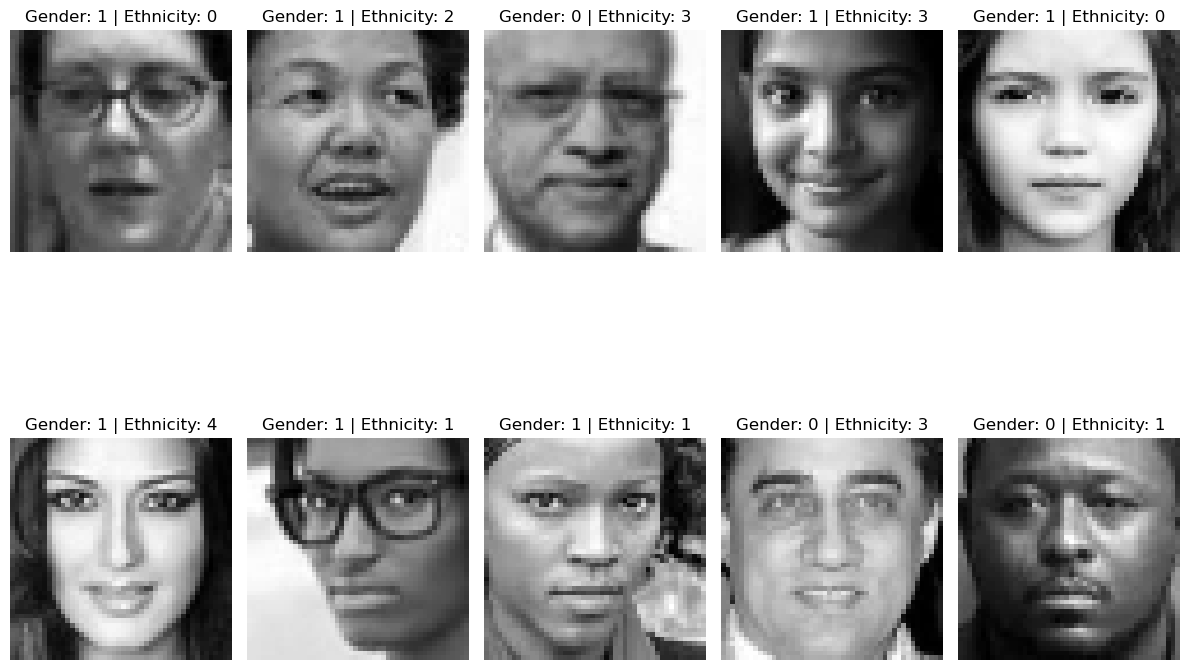

In [10]:
indices = np.random.choice(len(df), 10, replace=False)

rows = 2
cols = 5

plt.figure(figsize=(12, 10))

for i, idx in enumerate(indices):
    row = df.iloc[idx]
    img = row["pixel_array"].reshape(side, side)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"Gender: {row['gender']} | Ethnicity: {row['ethnicity']}")
    plt.axis("off")

plt.tight_layout()
plt.show()

## Dataset saving 

This code block reconstructs the original grayscale images from their pixel values, exports them as PNG files with their corresponding labels in the filename, and finally creates a ZIP archive of the generated dataset. It is useful when we need to visualize the images, inspect data quality, or use the exported files for further processing.

In [ ]:
# 1) Create a clean output directory
# The folder dataset_images is created from scratch. If it already exists, it is removed to avoid mixing previous exports with the new output.

out_dir = Path("dataset_images")
if out_dir.exists():
    shutil.rmtree(out_dir)
out_dir.mkdir(parents=True, exist_ok=True)

# 2) Save each image as PNG with descriptive filenames
# For every row in the dataset, the pixel array is reshaped into a square grayscale image and saved as a PNG.
# The filename includes the sample index and its associated labels (age, gender, ethnicity), making it easy to track or filter images outside the notebook.
saved = 0
for i, row in df.iterrows():
    img = row["pixel_array"].reshape(side, side).astype(np.uint8)   # grayscale
    fname = f"img_{i:06d}_age{row['age']}_gender{row['gender']}_eth{row['ethnicity']}.png"
    Image.fromarray(img).save(out_dir / fname)
    saved += 1

print(f"Saved {saved} images in {out_dir.resolve()}")

# 3) Create a ZIP archive
# The entire folder of exported images is compressed into dataset_images.zip, ready for download or external usage.
shutil.make_archive("dataset_images", "zip", "dataset_images")

## Duplicate removal 

Before implementing the model, we first checked whether the dataset contained duplicate images.
To do this, we computed a hash value for each image:

In [5]:
df["hash"] = df["pixel_array"].apply(lambda x: hash(tuple(x)))

print(df["hash"].nunique(), len(df))

23315 23705


This code converts each image into a tuple of pixel values and applies Python’s built-in hash() function. If two images have exactly the same pixel array, they will produce the same hash.
By comparing the number of unique hashes with the total number of rows in the dataset, we immediately noticed that they did not match, indicating the presence of duplicate images.

However, to avoid relying solely on exact pixel matches, which would not detect visually identical images saved with slightly different values, we also computed the cosine similarity between image vectors. 

Cosine similarity measures how similar two vectors are by computing the cosine of the angle between them and it is ideal for comparing images or high-dimensional data. A value close to 1 indicates that the two vectors (or images) are nearly identical.
Cosine similiraty is given by: 
$$
\text{cosine\_similarity}(A, B) = \frac{A \cdot B}{\|A\| \, \|B\|}
$$
where (A · B) is the dot product between the two vectors and ||A|| and ||B|| the Euclidean norms (vector magnitudes).

In [6]:
X = np.vstack(df["pixel_array"].values[:200]) # This line selects the first 200 images from the dataset and stacks them into a 2-dimensional NumPy array, where each row represents an image flattened into a vector.
# This is done to limit computation, since cosine similarity on the full dataset could be very expensive.

# compute cosine similarity
sim = cosine_similarity(X)
# The output is a square matrix where each entry sim[i, j] represents the similarity between image i and image j.
# Values close to 1 indicate images that are nearly identical.

np.fill_diagonal(sim, -1) # Each image is perfectly similar to itself, so the diagonal of the similarity matrix contains all 1s.
# We replace the diagonal with −1 so that the self-similarity values do not interfere when searching for the most similar pair of distinct images.

i, j = np.unravel_index(sim.argmax(), sim.shape) # sim.argmax() finds the position of the maximum value in the entire similarity matrix.
# np.unravel_index converts this flat index into a pair of coordinates (i, j) corresponding to the two images with the highest similarity.
# Finally, the code prints the indices of the most similar pair along with their similarity score.

print("Most similar copule:", i, j, ", similarity =", sim[i, j])


Most similar copule: 131 139 , similarity = 0.999665757315678


So, for example, the pair of images 131 and 139 is the most similar in the dataset, with a similarity score close to 1. To confirm this, we plotted both images.

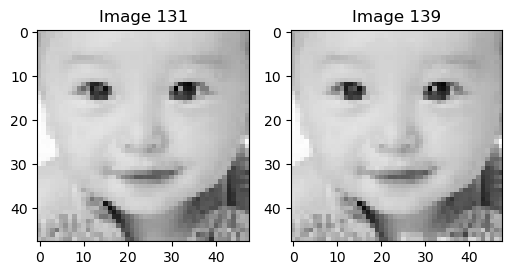

In [15]:
img1 = df["pixel_array"].iloc[i]
img2 = df["pixel_array"].iloc[j]

plt.figure(figsize=(6,3))

plt.subplot(1,2,1)
plt.imshow(img1.reshape(48,48), cmap="gray")
plt.title(f"Image {i}")

plt.subplot(1,2,2)
plt.imshow(img2.reshape(48,48), cmap="gray")

plt.title(f"Image {j}")

plt.show()

In [16]:
i, j = 131, 139

print("Image 1 name:", df.iloc[i]["img_name"])
print("Image 2 name:", df.iloc[j]["img_name"])


Image 1 name: 20161219212648582.jpg.chip.jpg
Image 2 name: 20161219211706614.jpg.chip.jpg


In [17]:
img1 = df.iloc[i]["pixel_array"]
img2 = df.iloc[j]["pixel_array"]

print("Pixels Image 1:", img1[:20], "...")  
print("Pixels Image 2:", img2[:20], "...")


Pixels Image 1: [179 183 194 196 201 203 208 208 213 212 213 214 215 217 219 220 220 221
 219 218] ...
Pixels Image 2: [177 182 194 195 201 203 208 208 213 212 213 214 215 217 219 220 220 221
 219 218] ...


As expected, these two images are visually identical, but their filenames and pixel strings differ slightly. For this reason, they are not recognized as duplicates by simple hashing, even though they clearly represent the same picture. These duplicates must be removed, as they could lead to data leakage when splitting the dataset before training the models.

First, we have removed perfect duplicates just looking at the hash value of the images.


In [7]:
def hash_pixels(arr):
    arr = np.asarray(arr, dtype=np.uint8)
    return hashlib.sha1(arr.tobytes()).hexdigest()

df["pixel_hash"] = df["pixel_array"].apply(hash_pixels)

duplicate_mask = df.duplicated(subset="pixel_hash", keep="first")
perfect_duplicates = df[duplicate_mask]

print(f"Perfect duplicates found: {len(perfect_duplicates)}")

df_no_perfect = df.drop_duplicates(subset="pixel_hash", keep="first").reset_index(drop=True)


Perfect duplicates found: 390


Here, we compute the cosine similarity for the entire dataset and look for values exceeding a fixed threshold.

As we can see from the output, some images are identical while others are extremely similar, which could lead to issues during the dataset split. For this reason, we remove one image from each pair whose similarity exceeds the threshold.

In [9]:
threshold = 0.995

X = np.stack(df_no_perfect["pixel_array"].values) # Converts pixel values to float32 and normalizes them to the [0,1] range to improve accuracy. 
X = X.astype(np.float32) / 255.0
X = X.reshape(len(X), -1)  # flatten

sim_matrix = cosine_similarity(X) # similarity matrix

to_drop = set()

# If image has already been marked for removal, the loop skips it (continue).
# The algorithm removes only one image per highly similar pair, always discarding the second index (j). This prevents unnecessary removals.
for i in range(sim_matrix.shape[0]):
    if i in to_drop:
        continue
    for j in range(i+1, sim_matrix.shape[0]):
        if sim_matrix[i, j] >= threshold:
            to_drop.add(j)

print(f"Images to remove: {len(to_drop)}")

# new dataframe
df_clean = df_no_perfect.drop(list(to_drop)).reset_index(drop=True)

Images to remove: 567


In [9]:
# fast check

df_clean
df_clean["hash"] = df_clean["pixel_array"].apply(lambda x: hash(tuple(x)))

print(df_clean["hash"].nunique(), len(df_clean))

22748 22748


Now, the length of the new clean dataframe matches the number of unique hash values, meaning that all perfect duplicates have been removed. Moreover, we recomputed the cosine similarity to check whether any images still exceed the threshold. Since all highly similar images were successfully removed, the result is zero.

## Data Splitting

Now that we have removed all duplicates and near-identical images, we can proceed with splitting the dataset into training, validation, and test sets. Since the dataset still contains a large number of images even after the cleaning process, we decided to use a 10% test split, and an additional 10% for validation.

In [11]:
# First split: train and test 
train_idx, test_idx = train_test_split(
    np.arange(len(df_clean)),
    test_size=0.1,
    stratify=df_clean["ethnicity"],
    random_state=123
)

train_df_full = df_clean.iloc[train_idx].reset_index(drop=True)
test_df       = df_clean.iloc[test_idx].reset_index(drop=True)

# Second split: train and validation 
train_idx2, val_idx = train_test_split(
    np.arange(len(train_df_full)),
    test_size=0.1,
    stratify=train_df_full["ethnicity"],
    random_state=123
)

train_df = train_df_full.iloc[train_idx2].reset_index(drop=True)
val_df   = train_df_full.iloc[val_idx].reset_index(drop=True)

print("Train:", len(train_df))
print("Val:", len(val_df))
print("Test:", len(test_df))

Train: 18425
Val: 2048
Test: 2275


The splitting is stratified by ethnicity and this ensures that the proportion of each class is preserved in the train, validation, and test sets.
Without stratification, some groups could be under-represented or even missing in one of the splits, especially for minority classes. This is very useful since the dataset is unbalanced across ethnicity categories; moreover, losing representation during splitting would bias the model or performance.

## Data augumentation

To deal with dataset imabalance and small images, avoid overfitting and obtain better performances, we have impletend data agumentation to artificially expands and diversifies the training set by applying random transformations to the input images.
This is crucial for our dataset because: 
- Images are small (48×48) and greyscale, so the model can overfit quickly. Moreover, deep CNNs extract local features but with small images, even minor changes in lighting or pose drastically affect the representation;
- Ethnicity classes are highly unbalanced (e.g., class 0 has about 10000 images while class 4 has only almost 1700 images). Without augmentation, the model would learn to predict class 0 too often and generalize poorly on minority groups;
- Avoid overfitting: if the model sees the same image repeatedly with no variation, it may memorize it.

So, we applied the following base augmentations to all training images:

1. **RandomCrop(48, padding=3)**: pads the image by up to 3 pixels on each side, then extracts a 48×48 region. Helps the model learn translation invariance.

2. **RandomHorizontalFlip(p=0.5)**: with probability 50%, flips the image horizontally. Humans can appear flipped in cameras or mirrors so this augmentation teaches the model not to be sensitive to left/right orientation.

3. **RandomRotation(8)**: rotates image by a random angle in the range [-8°, +8°].

4. **RandomAffine(translate=(0.03, 0.03), scale=(0.95, 1.05))**: simulates small geometric distortions (translation ≤ 3% of width/height (≈ 1–2 pixels), scaling between 95% and 105%). This stabilizes performance when faces appear slightly closer/farther or a bit shifted.

5. **RandomErasing(p=0.10, scale=(0.02, 0.10))**: happens 10% of the time and removes a rectangle covering 2%–10% of the image to simulate glasses glare, shadows, hands, or noise.

6. **Standardization: Normalize([0.5], [0.5])** to map pixel values from [0,1] to $ x' = 2x - 1 \in [-1, 1]$. Centered data helps optimization and stabilizes gradients.

Then we applied some stronger extra augmentations to minority classes:

1. **RandomResizedCrop(scale=(0.85, 1.0))**: image is cropped and resized to 48×48. The crop removes between 0% and 15% of the original area. This increases variability much more strongly for minority classes.

2. **ColorJitter(brightness=0.08, contrast=0.10)**: brightness changes in ±8% and contrast changes in ±10%.

3. **RandomRotation(10)**: a slightly stronger rotation (±10°) applied only to minority classes, increasing variation further.

4. **RandomErasing(p=0.30, scale=(0.02, 0.10))**: for minority classes happens 30% of the time.


In [27]:
class FaceDataset(Dataset):
    def __init__(self,
                 df,
                 side=48,
                 mode="train", # only in training mode
                 apply_augment=True,
                 augment_minorities=True,
                 minority_threshold=0.6,
                 minority_classes=None):

        self.df = df.reset_index(drop=True)
        self.side = side
        self.mode = mode
        self.apply_augment = apply_augment
        self.augment_minorities = augment_minorities and (mode == "train")

        # compute minority classes: defines as minority classes those with fewer samples than 60% of the largest class. 
        # These classes receive stronger augmentation to compensate for imbalance.
        if minority_classes is None:
            vc = df["ethnicity"].value_counts().to_dict()
            maxc = max(vc.values())
            self.minority_classes = {c for c, n in vc.items()
                                     if n < minority_threshold * maxc}
        else:
            self.minority_classes = set(minority_classes)

        # Base augmentations
        self.base_pil = T.Compose([
            T.RandomCrop(side, padding=3),
            T.RandomHorizontalFlip(p=0.5),
            T.RandomRotation(8),
            T.RandomAffine(
                degrees=0,
                translate=(0.03, 0.03),
                scale=(0.95, 1.05),
            )
        ])

        # Extra augmentations 
        self.extra_pil = T.Compose([
            T.RandomResizedCrop(side, scale=(0.85, 1.0)),
            T.ColorJitter(brightness=0.08, contrast=0.10),
            T.RandomRotation(10),
        ])

        # Random erasing
        self.random_erasing_minor = T.RandomErasing(p=0.30, scale=(0.02, 0.10), ratio=(0.3, 3.3))
        self.random_erasing_all   = T.RandomErasing(p=0.10, scale=(0.02, 0.10), ratio=(0.3, 3.3))

        # Standardization 
        self.to_tensor_norm = T.Compose([
            T.ToTensor(),
            T.Normalize([0.5], [0.5]),
        ])

    def __len__(self):
        return len(self.df)

    def _to_pil(self, arr_1d):
        img = np.array(arr_1d, dtype=np.uint8).reshape(self.side, self.side) # Converts the flattened pixel vector into a 48×48 grayscale image.
        return Image.fromarray(img, mode="L")

    def __getitem__(self, idx):

        # Loads image and labels.
        row = self.df.iloc[idx]
        y_eth = int(row["ethnicity"])
        y_gen = int(row["gender"])
        img_pil = self._to_pil(row["pixel_array"])

        # All training images receive the base transformation pipeline.
        if self.mode == "train" and self.apply_augment:
            img_pil = self.base_pil(img_pil)
            # If the sample belongs to a minority ethnicity class, apply stronger transformations.
            if self.augment_minorities and (y_eth in self.minority_classes):
                img_pil = self.extra_pil(img_pil)

            x = self.to_tensor_norm(img_pil)

            # Minority classes get erasing with probability 0.3. All other classes: probability 0.10.
            if self.augment_minorities and (y_eth in self.minority_classes):
                x = self.random_erasing_minor(x)
            else:
                x = self.random_erasing_all(x)

        else:
            x = self.to_tensor_norm(img_pil)

        return x, torch.tensor(y_eth), torch.tensor(y_gen)


In [28]:
# TRAIN: base augmentation + extra for minorities 
train_dataset = FaceDataset(
    train_df,
    side=side,
    mode="train",
    augment_minorities=True,
    minority_threshold=0.6   
)

# VALIDATION: no augmentation
val_dataset = FaceDataset(
    val_df,
    side=side,
    mode="eval",
    augment_minorities=False
)

# TEST: no augmentation
test_dataset = FaceDataset(
    test_df,
    side=side,
    mode="eval",
    augment_minorities=False
)

## Weighted Random Sampler

As said above our dataset is highly imbalanced in the ethnicity classes with class 0 (“White”) that has the largest number of samples and class 4 (“Other”) that has the fewest, the remaining classes fall in between.
So, the model becomes biased toward majority classes and minority classes get underrepresented in each batch.
Even with data augmentation, if we always sample uniformly from the dataset, a standard batch might contain: 70–80% class 0 and very few samples from classes 2, 3, 4.
For this reason we also implemented a weighted random sampler that changes how batches are drawn.
Indeed, majority classes receive smaller sampling probabilities while minority classes receive higher sampling probabilities. This ensures that each batch is more balanced, even if the dataset is not (we simply sample minority images more often).

In [14]:
# Device
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [29]:
# 1. Compute class weights 
y_train_eth = torch.tensor(train_df["ethnicity"].values, dtype=torch.long) # Convert ethnicity labels to a tensor
class_counts = torch.bincount(y_train_eth) # Count samples per class
class_weights = 1.0 / class_counts.float() # Compute inverse-frequency weights

# 2. sample weights for sampler: Each training item gets the weight of its class. So samples from class 4 will have the highest probability of being chosen.
sample_weights = class_weights[y_train_eth]

# 3. WeightedRandomSampler 
sampler = WeightedRandomSampler(
    weights=sample_weights, # sampling probability for each individual image
    num_samples=len(sample_weights), # how many samples to draw per epoch (same as dataset size)
    replacement=True # images can be drawn multiple times per epoch
)
# 4. move only loss weights to GPU
class_weights_eth = class_weights.to(device)

# These weights will be passed to the loss function (CrossEntropyLoss) so that misclassifying a minority sample is penalized more and misclassifying a majority sample is penalized less.


The WeightedRandomSampler ensures that each batch contains a balanced mix of ethnicity classes, regardless of the original distribution. We compute class weights from the inverse frequency of each class, assign a weight to every training sample, and let the sampler draw items accordingly. Minority classes get sampled more often, preventing the model from becoming biased toward the majority class and improving overall training stability.

## DataLoader

In this section we create three DataLoaders, one for training, one for validation, and one for testing.
A DataLoader handles batching, shuffling, and sampling strategies when feeding data to the model.

In [30]:
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    sampler=sampler,
    shuffle=False  # sampler option is mutually exclusive with shuffle. This ensures that each batch contains a more balanced mix of ethnicity classes,
                   # even if the dataset is imbalanced.
)

val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False # shuffle = False ensures stable and reproducible evaluation.
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False
)


### Empirical testing: Weighted Random Sampler and Data augumentation

Even though the WeightedRandomSampler is deterministic in how it uses weights, its behavior is probabilistic: it draws samples according to the weight distribution, not uniformly.

Therefore, performing an empirical verification: confirms that the sampler is behaving as expected, shows whether minority classes are being oversampled correctly, allows us to visually compare original and sampled distributions, is especially important when class imbalance is large (as in our dataset).

Original distribution (train): {0: 7870, 1: 3506, 2: 2687, 3: 3085, 4: 1277}
Sampled distribution (sampler): {0: 3534, 1: 3682, 2: 3650, 3: 3796, 4: 3763}


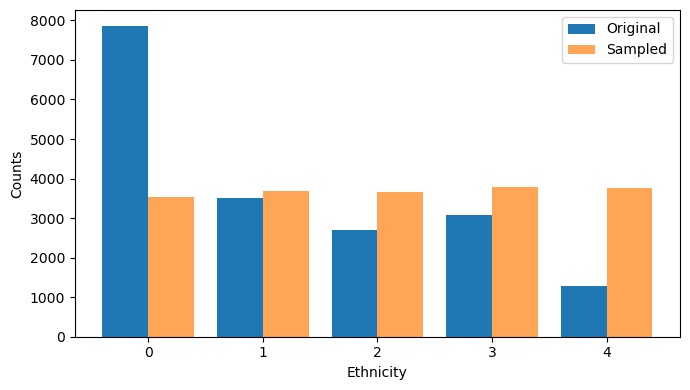

In [20]:
# 1) Draw N samples from the sampler
N = len(sample_weights)
gen = torch.Generator().manual_seed(904)  # Fixes the random seed to make results reproducible.
sampler.num_samples = N     # Uses the same number of samples as the size of the training set.              
sampler_repro = torch.utils.data.WeightedRandomSampler(  # Generates indices with the WeightedRandomSampler, so minority classes appear more frequently.
    weights=sample_weights,
    num_samples=N,
    replacement=True,
    generator=gen
)

indices_sampled = list(iter(sampler_repro)) # Returns a list of sampled indices.

# 2) Count the sampled classes: 
y_train = train_df["ethnicity"].to_numpy()
sampled_classes = y_train[indices_sampled] # how many samples belong to each class before sampling
sampled_counts = Counter(sampled_classes) # how many appear after sampling

# 3) Comparison
orig_counts = Counter(y_train)

print("Original distribution (train):", dict(sorted(orig_counts.items())))
print("Sampled distribution (sampler):", dict(sorted(sampled_counts.items())))

# 4) Plot
classes = sorted(set(y_train))
orig = [orig_counts[c] for c in classes]
samp = [sampled_counts[c] for c in classes]

x = np.arange(len(classes))
w = 0.4
plt.figure(figsize=(7,4))
plt.bar(x - w/2, orig, width=w, label="Original")
plt.bar(x + w/2, samp, width=w, label="Sampled", alpha=0.7)
plt.xticks(x, classes)
plt.xlabel("Ethnicity")
plt.ylabel("Counts")
plt.legend()
plt.tight_layout()
plt.show()


We empirically verified the behavior of the WeightedRandomSampler by simulating one full epoch of sampling. The results show that the sampler drastically reduces the dominance of the majority class (0) and increases the representation of minority classes, producing a nearly balanced distribution. This is essential to prevent model bias and improve training stability. The bar plot visually confirms the effectiveness of the sampling strategy.

We also plotted several images before and after applying data augmentation to visualize the differences introduced by the transformations. We chose to show only images from ethnicity class 4, since it is the minority class and therefore receives stronger augmentation.

In [31]:
dataset_train_original = FaceDataset(
    train_df,
    mode="eval",   # no augmentation
    apply_augment=False
)

dataset_train_aug = FaceDataset(
    train_df,
    mode="train",
    apply_augment=True
)

In [34]:
def compare_images(num_samples=5):
  
    positions = random.sample(range(len(dataset_train_original)), num_samples)

    for rel_idx in positions:
        img_orig = dataset_train_original[rel_idx][0]
        img_aug  = dataset_train_aug[rel_idx][0]

        # denormalize
        img_orig = (img_orig + 1) / 2
        img_aug  = (img_aug  + 1) / 2

        plt.figure(figsize=(6,3))

        plt.subplot(1,2,1)
        plt.imshow(img_orig.squeeze(), cmap="gray")
        plt.title("Original")
        plt.axis("off")

        plt.subplot(1,2,2)
        plt.imshow(img_aug.squeeze(), cmap="gray")
        plt.title("Augmented")
        plt.axis("off")

        plt.tight_layout()
        plt.show()


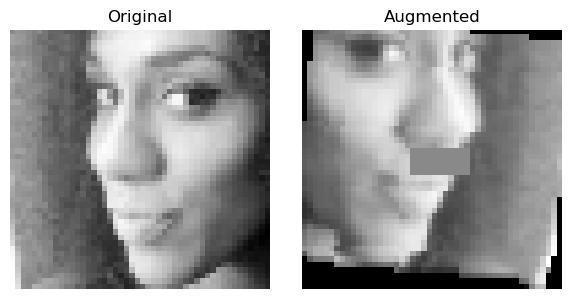

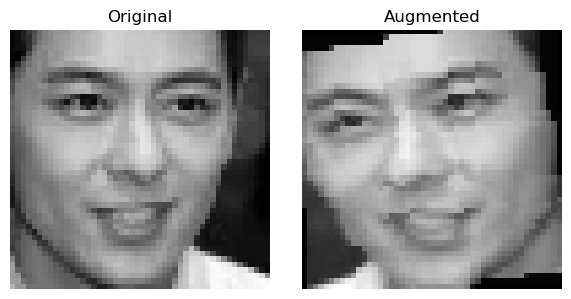

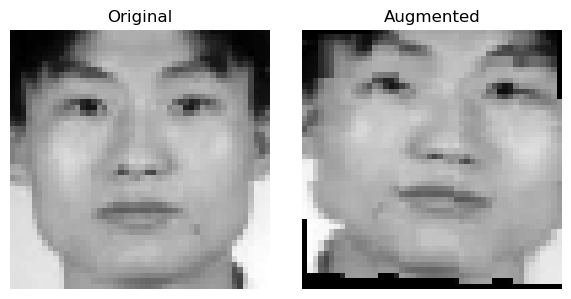

In [38]:
compare_images(3)

# Model 1: Multitask Classification

Now we can move on to the first model: a multitask classification model based on a custom ResNet18 architecture to classify both gender and ethnicity.

## Model implementation

We implement a custom multitask "ResNet18", adapted for our 48×48 grayscale facial images, to simultaneously classify ethnicity and gender.

ResNet is a deep convolutional architecture based on residual blocks, which solve the vanishing gradient problem by introducing shortcut connections. This allows training much deeper networks effectively.

Our version modifies the standard ResNet18 in several key ways:

- input adapted to 1 channel (grayscale instead of RGB);

- removed initial max-pooling to retain more spatial detail;

- adapted convolution kernels for small 48×48 images;

- added LayerNorm + Dropout to improve generalization; dropout acts on the shared 512-dimensional feature vector before it is sent to the task-specific heads. It helps prevent the backbone from overfitting the training data and encourages more robust shared representations for both tasks.

- introduced two task-specific heads for multitask learning;

- optimized residual blocks for our feature map sizes.

In [39]:
# ---------- Residual Block ----------
class Residual(nn.Module):
    def __init__(self, in_channels, out_channels, use_1x1conv=False, strides=1):
        super().__init__()

        # First 3×3 convolution: feature extraction.
        self.conv1 = nn.Conv2d(in_channels, out_channels,
                               kernel_size=3, stride=strides,
                               padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_channels)
 
        # Second convolution refines features.
        self.conv2 = nn.Conv2d(out_channels, out_channels,
                               kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_channels)

        # 1x1 convolutional: used when changing number of channels and changing stride to ensure dimensions match before the addition.
        self.conv3 = nn.Conv2d(in_channels, out_channels,
                               kernel_size=1, stride=strides) if use_1x1conv else None

    # Applies two conv+BN layers. Adds the shortcut connection. Applies ReLU. This creates the residual behavior.
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3 is not None:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

# ---------- Weight initialization ----------
def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# ---------- CNN MultiTask for 48x48 ----------
class CNN_MultiTask(nn.Module):
    def __init__(self, num_ethnicity=5, num_gender=2, dropout = 0.4):
        super().__init__()

        # Conv1 adatped for 48x48 images
        self.conv1 = nn.Conv2d(
            1, 64,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # No maxpool!
        
        # ResNet layers
        self.layer1 = self._make_layer(64,  64,  2, stride=1)  # 48×48
        self.layer2 = self._make_layer(64,  128, 2, stride=2)  # 24×24
        self.layer3 = self._make_layer(128, 256, 2, stride=2)  # 12×12
        self.layer4 = self._make_layer(256, 512, 2, stride=2)  # 6×6

        # This reduces each feature map to 512 features and stabilizes training.
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

        self.norm = nn.LayerNorm(512)
        self.dropout = nn.Dropout(dropout)

        # Multitask heads:
        # Ethnicity head
        self.fc_eth = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.25), # stronger regularization since ethnicity is more complex than gender
            nn.Linear(256, num_ethnicity)
        )
        # Gender head (smaller than ethnicity head)
        self.fc_gen = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.10), # milder dropout to avoid overfitting
            nn.Linear(128, num_gender)
        )

        self.apply(initialize_weights)

    def _make_layer(self, in_ch, out_ch, blocks, stride):
        layers = [Residual(in_ch, out_ch, use_1x1conv=True, strides=stride)]
        for _ in range(1, blocks):
            layers.append(Residual(out_ch, out_ch))
        return nn.Sequential(*layers)

    # The forward() method defines how input images flow through the network, layer by layer, until producing the final ethnicity and gender predictions.
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x))) # extracts low-level features such as edges and textures from the 48×48 grayscale input. bn1: stabilizes activations, 
        # accelerates training, and helps generalization.
        # ReLU: introduces nonlinearity so the network can learn nonlinear decision boundaries.

        # Residual layers: each layer contains 2 residual blocks.
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x) # AdaptiveAvgPool2d((1,1)) converts the 6×6×512 feature map into a 1×1×512 vector by averaging each channel.
        x = torch.flatten(x, 1) # Flattening the tensor

        # Normalization and dropout
        x = self.norm(x)
        x = self.dropout(x)

        gen = self.fc_gen(x)
        eth = self.fc_eth(x)

        return eth, gen # 2 outputs 


# test
model = CNN_MultiTask()
print(model(torch.randn(4,1,48,48))[0].shape)  # ethnicity
print(model(torch.randn(4,1,48,48))[1].shape)  # gender


torch.Size([4, 5])
torch.Size([4, 2])


Neural networks that use ReLU activations require a special initialization strategy to ensure stable training.
ReLU is defined as:

$$
\mathrm{ReLU}(x) = \max(0, x)
$$

Since ReLU sets all negative inputs to zero, on average half of the signal is lost at each layer. This affects the variance of activations and can lead to: vanishing activations (too small) or exploding activations (too large).

To prevent this, Kaiming (He) Initialization sets the weights so that the variance of activations remains stable across layers. For a layer with fan_in input connections, the recommended variance is:

$$
\mathrm{Var}(w) = \frac{2}{\text{fan\_in}}
$$

The fan in is the number of input connections to a neuron or filter.
For a fully connected layer: fan_in = number of input features.
For a convolutional layer: fan_in = in_channels x kernel_height × kernel_width.

This leads to the weight distribution:

$$
w \sim \mathcal{N}\left(0,\, \sqrt{\frac{2}{\text{fan\_in}}}\right)
$$

Kaiming initialization is especially important in ResNet architectures, which rely on residual connections:

$$
y = F(x) + x
$$


Here, F(x) is the residual function learned by the network.
For residual learning to work effectively, both branches (the residual path and the identity shortcut) must produce activations with compatible scales.
If weights are poorly initialized, the residual signal F(x) may explode or vanish, making it difficult for the network to learn meaningful corrections to the identity mapping.

By preserving stable variance even in deep ReLU networks, Kaiming initialization ensures that residual blocks start in a well-balanced regime, allowing the model to train efficiently and converge faster.

## Model training


We train the multitask classification model using a carefully designed training loop that includes weighted losses, label smoothing, learning-rate warmup, cosine annealing, and patience-based early stopping.

We begin by moving the model to the selected device and creating an **AdamW optimizer**. AdamW is widely used in modern deep learning because it decouples weight decay from the gradient update rule. 
**Weight decay** is a type of regularization that penalizes large weights. It reduces overfitting and improves generalization.
It works by adding a penalty to the loss:

$$
L_{\text{total}} = L_{\text{task}} + \lambda \|w\|^2.
$$
Where: λ = weight decay coefficient and $||w||^2$ = L2 norm of the weights.
This encourages the optimizer to keep weights small and smooth. It prevents weights from growing excessively, reduces model complexity, improves generalization on unseen data, stabilizes optimization when using AdamW.

The **loss function** is defined as the weighetd sum of the cross entropy for gender and the cross entropy for ethnicity: 
$$ 
L = w_{gen} L_{gen} + w_{eth} L_{eth} 
$$ 

where:
$$
L_{\text{gen}} = -\log(\hat{p}_y)
$$

$$
L_{\text{eth}} = - \sum_{k=1}^{5} y_k \log(\hat{p}_k)
$$ 
while $ w_{gen}$ and $w_{eth} $ are the weights assigned to each loss function.

Learning rate determines how fast the model learns. Weight decay determines how smooth and stable the learned weights are.
Together, they control: the quality of convergence, the stability of training, the ability to generalize and the resistance to overfitting.

A custom **learning-rate scheduler** is implemented using two phases: a warmup stage that gradually increases the learning rate during the first epochs, and a cosine annealing phase that smoothly decays it afterwards.
Learning rate controls how big the parameter updates are during each optimization step. At each training step, the optimizer updates the model weights according to:
$$
\theta_{\text{t}} = \theta_{\text{t-1}} - \eta \cdot \nabla_{\theta} L
$$
Where: θ = model parameters, η = learning rate, ∇(L) = gradient of the loss.

If learning rate is too high: updates are too large, loss oscillates or diverges and training becomes unstable.
If learning rate is too low: training becomes extremely slow, model might get stuck in bad local minima, may never reach good performance.

A fixed learning rate rarely works well for deep CNNs.
This is why we combine learning rate with warmup (to stabilizes early training) and **cosine annealing** (to obtain smooth convergence and better generalization).
Together, they allow the model to learn quickly at the beginning and refine weights slowly and carefully at the end.

**Warmup** is a technique where the learning rate starts very small and increases gradually during the first few training epochs. At the beginning of training: model weights are randomly initialized, gradients can be large or unstable, large learning rates may destabilize training. Warmup prevents this by slowly ramping up the learning rate from near-zero to its target value. This gives the model time to stabilize before full-speed training begins. After warmup, the learning rate follows a cosine decay curve:
$$
\eta_t = \eta_{\min}^i 
+ \frac{1}{2}\big(\eta_{\max}^i - \eta_{\min}^i\big)
\big(1 + \cos(\pi \, T_{\text{cur}} / T_i)\big)
$$


where: η = learning rate at step t, $η_{min}$ = last learning rate (minimum), $η_{max}$ = first learning rate (maximum), $T_i$ = total training duration after warmup, $T_{cur}$ = current step within the cycle.
It gradually reduces the learning rate from its peak value to near zero following the shape of a cosine wave.

For gender classification we use standard cross-entropy, while ethnicity classification uses both **label smoothing** and class weights to compensate for the strong imbalance in the dataset. The total loss is a weighted sum of the two tasks, giving higher importance to ethnicity (the more difficult task).
Label smoothing replaces strict one-hot targets with slightly softened labels, reducing overconfidence and improving generalization: 
$$
y_{\text{smooth}} = (1 - \varepsilon)\, y_{\text{one-hot}} + \frac{\varepsilon}{K},
$$
where ε is the smoothing factor and K the number of classes. This technique is especially useful when classes are imbalanced or visually hard to separate.
Using label smoothing the loss function can be written as following:

$$
q_k =
\begin{cases}
1 - \varepsilon & \text{if } k = y \\
\frac{\varepsilon}{5} & \text{if } k \neq y
\end{cases}
$$

$$
L_{\text{eth}} = -\sum_{k=1}^{5} q_k \log(\hat{p}_k)
$$
$$
L_{\text{gen}} = -\sum_{k=0}^{1} q_k \log(\hat{p}_k)
$$

During each training epoch, we iterate over all batches, perform a forward pass, compute both task losses, combine them, and backpropagate. Predictions are collected to compute epoch-level metrics such as accuracy and macro-F1, which is especially important for imbalanced classes.

Validation is performed in eval() mode under torch.no_grad(), computing the same metrics without updating the weights. We track the best model based on a combined score of ethnicity and gender macro-F1. When the validation score does not improve for a fixed number of epochs (patience), **early stopping** is triggered to prevent overfitting. The best model weights are saved to disk.

All training and validation metrics (loss, accuracy, and F1 for both tasks) are stored and exported, allowing us to visualize the learning curves after training.

This training pipeline ensures stable optimization, good generalization, and robustness to class imbalance, allowing the multitask model to learn both tasks effectively.



In [33]:
def train_multitask(
    model,
    train_loader,
    val_loader,
    num_epochs=30,
    device=device,
    label_smoothing_gen=0.0,
    label_smoothing_eth=0.10,
    class_weights_eth=None,
    w_gen=0.5,
    w_eth=1.5,
    lr=1e-3,
    weight_decay=1e-4,
    warmup_epochs=3,
    use_cosine=True,
    patience=5,
    ckpt_path="best_resnet18_multitask.pt"
):


    print(f"Training on {device}")
    model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Learning rate
    def lr_lambda(epoch):
        # Warmup
        if warmup_epochs > 0 and epoch < warmup_epochs:
            return float(epoch + 1) / float(max(1, warmup_epochs))
        if use_cosine:
            t = epoch - warmup_epochs
            T = max(1, num_epochs - warmup_epochs)
            return 0.5 * (1 + math.cos(math.pi * t / T)) # After warmup, the learning rate follows a cosine decay, gradually reducing toward zero.
        return 1.0

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda) # The scheduler applies the learning rate adjustment at each epoch.

    # Loss function with label smoothing
    def ce_gen(logits, target):
        return F.cross_entropy(logits, target, label_smoothing=label_smoothing_gen)

    def ce_eth(logits, target):
        return F.cross_entropy(logits, target,
                               label_smoothing=label_smoothing_eth,
                               weight=class_weights_eth)

    # Lists are initialized to store losses, accuracies, and macro-F1 scores for both tasks:
    tr_loss, va_loss = [], []
    tr_eth_acc, va_eth_acc = [], []
    tr_gen_acc, va_gen_acc = [], []
    tr_eth_f1,  va_eth_f1  = [], []
    tr_gen_f1,  va_gen_f1  = [], []

    best_score = -1 # tracks the best validation performance so far.
    wait = 0 # counts how many epochs have passed without improvement.

    # Training loop
    for epoch in range(num_epochs):

        #  TRAIN 
        model.train()
        running_loss = 0.0
        g_preds, g_true = [], []
        e_preds, e_true = [], []

        # Batch iteration
        for x, y_eth, y_gen in train_loader:

            x, y_eth, y_gen = x.to(device), y_eth.to(device), y_gen.to(device)
            optimizer.zero_grad(set_to_none=True)

            
            pred_eth, pred_gen = model(x) # The model outputs logits for both tasks:

            # Compute multitask loss
            loss_g = ce_gen(pred_gen, y_gen)
            loss_e = ce_eth(pred_eth, y_eth)
            loss = w_gen * loss_g + w_eth * loss_e

            # Backpropagation
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * x.size(0)

            # Accumulate training predictions and labels
            g_preds.append(pred_gen.argmax(1).cpu())
            g_true.append(y_gen.cpu())
            e_preds.append(pred_eth.argmax(1).cpu())
            e_true.append(y_eth.cpu())

        g_preds = torch.cat(g_preds).numpy()
        g_true  = torch.cat(g_true).numpy()
        e_preds = torch.cat(e_preds).numpy()
        e_true  = torch.cat(e_true).numpy()

        # Compute training metrics
        train_loss = running_loss / len(g_true)
        train_gen_acc = accuracy_score(g_true, g_preds)
        train_eth_acc = accuracy_score(e_true, e_preds)
        train_gen_f1  = f1_score(g_true, g_preds, average="macro")
        train_eth_f1  = f1_score(e_true, e_preds, average="macro")

        tr_loss.append(train_loss)
        tr_gen_acc.append(train_gen_acc); tr_eth_acc.append(train_eth_acc)
        tr_gen_f1.append(train_gen_f1);   tr_eth_f1.append(train_eth_f1)

        #  VALIDATION 
        model.eval()
        running_loss = 0.0
        g_preds, g_true = [], []
        e_preds, e_true = [], []

        with torch.no_grad():
            for x, y_eth, y_gen in val_loader:
                x, y_eth, y_gen = x.to(device), y_eth.to(device), y_gen.to(device)

                pred_eth, pred_gen = model(x)

                loss_g = ce_gen(pred_gen, y_gen)
                loss_e = ce_eth(pred_eth, y_eth)
                loss   = w_gen * loss_g + w_eth * loss_e

                running_loss += loss.item() * x.size(0)

                g_preds.append(pred_gen.argmax(1).cpu()); g_true.append(y_gen.cpu())
                e_preds.append(pred_eth.argmax(1).cpu()); e_true.append(y_eth.cpu())

        g_preds = torch.cat(g_preds).numpy(); g_true = torch.cat(g_true).numpy()
        e_preds = torch.cat(e_preds).numpy(); e_true = torch.cat(e_true).numpy()

        val_loss = running_loss / len(g_true)
        val_gen_acc = accuracy_score(g_true, g_preds)
        val_eth_acc = accuracy_score(e_true, e_preds)
        val_gen_f1  = f1_score(g_true, g_preds, average="macro")
        val_eth_f1  = f1_score(e_true, e_preds, average="macro")

        va_loss.append(val_loss)
        va_gen_acc.append(val_gen_acc); va_eth_acc.append(val_eth_acc)
        va_gen_f1.append(val_gen_f1);   va_eth_f1.append(val_eth_f1)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
              f"Eth Acc: {train_eth_acc:.3f}/{val_eth_acc:.3f} | "
              f"Gen Acc: {train_gen_acc:.3f}/{val_gen_acc:.3f}")

        # Early stopping and checkpointing: If the model improves: save checkpoint and reset waiting counter, if validation stagnates for too long, stop training.
        score = 0.5 * (val_gen_f1 + val_eth_f1)
        if score > best_score:
            best_score = score
            wait = 0
            torch.save(model.state_dict(), ckpt_path)
            print(">> Best model updated!")
        else:
            wait += 1
            if wait >= patience:
                print("\nEARLY STOPPING triggered!")
                break

        scheduler.step() # Update the learning rate

    # Save all metrics
    np.savez(
        "metrics_multitask.npz",
        train_loss=np.array(tr_loss),
        val_loss=np.array(va_loss),
        train_eth_acc=np.array(tr_eth_acc),
        val_eth_acc=np.array(va_eth_acc),
        train_gen_acc=np.array(tr_gen_acc),
        val_gen_acc=np.array(va_gen_acc),
        train_eth_f1=np.array(tr_eth_f1),
        val_eth_f1=np.array(va_eth_f1),
        train_gen_f1=np.array(tr_gen_f1),
        val_gen_f1=np.array(va_gen_f1),
    )

    return {
        "train_loss": tr_loss, "val_loss": va_loss,
        "train_eth_acc": tr_eth_acc, "val_eth_acc": va_eth_acc,
        "train_gen_acc": tr_gen_acc, "val_gen_acc": va_gen_acc,
        "train_eth_f1": tr_eth_f1,   "val_eth_f1": va_eth_f1,
    }


For the final training configuration, we increased model regularization and adjusted the loss balance and optimization strategy to better handle the difficulty and imbalance of the ethnicity task, as shown in the following code.

- A moderately strong **dropout** helps reduce overfitting on the shared feature space, especially given the small input size (48×48) and the model’s capacity.  
- **Label smoothing ($ε_{eth}$ = 0.12)**: slightly higher smoothing stabilizes ethnicity predictions and reduces overconfidence on imbalanced classes, while gender remains unsmoothed given its simplicity.  
- **Learning rate = 6e−4**: a slightly lower learning rate than the default improves stability with strong regularization and multitask loss balancing.   
- **Weight decay = 1e−3**: a stronger L2 penalty helps prevent overfitting in both the backbone and the heads.   
- **Patience = 8** allows the model enough time to recover from plateaus due to the stronger regularization and lower LR schedule, but still avoids unnecessary training.

Overall, these hyperparameters were selected, after testing multiple configurations and evaluating their results, to strengthen regularization, handle class imbalance, and prioritize ethnicity classification, while ensuring stable and smooth convergence through warmup and cosine annealing.

### Training launch and results

In [34]:
# Training launch 
model = CNN_MultiTask(num_ethnicity=5, num_gender=2, dropout=0.35)

metrics = train_multitask(
    model,
    train_loader,
    val_loader,
    num_epochs=50,
    device=device,
    label_smoothing_gen=0.0,
    label_smoothing_eth=0.12,
    class_weights_eth=class_weights_eth,   
    w_gen=0.4, w_eth=2.5,
    lr=6e-4, weight_decay=1e-3,
    warmup_epochs=5, use_cosine=True,
    patience=8,
    ckpt_path="best_resnet18_multitask.pt"
)


Training on mps
Epoch 1/50 | Train Loss: 4.1153 | Val Loss: 4.4137 | Eth Acc: 0.291/0.177 | Gen Acc: 0.591/0.666
>> Best model updated!
Epoch 2/50 | Train Loss: 3.5488 | Val Loss: 4.3317 | Eth Acc: 0.366/0.311 | Gen Acc: 0.648/0.699
>> Best model updated!
Epoch 3/50 | Train Loss: 3.2196 | Val Loss: 3.9734 | Eth Acc: 0.468/0.306 | Gen Acc: 0.712/0.697
>> Best model updated!
Epoch 4/50 | Train Loss: 3.0021 | Val Loss: 4.2449 | Eth Acc: 0.531/0.379 | Gen Acc: 0.765/0.711
>> Best model updated!
Epoch 5/50 | Train Loss: 2.8556 | Val Loss: 3.4446 | Eth Acc: 0.583/0.480 | Gen Acc: 0.795/0.785
>> Best model updated!
Epoch 6/50 | Train Loss: 2.7248 | Val Loss: 3.7002 | Eth Acc: 0.620/0.468 | Gen Acc: 0.806/0.792
Epoch 7/50 | Train Loss: 2.6310 | Val Loss: 3.5815 | Eth Acc: 0.646/0.468 | Gen Acc: 0.824/0.847
>> Best model updated!
Epoch 8/50 | Train Loss: 2.5651 | Val Loss: 3.3912 | Eth Acc: 0.661/0.598 | Gen Acc: 0.827/0.854
>> Best model updated!
Epoch 9/50 | Train Loss: 2.4887 | Val Loss: 3.1

In [35]:
def plot_training_metrics(metrics):

    plt.close('all')

    epochs = range(1, len(metrics["train_loss"]) + 1)

    fig = plt.figure(figsize=(14, 10))

    
    # 1. LOSS
    ax1 = fig.add_subplot(3, 1, 1)
    ax1.plot(epochs, metrics["train_loss"], label="Train Loss")
    ax1.plot(epochs, metrics["val_loss"], label="Val Loss")
    ax1.set_title("Training & Validation Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax1.grid(True)

    # 2. ETHNICITY ACCURACY
    ax2 = fig.add_subplot(3, 1, 2)
    ax2.plot(epochs, metrics["train_eth_acc"], label="Train Ethnicity Acc")
    ax2.plot(epochs, metrics["val_eth_acc"], label="Val Ethnicity Acc")
    ax2.set_title("Ethnicity Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.legend()
    ax2.grid(True)

    # 3. GENDER ACCURACY
    ax3 = fig.add_subplot(3, 1, 3)
    ax3.plot(epochs, metrics["train_gen_acc"], label="Train Gender Acc")
    ax3.plot(epochs, metrics["val_gen_acc"], label="Val Gender Acc")
    ax3.set_title("Gender Accuracy")
    ax3.set_xlabel("Epoch")
    ax3.set_ylabel("Accuracy")
    ax3.legend()       
    ax3.grid(True)

    plt.tight_layout()
    plt.show()

These plots show the training and validation loss, as well as the training and validation accuracy for both gender and ethnicity.

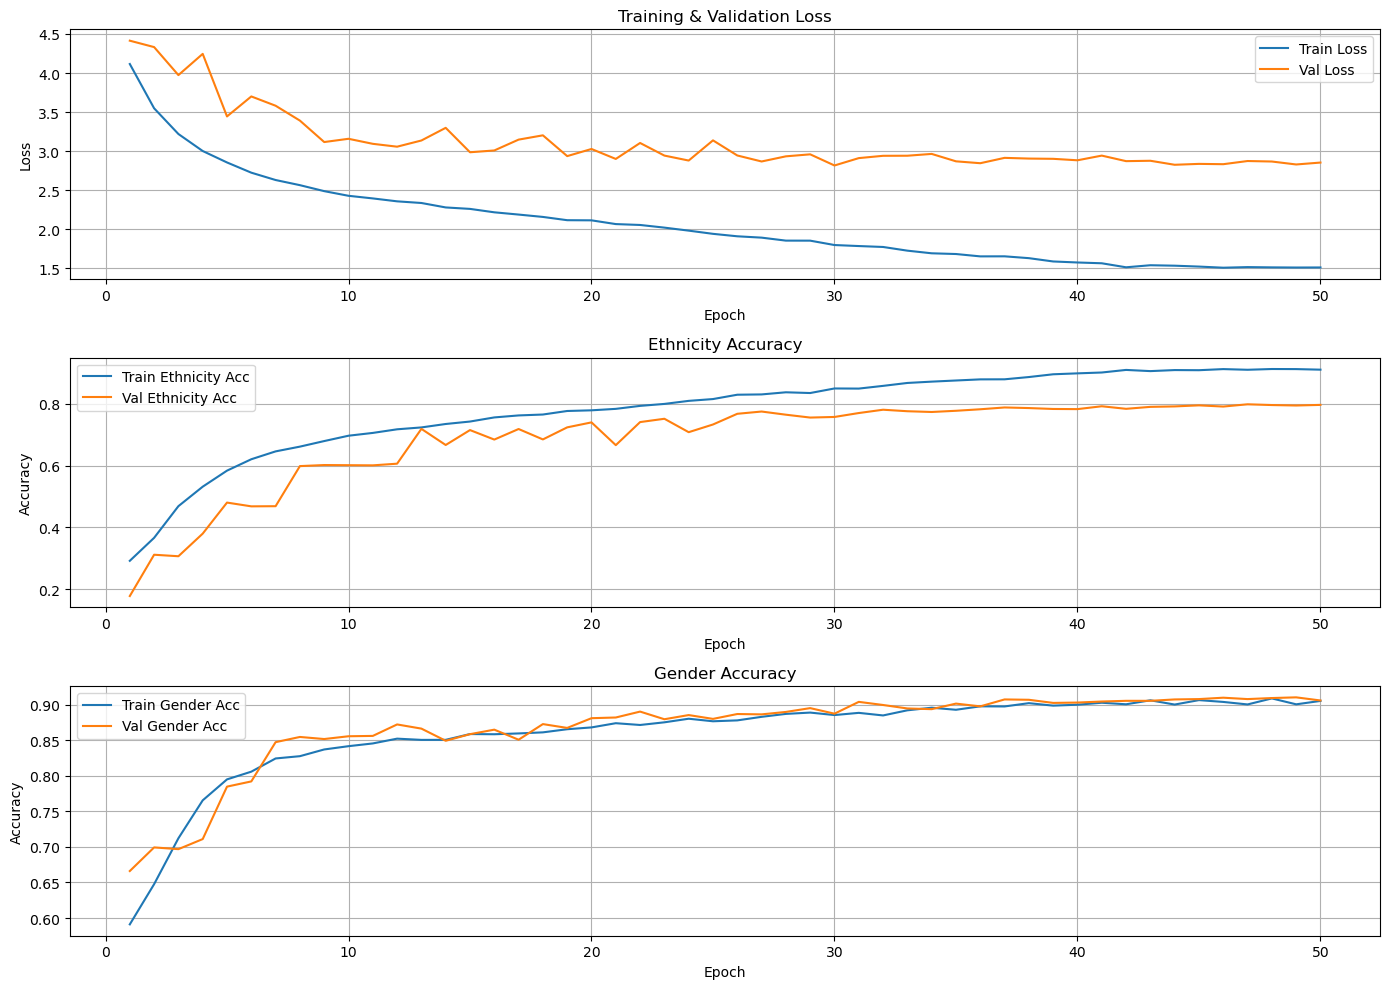

In [36]:
plot_training_metrics(metrics)

The multitask model demonstrates stable and effective learning dynamics across the training process. Both the training and validation losses exhibit a clear downward trend, with the validation curve showing moderate oscillations that are typical in multitask optimization. Despite this variability, the absence of systematic divergence between the curves indicates that the model does not suffer from strong overfitting and continues to generalize well throughout training.

Regarding ethnicity classification, performance improves substantially from the initial epochs and reaches approximately 0.80 accuracy on the validation set. Although the learning curve displays early fluctuations (likely due to the higher complexity and class imbalance associated with this task) the model ultimately converges to a stable and competitive level of accuracy. The close alignment between training and validation performance further confirms good generalization.

Gender classification exhibits even stronger results, with the model achieving around 0.90 validation accuracy. The learning curve increases smoothly and stabilizes with minimal noise, suggesting that gender is a comparatively easier attribute to learn and that the underlying features are well captured by the shared representation. The near overlap of training and validation curves demonstrates excellent generalization and robustness.

## Test evaluation

In this section, we conduct a comprehensive evaluation of the multitask model to assess its performance, robustness, and potential biases. Beyond reporting global metrics, we adopt a multi-level analysis designed to better understand how the model behaves across different demographic groups and error scenarios.

First, we compute the confusion matrices for both gender and ethnicity, which provide a detailed view of class-specific performance and highlight systematic misclassification patterns. We complement these results with class-level metrics such as per-class accuracy and F1-scores to examine potential biases and disparities across demographic categories.

Next, we perform qualitative testing by evaluating the model on test and individual images, allowing us to visually inspect predictions and identify cases where the model performs particularly well or fails. To further interpret the model’s decision process, we apply Grad-CAM to visualize which regions of the face the model focuses on when predicting gender and ethnicity.

Finally, we conduct an error clustering analysis by extracting deep embeddings from misclassified samples and applying unsupervised clustering. This reveals whether certain groups of errors share common visual patterns, helping us understand failure modes and diagnose underlying model limitations.

Together, these analyses provide both quantitative and qualitative insight into the strengths and weaknesses of the model, forming a complete picture of its real-world behavior.

### Confusion matrices

In [35]:
# The plot_cm function provides a clean and interpretable visualization of a confusion matrix.
def plot_cm(cm, class_names, title):
    plt.figure(figsize=(4.8, 4.2))
    plt.imshow(cm, cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")

    plt.xticks(np.arange(len(class_names)), class_names, rotation=45, ha="right")
    plt.yticks(np.arange(len(class_names)), class_names)

    # numbers inside squares
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j],
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()


# This function evaluates the multitask model on the test set while computing and plotting confusion matrices.
def evaluate_multitask_with_cm(
    model, test_loader, device,
    gender_labels=("Male", "Female"),
    eth_labels=("0","1","2","3","4")
):

    model.eval()

    all_gen_true, all_gen_pred = [], []
    all_eth_true, all_eth_pred = [], []

    with torch.no_grad():
        for X, y_eth, y_gen in test_loader:
            X = X.to(device)
            y_eth = y_eth.to(device)
            y_gen = y_gen.to(device)

            # A forward pass returns two output tensors:
            o1, o2 = model(X)
            # the code dynamically identifies which tensor corresponds to gender and which to ethnicity by inspecting the number of classes (gender = 2, ethnicity = 5). 
            # This makes the function robust to architectural variations.

            # Detect which head is which
            if o1.shape[1] == 2:
                logits_gen, logits_eth = o1, o2
            else:
                logits_gen, logits_eth = o2, o1

            pred_gen = logits_gen.argmax(1)
            pred_eth = logits_eth.argmax(1)

            all_gen_true.append(y_gen.cpu())
            all_gen_pred.append(pred_gen.cpu())
            all_eth_true.append(y_eth.cpu())
            all_eth_pred.append(pred_eth.cpu())

    # concatenate
    all_gen_true = torch.cat(all_gen_true).numpy()
    all_gen_pred = torch.cat(all_gen_pred).numpy()
    all_eth_true = torch.cat(all_eth_true).numpy()
    all_eth_pred = torch.cat(all_eth_pred).numpy()

    # metrics
    gen_acc = accuracy_score(all_gen_true, all_gen_pred)
    gen_f1  = f1_score(all_gen_true, all_gen_pred, average="macro")
    eth_acc = accuracy_score(all_eth_true, all_eth_pred)
    eth_f1  = f1_score(all_eth_true, all_eth_pred, average="macro")

    cm_gen = confusion_matrix(all_gen_true, all_gen_pred, labels=[0,1])
    cm_eth = confusion_matrix(all_eth_true, all_eth_pred, labels=[0,1,2,3,4])

    print("\nTEST RESULTS: ")
    print(f"Gender:      Acc: {gen_acc:.3f},  Macro-F1: {gen_f1:.3f}")
    print(f"Ethnicity:   Acc: {eth_acc:.3f},  Macro-F1: {eth_f1:.3f}")
    
    print("\nConfusion Matrix — Gender")
    plot_cm(cm_gen, gender_labels, "Gender")

    print("\nConfusion Matrix — Ethnicity")
    plot_cm(cm_eth, eth_labels, "Ethnicity")

    return {
        "gen_true": all_gen_true,
        "gen_pred": all_gen_pred,
        "eth_true": all_eth_true,
        "eth_pred": all_eth_pred,
        "gen_acc": gen_acc,
        "gen_f1": gen_f1,
        "eth_acc": eth_acc,
        "eth_f1": eth_f1,
        "cm_gen": cm_gen,
        "cm_eth": cm_eth,
    }



TEST RESULTS: 
Gender:      Acc: 0.917,  Macro-F1: 0.917
Ethnicity:   Acc: 0.788,  Macro-F1: 0.723

Confusion Matrix — Gender


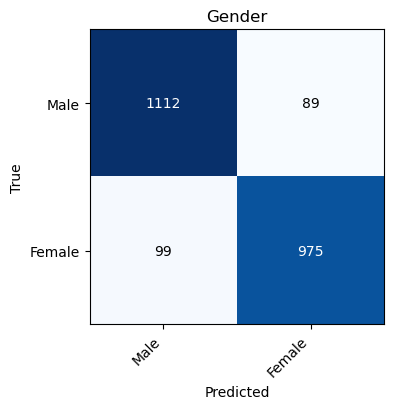


Confusion Matrix — Ethnicity


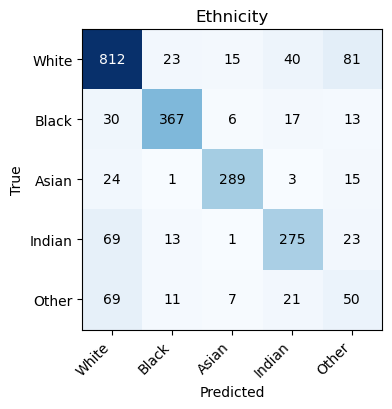

In [36]:
model.load_state_dict(torch.load("best_resnet18_multitask.pt", map_location=device))
model.to(device)

results = evaluate_multitask_with_cm(
    model,
    test_loader,
    device,
    gender_labels=("Male", "Female"),
    eth_labels=("White", "Black", "Asian", "Indian", "Other")
)


The model shows excellent performance on gender classification, achieving 91.7% accuracy and a macro-F1 of 0.917.
The confusion matrix confirms this: both classes exhibit balanced performance, with misclassifications being relatively rare (about 8–9% for both males and females). This indicates that the model has learned robust and symmetric decision boundaries without showing noticeable gender bias.

Ethnicity classification is more challenging, as reflected in a lower accuracy (79%) and macro-F1 (0.723).
The confusion matrix reveals a clear pattern: the model performs strongly on the most represented classes (especially White, Black, and Asian), which show high true-positive counts.
Performance drops substantially on less frequent or visually heterogeneous classes such as Indian and Other, where confusion with the majority classes is more common.
Misclassifications are generally asymmetric, suggesting that underrepresented groups are disproportionately mapped to more common categories.
This is expected because the Other category is a highly heterogeneous group containing individuals from Latin America, North Africa, the Middle East, and mixed ethnic backgrounds.
Such internal diversity makes it difficult for the model to learn a coherent feature space, inevitably leading to a larger number of misclassification errors for this class.

### Other metrics

In [37]:
def compute_all_metrics(y_true, y_pred, class_labels):
    # Converts lists into NumPy arrays for faster and more stable computations
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_labels)))

    # Metrics for each class 
    precision = precision_score(y_true, y_pred, labels=np.arange(len(class_labels)),
                                average=None, zero_division=0)
    recall = recall_score(y_true, y_pred, labels=np.arange(len(class_labels)),
                          average=None, zero_division=0)
    f1 = f1_score(y_true, y_pred, labels=np.arange(len(class_labels)),
                  average=None, zero_division=0) # zero_division=0 prevents errors when a class has no predicted samples.

    # Specificity (Sklearn does not provide specificity, so it is computed manually)
    specificity = []
    for c in range(len(class_labels)):
        tn = np.sum(cm) - (np.sum(cm[c, :]) + np.sum(cm[:, c]) - cm[c, c])
        fp = np.sum(cm[:, c]) - cm[c, c]
        specificity.append(tn / (tn + fp) if (tn + fp) > 0 else 0.0)
    specificity = np.array(specificity)

    # Overall metrics 
    accuracy = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    weighted_f1 = f1_score(y_true, y_pred, average="weighted")
    macro_recall = recall_score(y_true, y_pred, average="macro")
    macro_precision = precision_score(y_true, y_pred, average="macro")
    bal_acc = balanced_accuracy_score(y_true, y_pred)

    # NIR = accuracy predicting always the most frequent class
    values, counts = np.unique(y_true, return_counts=True)
    NIR = counts.max() / len(y_true)

    # Table 
    table = []
    for i, label in enumerate(class_labels):
        table.append({
            "Class": label,
            "Precision": precision[i],
            "Recall (Sensitivity)": recall[i],
            "Specificity": specificity[i],
            "F1": f1[i]
        })

    results = {
        "confusion_matrix": cm,
        "class_table": table,
        "accuracy": accuracy,
        "macro_f1": macro_f1,
        "weighted_f1": weighted_f1,
        "macro_precision": macro_precision,
        "macro_recall": macro_recall,
        "balanced_accuracy": bal_acc,
        "NIR": NIR
    }

    return results

def print_class_table(metrics):
    df = pd.DataFrame(metrics["class_table"])
    print(df.to_string(index=False))


In [38]:
metrics_eth = compute_all_metrics(
    results["eth_true"],
    results["eth_pred"],
    class_labels=["White","Black","Asian","Indian","Other"]
)

print("\nETHNICITY — OVERALL METRICS")
for k, v in metrics_eth.items():         
    if not isinstance(v, (list, dict, np.ndarray)):
        print(f"{k}: {v}")

print("\nETHNICITY — PER-CLASS METRICS")
print_class_table(metrics_eth)           


ETHNICITY — OVERALL METRICS
accuracy: 0.7881318681318681
macro_f1: 0.7234923183509036
weighted_f1: 0.7908773895524301
macro_precision: 0.7298209011841619
macro_recall: 0.718509749177126
balanced_accuracy: 0.718509749177126
NIR: 0.4268131868131868

ETHNICITY — PER-CLASS METRICS
 Class  Precision  Recall (Sensitivity)  Specificity       F1
 White   0.808765              0.836251     0.852761 0.822278
 Black   0.884337              0.847575     0.973941 0.865566
 Asian   0.908805              0.870482     0.985075 0.889231
Indian   0.772472              0.721785     0.957233 0.746269
 Other   0.274725              0.316456     0.937648 0.294118


In [45]:
gen_metrics = compute_all_metrics(
    results["gen_true"],
    results["gen_pred"],
    class_labels=["Male", "Female"]
)

print("\nGENDER — OVERALL METRICS")
for k, v in gen_metrics.items():
    if not isinstance(v, (list, dict, np.ndarray)):
        print(f"{k}: {v}")

print("\nGENDER — PER-CLASS METRICS")
print_class_table(gen_metrics)


GENDER — OVERALL METRICS
accuracy: 0.9173626373626373
macro_f1: 0.9170618687044975
weighted_f1: 0.9173406834459847
macro_precision: 0.9173013820678865
macro_recall: 0.9168581582387116
balanced_accuracy: 0.9168581582387116
NIR: 0.5279120879120879

GENDER — PER-CLASS METRICS
 Class  Precision  Recall (Sensitivity)  Specificity       F1
  Male   0.918249              0.925895     0.907821 0.922056
Female   0.916353              0.907821     0.925895 0.912067


- **Accuracy** is the proportion of correct predictions out of all samples. Accuracy gives a quick indication of performance, but it can be misleading when classes are imbalanced. It is computed as the ratio between the sum of true negative and true positives over all the samples.
- **Macro F1** is the unweighted average of F1-scores across all classes. It is useful beacause treats all classes equally, regardless of how frequent they are. Highlights poor performance on minority classes. So, Macro F1 is given by:  
    $$ \text{Macro-F1} = \frac{1}{K} \sum_{c=1}^{K} F1_c $$  
   where $F1_c$ is:
    $$F1_c = 2 \cdot \frac{\text{Precision}_c \cdot \text{Recall}_c}{\text{Precision}_c + \text{Recall}_c}$$
   with:
    $$\text{Precision}_c = \frac{TP_c}{TP_c + FP_c}$$
    $$\text{Recall}_c = \frac{TP_c}{TP_c + FN_c}$$
    If we have high values for precision we have few false positives while if we have low precision the model often mislabels other classes as this one. The recall instead give use the number of correctly identified elements out of all actual members in that class. High recall means that the model catches most samples of this class while low recall means that model often misses this class. F1 is just the armonic mean between precision and recall.

- **Weighted F1** is F1-scores for each class weighted by the number of samples in that class. It is very useful since reflects performance on the overall dataset.
- **Macro Precision** is the average precision across all classes, equally weighted. This tells how reliable the positive predictions are on average.
- **Macro Recall** is the average recall across classes. Measures the model’s ability to capture actual members of each class.
- **Balanced Accuracy** is the average recall across all classes, identical to macro recall for multi-class.
- **NIR (No Information Rate)** is the accuracy obtained by always predicting the most frequent class.

In multi-class classification, especially when classes are imbalanced, global metrics hide a lot of information. Per-class metrics reveal which groups the model performs well on and which ones it struggles with.
This is essential for fairness, interpretability, and improving the model.
We have already discussed about Precision, Recall and F1. Instead specificity is useful to understand how good is the model at not predicting class X when the sample is not from class X.
So, high specificity values means few false positives. It is very useful for evaluating class separability.

The model performs reasonably well on ethnicity classification, achieving 78.8% accuracy, balanced accuracy ≈ 0.72, and a macro-F1 of 0.72, all notably higher than the NIR (0.43). This means that even though the “Other” class is poorly learned due to its heterogeneity and low metrics such as recall, precision and F1, the model still captures meaningful structure across the five classes. Performance is solid for White, Black, and Asian, and acceptable for Indian, while “Other” remains the main source of errors.
In contrast, gender classification is very reliable, showing highly consistent behavior across both classes. Overall, ethnicity is the challenging task but still significantly better than chance, whereas gender is predicted with strong and stable performance.

In a multiclass setting the ROC curve is not naturally defined so we just look at the ROC curve for gender.
The ROC curve evaluates how well a binary classifier can separate two classes across all decision thresholds. It is useful because it is threshold-independent and robust to class imbalance.
The AUC summarizes this ability in a single number between 0.5 (random guess) and 1.0 (perfect classifier).

In [39]:
def plot_gender_roc_auc(model, test_loader, device):
    model.eval() # The model is set to evaluation mode and gradients are disabled for efficiency.

    all_true = []
    all_scores = []   # probabilities for class 1 (Female)

    with torch.no_grad(): # Disables gradient computation, making inference faster and memory-efficient.
        for X, y_eth, y_gen in test_loader:
            X = X.to(device)

            # Forward
            out1, out2 = model(X)

            # Automatically detects which head corresponds to gender, by checking which output has 2 units.
            if out1.shape[1] == 2:
                gender_logits = out1
            else:
                gender_logits = out2

            # Softmax to obtain probabilities 
            probs = torch.softmax(gender_logits, dim=1)[:, 1]  # prob(Female): applies softmax to convert logits into class probabilities.

            # Stores the true labels and the predicted probabilities for later concatenation.
            all_true.append(y_gen.cpu().numpy())
            all_scores.append(probs.cpu().numpy())

    # Combines all batches into two final arrays matching the entire test set.
    all_true = np.concatenate(all_true)
    all_scores = np.concatenate(all_scores)

    # ROC Curve 
    fpr, tpr, thresholds = roc_curve(all_true, all_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})", linewidth=2)
    plt.plot([0, 1], [0, 1], "k--", label="Random Classifier")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.title("ROC Curve — Gender")
    plt.legend()
    plt.grid(True)
    plt.show()

    return roc_auc

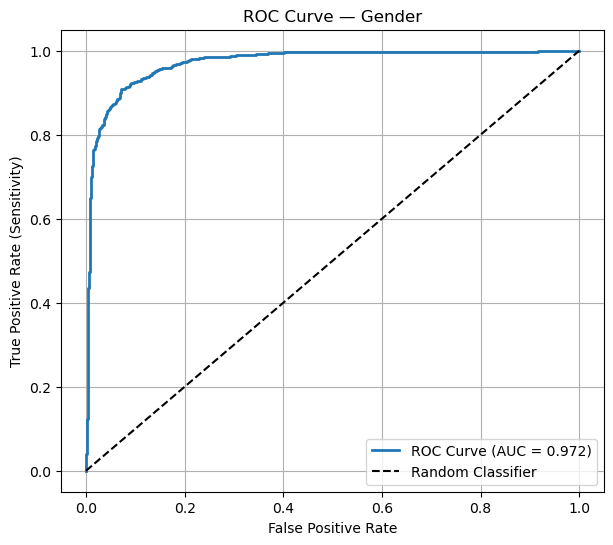

AUC Gender: 0.9722329467839493


In [40]:
auc_gender = plot_gender_roc_auc(model, test_loader, device)
print("AUC Gender:", auc_gender)

The ROC curve illustrates how the model’s sensitivity (TPR) changes as the decision threshold varies, while also showing how many negative samples are incorrectly classified as positive (FPR).
The blue curve is the model performance across all thresholds while the dashed line is the random classifier baseline.
Moreover, an AUC over 0.97 indicates excellent separability between male and female classes.

### Testing using images

Now, we selected some images from the test set to compare the predicted gender and ethnicity with the true labels, in order to visually inspect potential differences or misclassifications.

In [41]:
def show_test_grid(model, test_loader, device,
                   gen_labels, eth_labels,
                   rows=3, cols=4, figsize=(13, 9)):
    
    model.eval()
    
    x, y_eth_true, y_gen_true = next(iter(test_loader)) # Fetches a single batch from the test loader. This batch will be used to visualize predictions.
    x = x.to(device)

    with torch.no_grad():
        o1, o2 = model(x)

    # Automatic head identification
    if o1.shape[1] == 2:
        logits_gen, logits_eth = o1, o2
    else:
        logits_gen, logits_eth = o2, o1

    # Determines how many images to display in the grid, capped by both the batch size and the grid size.
    total = rows * cols
    n = min(total, x.shape[0])

    plt.figure(figsize=figsize)

    for i in range(n):
        img = x[i].cpu().squeeze().numpy() # Selects an image from the batch and converts it to a NumPy array for plotting.

        # Model predictions
        pg = logits_gen[i].argmax().item()
        pe = logits_eth[i].argmax().item()

        # Predicted probabilities
        probs_gen = torch.softmax(logits_gen[i], dim=0).cpu().numpy()
        probs_eth = torch.softmax(logits_eth[i], dim=0).cpu().numpy()

        # True labels
        tg = y_gen_true[i].item()
        te = y_eth_true[i].item()

        title = (
            f"Pred G: {gen_labels[pg]} ({probs_gen[pg]:.2f}) | True: {gen_labels[tg]}\n"
            f"Pred E: {eth_labels[pe]} ({probs_eth[pe]:.2f}) | True: {eth_labels[te]}"
        )

        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(img, cmap="gray")
        ax.axis("off")
        ax.set_title(title, fontsize=8)

    plt.tight_layout()
    plt.show()


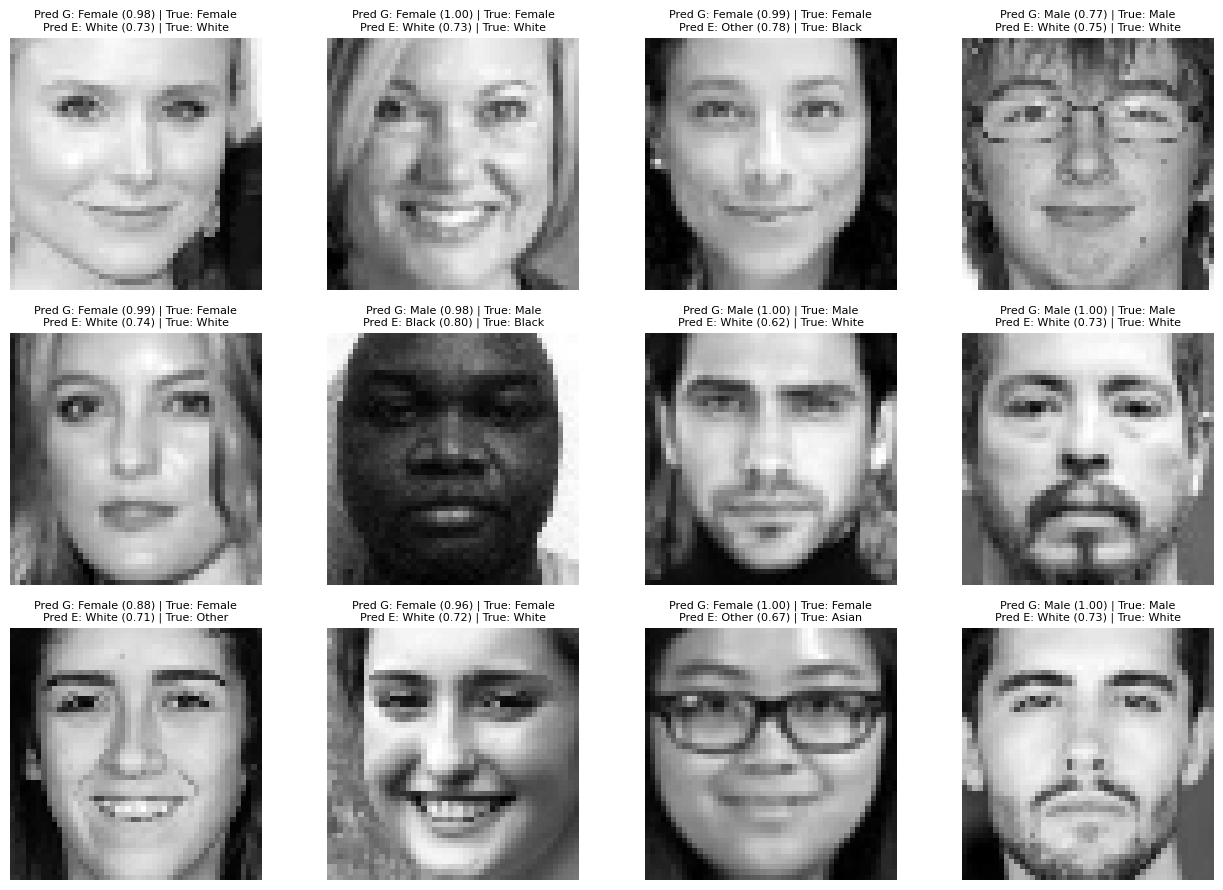

In [42]:
show_test_grid(
    model,
    test_loader,
    device,
    gen_labels=["Male", "Female"],
    eth_labels=["White", "Black", "Asian", "Indian", "Other"],
    rows=3,
    cols=4
)

These qualitative results confirm the quantitative metrics: gender predictions are consistently confident and correct, while ethnicity remains harder, with occasional confusions between visually similar groups (e.g., White and Other, Asian and Other, Black and Other). Errors appear linked to lighting, low resolution, pose, or ambiguous facial features, showing that the model struggles mainly in borderline or noisy cases.

### Testing the model on external images

We also evaluated the model on real photographs of ourselves/famous people to observe the predicted gender and ethnicity. To do this, we implemented a set of functions that take a real image, detect and crop the face using a bounding box, preprocess it to match the format of our dataset, and finally generate the model’s predictions. However, since images captured from phones or downloaded from the internet typically have very high resolution and are not originally 48×48 pixels, the predictions (especially for ethnicity) tend to be less accurate, even after preprocessing. Despite these limitations, this pipeline is valuable for qualitative analysis and becomes particularly effective when used with models trained on higher-quality datasets. Below, we show the implementation and some (correct) example outputs.

In [120]:
def crop_face(path):
    img = Image.open(path).convert("RGB") # Loads the image from disk, converts it to RGB, and transforms it into a NumPy array for processing.
    arr = np.array(img)

    # Initializes MediaPipe’s face detector and applies it to the image. model_selection=1 uses the detector optimized for images with faces at varying distances.
    mp_face = mp.solutions.face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.2)
    results = mp_face.process(arr)

    if not results.detections:
        print("No face detected, using the entire image.")
        return img.convert("L")   # grayscale

    # Retrieves the first detected face and its relative bounding box (coordinates normalized between 0 and 1).
    det = results.detections[0]
    box = det.location_data.relative_bounding_box

    # Converts the relative bounding box into absolute pixel coordinates while ensuring all values stay within the image boundaries.
    h, w, _ = arr.shape
    x1 = max(0, int(box.xmin * w))
    y1 = max(0, int(box.ymin * h))
    x2 = min(w, int((box.xmin + box.width) * w))
    y2 = min(h, int((box.ymin + box.height) * h))

    # Crops the detected face region and converts it to grayscale, matching the preprocessing used during training.
    face = arr[y1:y2, x1:x2]
    return Image.fromarray(face).convert("L")


In [121]:
def preprocess_face(path, side=48):
    face = crop_face(path)        
    face = face.resize((side, side)).convert("L") # Extracts the face and resizes it to the model’s expected resolution (48×48). Ensures grayscale input.

    # Converts the face into a floating-point array and normalizes pixel values to [0,1].
    arr = np.array(face, dtype=np.float32) / 255.0

    # Adds the channel dimension and batch dimension to obtain the correct input shape for the CNN.
    arr = np.expand_dims(arr, 0)

    x = torch.tensor(arr).unsqueeze(0)  # (1,1,48,48)

    # Applies the same normalization used during training (standardization to mean 0.5, std 0.5).
    x = (x - 0.5) / 0.5

    return x

In [122]:
def predict_face(path, model, device, eth_labels, gen_labels):
    model.eval()
    x = preprocess_face(path).to(device) # Loads and preprocesses the face, then sends it to GPU.

    with torch.no_grad(): # Performs inference with gradients disabled.
        o1, o2 = model(x)

    # Automatic head identification: detects which output head corresponds to gender (2 classes) and which to ethnicity (5 classes).
    if o1.shape[1] == 2:
        logits_gen, logits_eth = o1, o2
    else:
        logits_gen, logits_eth = o2, o1

    # Predicted classes
    pred_gen = logits_gen.argmax(1).item()
    pred_eth = logits_eth.argmax(1).item()

    # Prediction probabilities
    pgen = torch.softmax(logits_gen, dim=1)[0].cpu().numpy()
    peth = torch.softmax(logits_eth, dim=1)[0].cpu().numpy()

    return pred_gen, pred_eth, pgen, peth


In [123]:
def show_prediction(path, model, device, eth_labels, gen_labels):
    pred_gen, pred_eth, pgen, peth = predict_face(path, model, device, eth_labels, gen_labels) # Runs the full prediction pipeline and retrieves the cropped face image 
                                                                                               # for visualization.

    face_img = crop_face(path)

    plt.figure(figsize=(4,4))
    plt.imshow(face_img, cmap="gray")
    plt.axis("off")

    plt.title(
        f"Gender: {gen_labels[pred_gen]} ({pgen[pred_gen]:.2f})\n"
        f"Ethnicity: {eth_labels[pred_eth]} ({peth[pred_eth]:.2f})"
    )

    plt.show()


I0000 00:00:1765626718.683575 17849604 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1
W0000 00:00:1765626718.713817 18093886 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1765626718.804324 17849604 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1
W0000 00:00:1765626718.826519 18093893 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


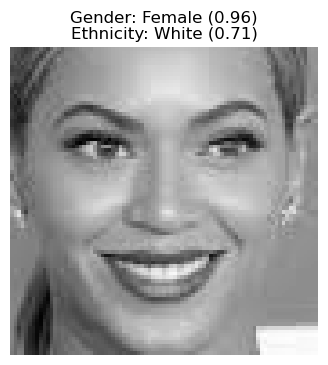

In [125]:
show_prediction(
    "~/Desktop/beyonce.jpg",
    model,
    device,
    ["White", "Black", "Asian", "Indian", "Other"],
    ["Male", "Female"]
)


I0000 00:00:1765475323.560096 17290118 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1
W0000 00:00:1765475323.593384 17327128 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1765475323.715048 17290118 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1
W0000 00:00:1765475323.736998 17327136 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


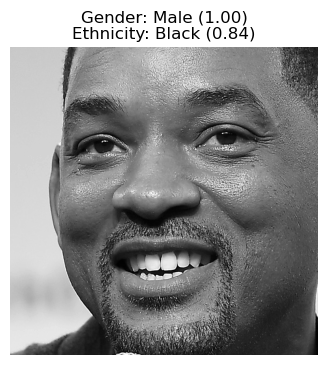

In [50]:
show_prediction(
    "~/Desktop/will_smith.jpg",
    model,
    device,
    ["White", "Black", "Asian", "Indian", "Other"],
    ["Male", "Female"]
)

### Grad-CAM

To better understand how our model makes predictions, we complement quantitative evaluation with a qualitative interpretability analysis using Grad-CAM (Gradient-weighted Class Activation Mapping). Grad-CAM highlights the regions of the input image that contribute most to the model’s decision, allowing us to visually inspect whether the network focuses on meaningful facial features or is influenced by irrelevant artifacts. This technique provides valuable insights into the model’s behavior and helps assess the reliability and fairness of its predictions. Here we implemented Grad-CAM both for downloaded images and test set images.

In [ ]:
model = CNN_MultiTask(num_ethnicity=5, num_gender=2, dropout=0.3)
model.load_state_dict(torch.load("best_resnet18_multitask.pt", map_location=device))
model.to(device)
model.eval()

In [ ]:
mp_face = mp.solutions.face_detection.FaceDetection(
    model_selection=1, min_detection_confidence=0.3
) # Initializes MediaPipe’s face detector

# Defines the preprocessing pipeline used during training
to_tensor_norm = T.Compose([
    T.ToTensor(),
    T.Normalize([0.5], [0.5]),
])

def crop_and_preprocess(path, side=48):
    img = Image.open(path).convert("RGB")
    arr = np.array(img)

    results = mp_face.process(arr)

    if not results.detections:
        print("No face detected.")
        face = img.convert("L")
    else:
        # Extracts the relative bounding box of the first detected face and converts it into absolute pixel coordinates while ensuring they remain within image bounds.
        det = results.detections[0].location_data.relative_bounding_box
        h, w, _ = arr.shape
        x1 = max(0, int(det.xmin * w))
        y1 = max(0, int(det.ymin * h))
        x2 = min(w, int((det.xmin + det.width) * w))
        y2 = min(h, int((det.ymin + det.height) * h))
        face = Image.fromarray(arr[y1:y2, x1:x2]).convert("L")

    face = face.resize((side, side)) # Crops the detected face region and converts it to grayscale to match the training dataset format.
    x = to_tensor_norm(face).unsqueeze(0)  # (1,1,48,48)
    return x, face

In [28]:
class GradCAM:

    def __init__(self, model):
        self.model = model # Stores a reference to the trained model.

    # Performs a manual forward pass through the network up to the last convolutional block, layer4, which is typically used for Grad-CAM because 
    # its feature maps have strong semantic meaning gradients.
    def forward_until_layer4(self, x):
        x = self.model.relu(self.model.bn1(self.model.conv1(x)))
        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        feats = self.model.layer4(x)
        feats.retain_grad()
        return feats

    # Forward pass after Layer 4
    def forward_rest(self, feats):
        x = self.model.avgpool(feats)
        x = torch.flatten(x, 1)
        x = self.model.norm(x)
        x = self.model.dropout(x)
        return x

    def __call__(self, feats, logits, class_idx):
        score = logits[0, class_idx] # Selects the logit corresponding to the target class (class_idx).
        self.model.zero_grad() # Computes the gradient of that logit with respect to the feature maps feats.
        score.backward(retain_graph=True)

        # Extract gradients and compute channel weights
        grads = feats.grad
        if grads is None:
            return None

        weights = grads.mean(dim=(2,3), keepdim=True)
        cam = (weights * feats).sum(dim=1).squeeze() # Compute the class activation map (weighted sum over channels).
        # Post-processing
        cam = torch.relu(cam)
        cam = (cam - cam.min()) / (cam.max() + 1e-8)
        return cam.detach().cpu().numpy()

In [29]:
def show_cam(x, cam, original_face):
    img = original_face  # 48 x 48 image
    # Resize the CAM to match the input resolution
    cam_tensor = torch.tensor(cam).unsqueeze(0).unsqueeze(0)
    cam_up = F.interpolate(cam_tensor, size=(48,48), mode="bilinear").squeeze().numpy()

    cam_up = (cam_up - cam_up.min()) / (cam_up.max() + 1e-8) # Normalizes the heatmap to the range [0, 1], making it suitable for visualization and 
                                                             # blending with the underlying image.

    # Overlay heatmap on the face image
    plt.figure(figsize=(4,4))
    plt.imshow(img, cmap="gray")
    plt.imshow(cam_up, cmap="jet", alpha=0.45)
    plt.axis("off")
    plt.show()


In [30]:
def run_gradcam(path, model, device, eth_labels, gen_labels):

    x, face_pil = crop_and_preprocess(path)
    x = x.to(device)
    x.requires_grad = True

    model.eval()
    camgen = GradCAM(model)

    # Forward pass through the model
    feats = camgen.forward_until_layer4(x)
    rep   = camgen.forward_rest(feats)
    # Compute logits for both tasks
    logits_eth = model.fc_eth(rep)
    logits_gen = model.fc_gen(rep)
    # Predicted classes
    pred_eth = logits_eth.argmax().item()
    pred_gen = logits_gen.argmax().item()

    print(f"\nGender predicted: {gen_labels[pred_gen]}")
    print(f"Ethnicity predicted: {eth_labels[pred_eth]}")

    print("\nGradCAM Ethnicity")
    cam_e = camgen(feats, logits_eth, pred_eth) # grad cam for ethnicity
    if cam_e is None:
        print("No gradient")
    else:
        show_cam(x, cam_e, face_pil)

    print("\nGradCAM Gender")
    cam_g = camgen(feats, logits_gen, pred_gen) # grad cam for gender
    if cam_g is None:
        print("No gradient")
    else:
        show_cam(x, cam_g, face_pil)



Gender predicted: Male
Ethnicity predicted: Black

GradCAM Ethnicity


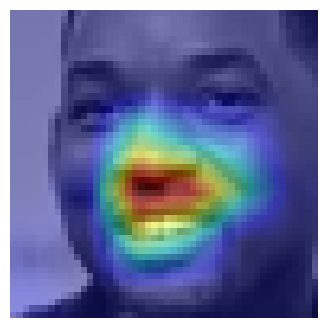


GradCAM Gender


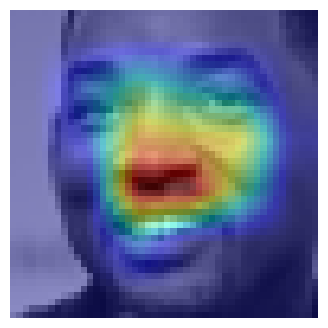

In [59]:
run_gradcam(
    "~/Desktop/will_smith.jpg",
    model,
    device,
    eth_labels=["White","Black","Asian","Indian","Other"],
    gen_labels=["Male","Female"]
)

For ethnicity, the Grad-CAM highlights a smaller and more localized region, mainly around the nose and central facial area. This indicates that the model relies on broad structural and tonal cues rather than distinct facial details, which is consistent with the subtle and distributed nature of ethnicity features.   
For gender, instead, the activation is more spread across the face, covering the nose, cheeks, and parts of the eyes. This is expected, as gender classification benefits from more global facial patterns and overall morphology. 

In the following section, we applied Grad-CAM to test-set images, focusing specifically on misclassified samples belonging to the Indian and Other ethnicity categories. Since gender classification is a relatively simple task and the model performs extremely well on it, our analysis concentrates instead on ethnicity errors, particularly for these two classes, which contain fewer samples and exhibit higher misclassification rates.
Observing only misclassified images is especially informative: if the heatmaps highlight inconsistent or irrelevant regions such as different facial features across images or even parts of the background, this suggests that the model has not learned a stable, discriminative pattern for these categories. This is likely influenced by the limited number of training examples for Indian and Other, making it harder for the model to form robust feature representations.

In [31]:
def get_all_predictions(model, test_loader, device):
    all_imgs = []
    all_true_eth = []
    all_true_gen = []
    all_pred_eth = []
    all_pred_gen = []

    model.eval()

    with torch.no_grad():
        for x, y_eth, y_gen in test_loader:
            x = x.to(device)

            o1, o2 = model(x) # Move inputs and run the model
            # Automatically identify the two model heads
            if o1.shape[1] == 2:
                logits_gen, logits_eth = o1, o2
            else:
                logits_gen, logits_eth = o2, o1
            # Predictions
            pred_eth = logits_eth.argmax(1).cpu()
            pred_gen = logits_gen.argmax(1).cpu()
            # Store data
            all_imgs.append(x.cpu())
            all_true_eth.append(y_eth)
            all_true_gen.append(y_gen)
            all_pred_eth.append(pred_eth)
            all_pred_gen.append(pred_gen)

    return (
        torch.cat(all_imgs),
        torch.cat(all_true_eth),
        torch.cat(all_true_gen),
        torch.cat(all_pred_eth),
        torch.cat(all_pred_gen),
    )

In [32]:
ETH_INDIAN = 3
ETH_OTHER = 4

imgs, t_eth, t_gen, p_eth, p_gen = get_all_predictions(model, test_loader, device)

mis_idx = torch.where(
    ((t_eth == ETH_INDIAN) | (t_eth == ETH_OTHER)) & (t_eth != p_eth) # Indian or Other and prediction is wrong
)[0] # Select misclassified Indian + Other samples

print(f"Total number of missclassified Indian/Other: {len(mis_idx)}")


 Total number of missclassified Indian/Other: 214


In [33]:
def plot_gradcam_errors(model, imgs, t_eth, t_gen, p_eth, p_gen,
                        indices, eth_labels, gen_labels,
                        rows=3, cols=4):

    camgen = GradCAM(model)
    model.eval()

    plt.figure(figsize=(16, 10))

    for i, idx in enumerate(indices[:rows*cols]):
        # Adds a batch dimension and enables gradient tracking (required for Grad-CAM).
        x = imgs[idx].unsqueeze(0).to(device)
        x.requires_grad = True

        # forward
        feats = camgen.forward_until_layer4(x)
        rep = camgen.forward_rest(feats)

        logits_eth = model.fc_eth(rep)
        logits_gen = model.fc_gen(rep)

        # GradCAM
        cam_e = camgen(feats, logits_eth, p_eth[idx].item())
        cam_g = camgen(feats, logits_gen, p_gen[idx].item())

        # Resize CAM
        cam_e = F.interpolate(torch.tensor(cam_e)[None, None], size=(48,48),
                              mode="bilinear").squeeze().numpy()
        cam_g = F.interpolate(torch.tensor(cam_g)[None, None], size=(48,48),
                              mode="bilinear").squeeze().numpy()

        # Original image for overlay
        img = imgs[idx].squeeze().numpy()

        # Subplot
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(img, cmap="gray")
        ax.imshow(cam_e, cmap="jet", alpha=0.45)
        ax.imshow(cam_g, cmap="jet", alpha=0.25)

        ax.set_title(
            f"Eth-T:{eth_labels[t_eth[idx]]} / Eth-P:{eth_labels[p_eth[idx]]}\n"
            f"Gen-T:{gen_labels[t_gen[idx]]} / Gen-P:{gen_labels[p_gen[idx]]}",
            fontsize=10
        )
        ax.axis("off")

    plt.tight_layout()
    plt.show()


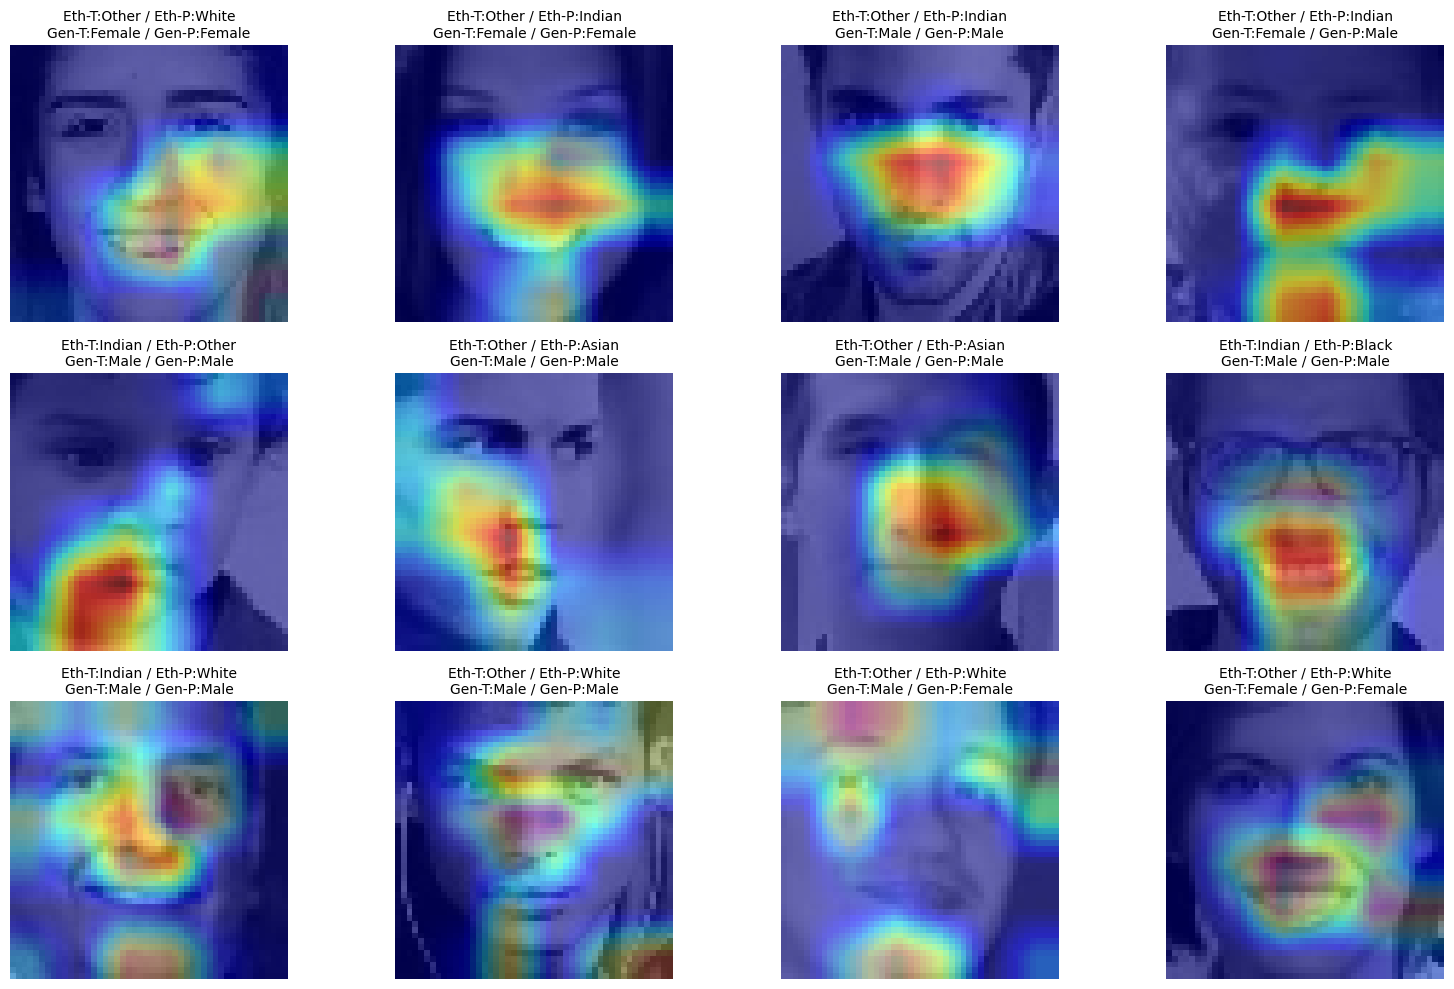

In [34]:
eth_labels = ["White","Black","Asian","Indian","Other"]
gen_labels = ["Male","Female"]

plot_gradcam_errors(
    model, imgs, t_eth, t_gen, p_eth, p_gen,
    mis_idx, eth_labels, gen_labels,
    rows=3, cols=4
)


These Grad-CAM visualizations reveal a consistent pattern across misclassified samples from the Indian and Other classes. The heatmaps show that the network often focuses on broad, noisy regions of the face (cheeks, nose, or even background areas) rather than clearly discriminative features. This diffuse and sometimes misplaced attention suggests that the model lacks strong, distinctive cues for these underrepresented classes. As a result, it tends to confuse them with larger, more common categories such as White, especially when images have unusual lighting, pose variations, or blurry details. Overall, the Grad-CAM highlights the intrinsic difficulty of learning minority classes and reinforces the need for more balanced data or class-specific training strategies.

### Error clustering

To better understand the behavior of our multitask classification model, we performed an error clustering analysis focused on the ethnicity prediction task. The goal of this analysis is not simply to count misclassifications, but to uncover patterns in the types of errors the model makes, identify systematic failure modes, and gain insights into which groups of samples are being confused for similar reasons.  
Error clustering works by extracting the internal embeddings (feature representations) of the misclassified samples and applying an unsupervised clustering algorithm (k-means). If misclassified samples naturally form clusters in the embedding space, it suggests that the model tends to make similar errors on images that share latent visual characteristics.   
By focusing on ethnicity, we aim to understand whether errors arise from ambiguous samples, insufficient training data for certain classes, overlapping visual patterns between ethnic groups, or biases in the learned representation. Ultimately, this type of analysis helps reveal how the model perceives the data and guides further improvements in training, data augmentation, or class balancing.

In [40]:
model = CNN_MultiTask(num_ethnicity=5, num_gender=2, dropout=0.4)

In [ ]:
model.load_state_dict(torch.load("best_resnet18_multitask.pt", map_location=device))
model.to(device)
model.eval()

In [20]:
# This function extracts the feature embedding produced by the CNN backbone before the final classification heads.
def extract_embedding(model, x):
    with torch.no_grad():
        # Manual forward pass through the backbone
        x = model.relu(model.bn1(model.conv1(x)))
        x = model.layer1(x)
        x = model.layer2(x)
        x = model.layer3(x)
        x = model.layer4(x)
        x = model.avgpool(x)
        x = torch.flatten(x, 1)
        x = model.norm(x)
    return x.cpu().numpy()


In [21]:
class MultiTaskDataset(Dataset):
    def __getitem__(self, idx):
        img = self.images[idx]

        # Image conversion + preprocessing
        img = Image.fromarray(img.astype(np.uint8), mode="L")
        img = self.transform(img)

        # Correct label casting
        gender = int(self.gender[idx])          
        ethnicity = int(self.ethnicity[idx])    

        return img, torch.tensor(ethnicity, dtype=torch.long), torch.tensor(gender, dtype=torch.long)


In [22]:
model.eval()

mis_embeddings = []
mis_images = []
mis_true = []
mis_pred = []

for x, y_eth, _ in test_loader:  

    # dtype fix for MPS
    y_eth = y_eth.long()

    # Move to device
    x = x.to(device).float()
    y_eth = y_eth.to(device)

    with torch.no_grad():
        o1, o2 = model(x)

        if o1.shape[1] == 5:   
            o_eth = o1
        else:
            o_eth = o2

    # Prediction for ethnicity
    pred_eth = o_eth.argmax(1)

    # Creates a boolean mask indicating which samples in the batch are misclassified.
    mis_mask = (pred_eth != y_eth)

    # Extract embeddings for all misclassified samples.
    for i in range(len(x)):
        if mis_mask[i]:

            emb = extract_embedding(model, x[i].unsqueeze(0))
            emb = emb.reshape(-1)

            mis_embeddings.append(emb)
            mis_images.append(x[i].cpu())
            mis_true.append(int(y_eth[i].item()))
            mis_pred.append(int(pred_eth[i].item()))

print("Total ethnicity errors:", len(mis_embeddings))
print(type(mis_embeddings[0]), mis_embeddings[0].shape)


Total ethnicity errors: 482
<class 'numpy.ndarray'> (512,)


In [23]:
# Convert all misclassified images to numpy arrays for stable indexing.
mis_images_np = [img.permute(1, 2, 0).cpu().numpy() for img in mis_images]

In [24]:
# Fast check to see if there are any NAs, the min and the max
mis_arr = np.array(mis_embeddings, dtype=np.float32)
print("Contains NaN:", np.isnan(mis_arr).any())
print("Contains Inf:", np.isinf(mis_arr).any())
print("Max value:", mis_arr.max())
print("Min value:", mis_arr.min())


Contains NaN: False
Contains Inf: False
Max value: 8.847494
Min value: -1.2571315


In [25]:
X = np.array(mis_embeddings, dtype=np.float32)

# Normalize embeddings (unit norm)
norm = np.linalg.norm(X, axis=1, keepdims=True)
X = X / (norm + 1e-8)

print("New max:", X.max(), "New min:", X.min())


New max: 0.56580925 New min: -0.07399777


In [26]:
# The MiniBatchKMeans algorithm is a faster and memory-efficient version of standard K-means designed for large datasets or situations where full K-means becomes unstable or slow.

kmeans = MiniBatchKMeans(
    n_clusters=3,
    batch_size=64, # instead of using the entire dataset at once, the algorithm updates the centroids using small random batches of 64 embeddings at a time. 
                   # This dramatically reduces memory usage and prevents the kernel from freezing.
    random_state=42
)

clusters = kmeans.fit_predict(X) # Runs the clustering algorithm on the matrix of embeddings X and returns the cluster assignment for each sample.

print(np.bincount(clusters))


[177 135 170]


In [27]:
def plot_cluster(cluster_id, clusters, mis_images, mis_true, mis_pred, eth_labels, max_imgs=30):
    """
    Plot up to `max_imgs` misclassified samples belonging to a specific cluster.
    """

    # Select indices belonging to the cluster.
    idxs = [i for i, c in enumerate(clusters) if c == cluster_id]
    idxs = idxs[:max_imgs]  # imits the number of displayed images to max_imgs to avoid generating excessively large figures.
    
    # Handle empty clusters
    n = len(idxs)
    if n == 0:
        print(f"No samples in cluster {cluster_id}")
        return
    
    cols = 6
    rows = (n + cols - 1) // cols

    plt.figure(figsize=(16, 3.5 * rows))

    for j, idx in enumerate(idxs):

        img = mis_images[idx].cpu().squeeze().numpy()     # (48, 48)
        t = eth_labels[mis_true[idx]]                     # true ethnicity
        p = eth_labels[mis_pred[idx]]                     # predicted ethnicity

        ax = plt.subplot(rows, cols, j + 1)
        ax.imshow(img, cmap="gray")
        ax.axis("off")
        ax.set_title(f"T:{t}\nP:{p}", fontsize=10)

    plt.suptitle(f"Cluster {cluster_id} — {n} samples", fontsize=14)
    plt.tight_layout()
    plt.show()


In [28]:
eth_labels = ["White", "Black", "Asian", "Indian", "Other"]

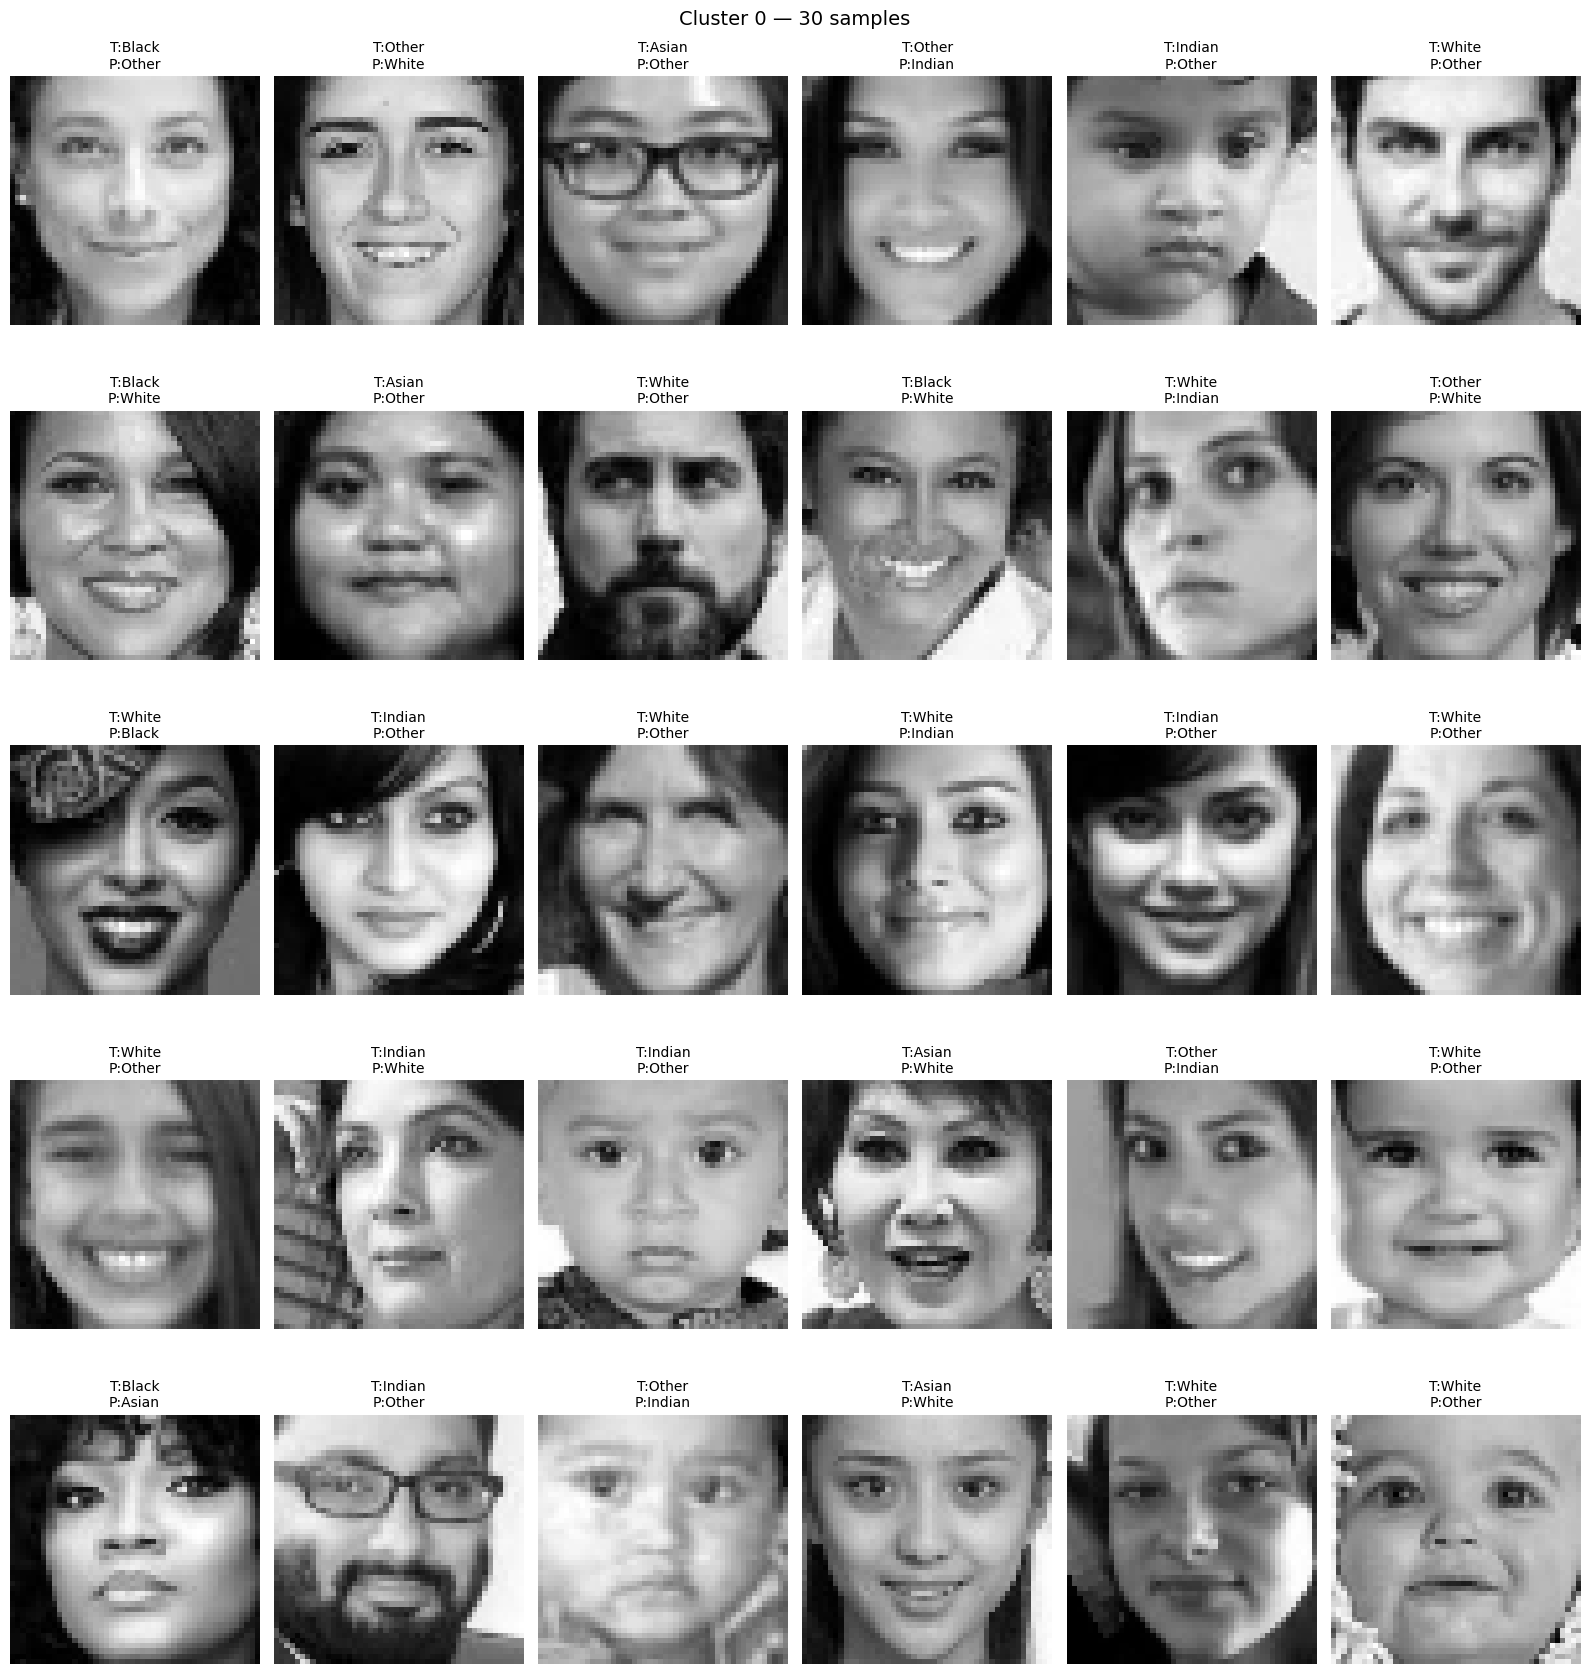

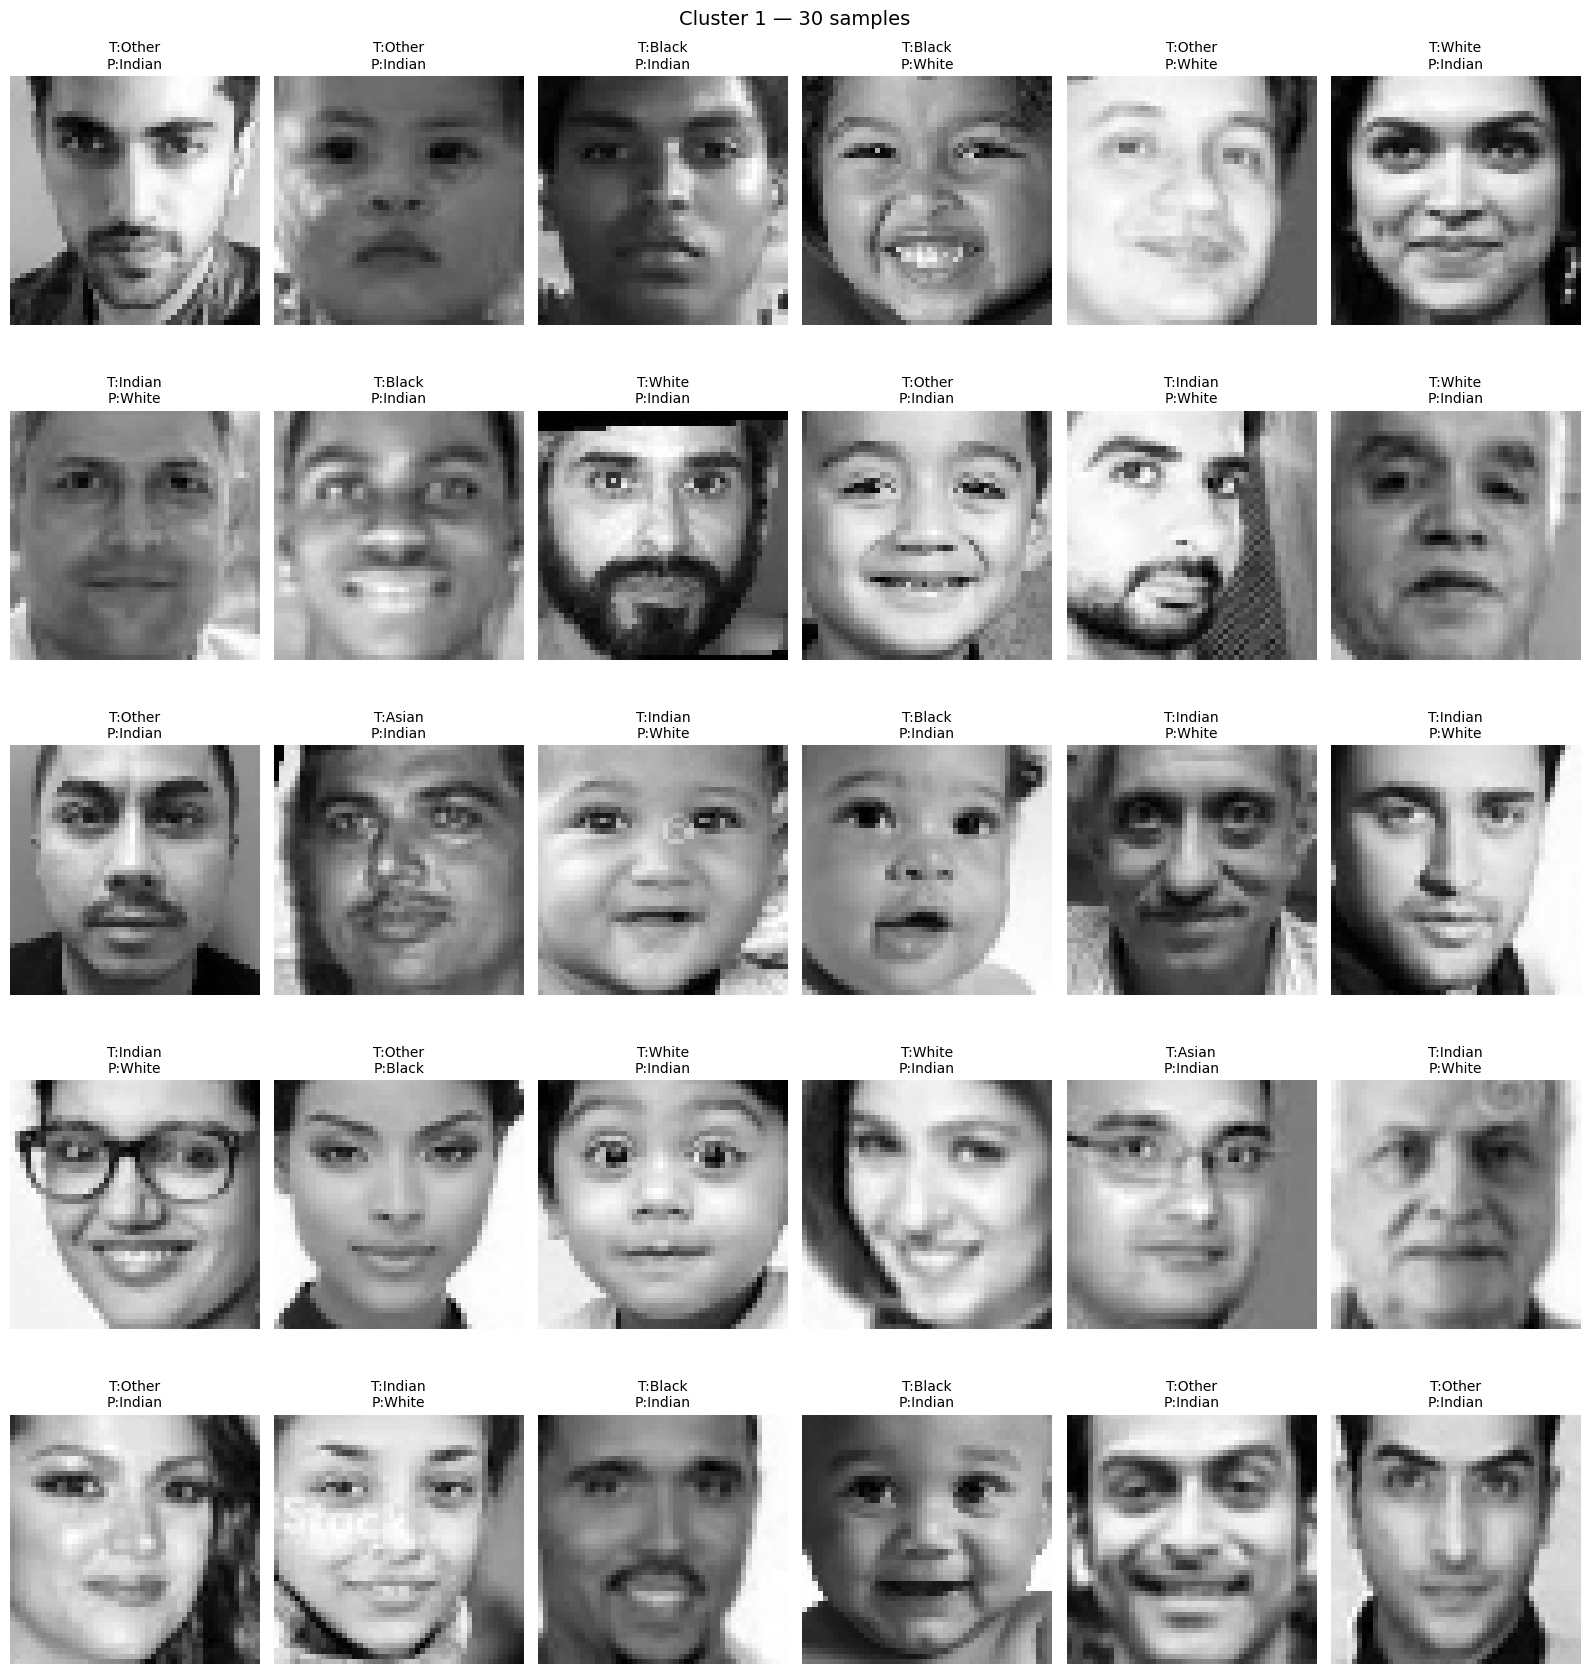

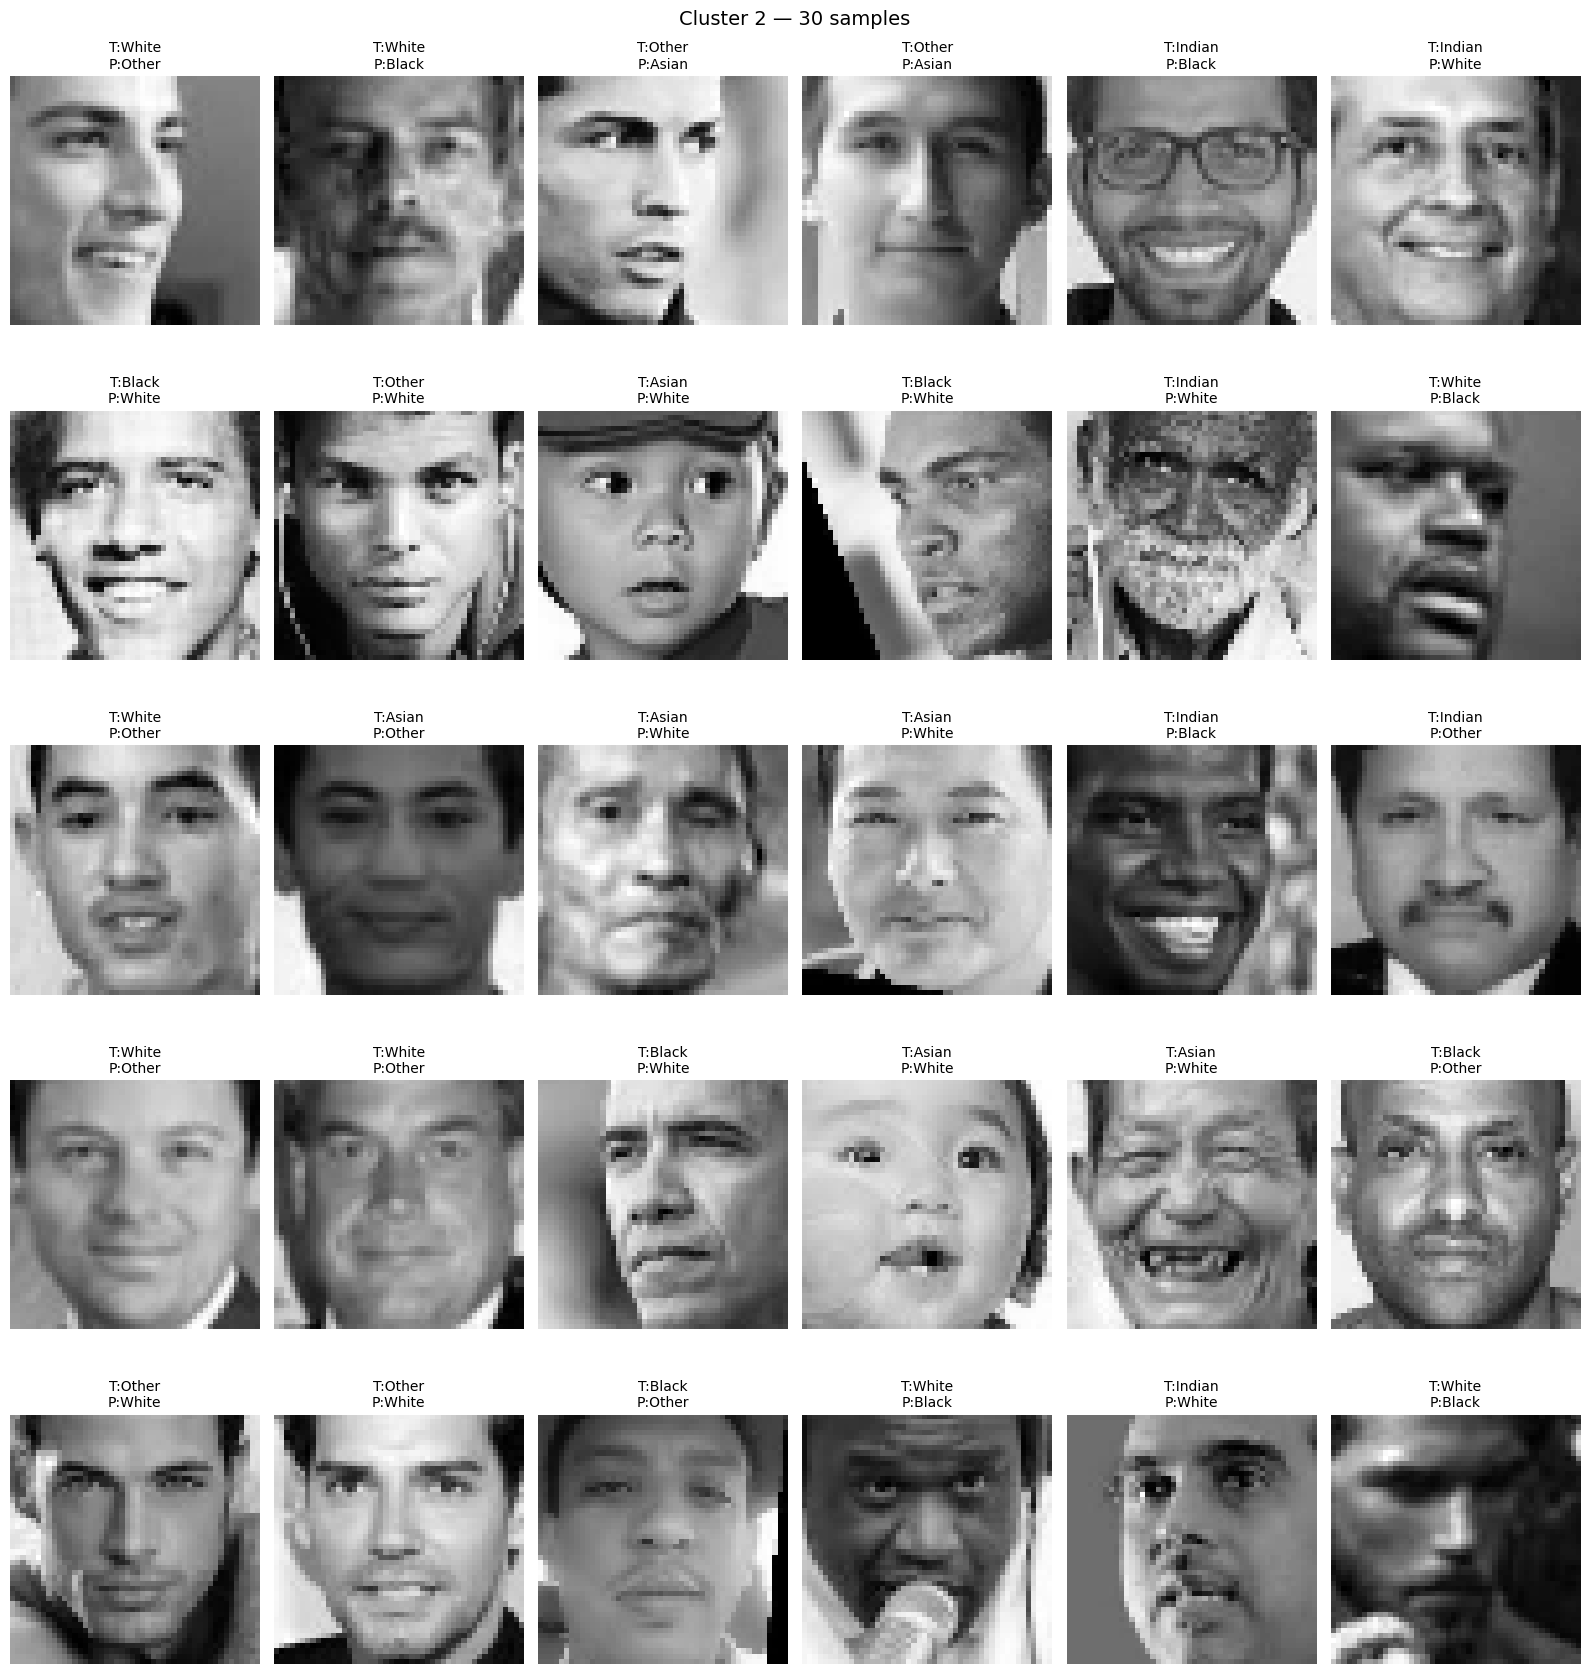

In [30]:
for c in range(3):
    plot_cluster(c, clusters, mis_images, mis_true, mis_pred, eth_labels)


From the visual inspection of the three clusters obtained through K-Means on the misclassified ethnicity embeddings, several meaningful patterns emerge. These groups reveal how the model tends to confuse certain facial traits across different ethnic categories, confirming that errors are not random, but follow some structures in the embedding space.

- **Cluster 0 — Mixed ethnicities, uniform lighting, smooth appearance**: cluster 0 does not group together a specific ethnicity. Instead, it contains a heterogeneous mix of Indian, Asian, Black, Other, and some White faces.
What the images share seems to be visual conditions, not ethnicity: uniform or soft lighting, smooth textures, frontal or nearly-frontal poses. These visual similarities likely dominate the embedding space in the misclassified samples, causing different ethnicities to be grouped together.
The model may misclassify these individuals because in such clean or evenly lit conditions, the features it relies on to detect ethnicity become less pronounced, leading it to confuse multiple classes.

- **Cluster 1 — Medium-tone faces, soft contrast, many Indian misclassifications**: This cluster contains many faces that were predicted as Indian even though their true ethnicity is different (e.g., White, Other, Black, Asian).
This indicates that the model tends to overpredict the Indian class, grouping together faces that share certain visual properties which the network incorrectly associates with this ethnicity.
Images in this cluster often present intermediate skin tones, soft shadows, and frequently baby or child faces, which tend to dilute adult ethnic markers.

- **Cluster 2 — Darker faces, high contrast, and challenging poses**: This cluster contains many darker-skinned individuals, including several misclassified Black and Indian faces.
The dominant visual traits include: high contrast lighting, strong shadows, side poses or partial occlusions, older faces with pronounced textures.
The cluster reveals that the model is particularly sensitive to illumination variability and pose, which can override true ethnic features and lead to systematic confusion between Black, Indian, and Other.

Overall, the model does not produce clearly separated clusters, but some patterns can still be observed. The visual inspection of the plots shows that misclassifications tend to occur in difficult cases, often influenced by lighting conditions, skin tone, and facial pose. Although the clusters are not perfectly distinct, this type of analysis is still valuable, as it helps reveal systematic weaknesses in the model and highlights where it struggles to distinguish between ethnicities. 

Moreover, we tested different values of clusters and visually inspected the resulting groups of misclassified samples. Among the alternatives, K = 3 produced the most coherent and interpretable structure, with each cluster highlighting a distinct type of failure pattern in the model. Therefore, we consider three clusters an appropriate and informative choice for this exploratory study.

# Model 2: Age regression

Now, we move on to the next part: building a regression model to predict an individual’s exact age.

## Data processing

Before starting, we inspected the number of images available for each age (range 1–116) and noticed that for individuals older than 90, the dataset contained very few samples, in some cases none at all. For this reason, we decided to remove all individuals above age 90 before training the regression model.  
Even after removing these outliers, the histogram of the age distribution clearly shows a severe imbalance problem: some ages have thousands of images, while others have only a few hundred. This imbalance will naturally make age prediction more difficult, especially for underrepresented ages.

In [49]:
age_counts = df_clean["age"].value_counts().sort_index()
print(age_counts)

age
1      1062
2       454
3       281
4       266
5       190
       ... 
105       5
110       5
111       1
115       3
116       4
Name: count, Length: 104, dtype: int64


In [50]:
df_clean2 = df_clean[df_clean["age"] <= 90].copy()
df_clean2.reset_index(drop=True, inplace=True)

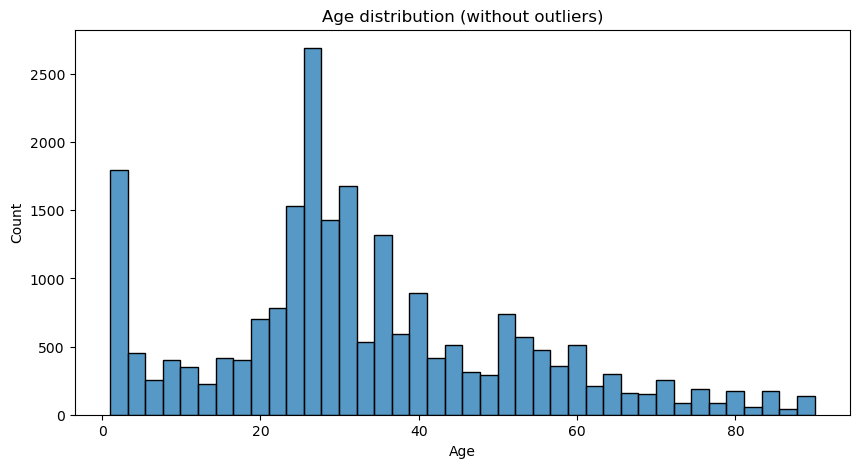

In [118]:
plt.figure(figsize=(10,5))
sns.histplot(df_clean2["age"], bins=40)
plt.title("Age distribution (without outliers)")
plt.xlabel("Age")
plt.show()


Given the strong imbalance in the age distribution, we decided to divide the age variable into six bins, each containing approximately the same number of images. We tested different numbers of bins, and six turned out to be the most effective configuration. The resulting bins are shown in the output below.  
With this structure, we adopted a two-stage modelling approach: first, we train a classifier to assign each image to the correct age bin; then, once the coarse age range is determined, we apply a regression model inside each bin to refine the prediction and get as close as possible to the true numerical age.  
Using a standard regression directly on the full dataset was not feasible given the extremely skewed distribution. Among the alternatives, this bin-based strategy is the most suitable and the results, while not perfect, confirm its effectiveness. Performance is limited primarily by the severe class imbalance and by the quality of the images, which are low-resolution 48×48 grayscale faces, but the approach still achieves reasonable results considering these constraints.

In [52]:
np.random.seed(123)
ages_jitter = df_clean2["age"].values + np.random.uniform(-0.3, 0.3, len(df_clean2)) 
# Jitter to obtain more stable quantiles: this does not change the actual age labels used for training; it only helps the binning step by preventing ties.

# 6 BINS
df_clean2["coarse_bin"] = pd.qcut(
    ages_jitter,
    q=6,
    labels=False,
    duplicates="drop"
)

for b in sorted(df_clean2["coarse_bin"].unique()):
    sub = df_clean2[df_clean2["coarse_bin"] == b]
    print(f"Bin {b}: count={len(sub)}, range={sub['age'].min()}–{sub['age'].max()}")


Bin 0: count=3778, range=1–16
Bin 1: count=3778, range=16–26
Bin 2: count=3777, range=26–29
Bin 3: count=3778, range=29–37
Bin 4: count=3777, range=37–53
Bin 5: count=3778, range=53–90


We split the dataset into training, validation, and test sets using a two-step train_test_split procedure.
The key reason is that we need stratification by age bin (coarse_bin) to ensure each split preserves the same age-range distribution. Without stratification, some bins could easily become under-represented or even missing in either the validation or test set, making the model unable to learn or properly evaluate certain age groups.  
First, we split the full dataset into 90% train and 10% test, preserving the bin proportions.
Then, from the training set, we extract 10% for validation, again using stratification to maintain the same balanced structure.

In [53]:
train_df, test_df = train_test_split(df_clean2, test_size=0.10, random_state=42, stratify=df_clean2["coarse_bin"])
train_df, val_df  = train_test_split(train_df, test_size=0.10, random_state=42, stratify=train_df["coarse_bin"])

### Data augmentation

In this case as well, we applied data augmentation to all images using exactly the same transformations adopted for the multitask model. This helps improve performance and is especially useful when working with highly imbalanced datasets, as it increases the model’s exposure to visual variability and reduces overfitting.

In [54]:
# Dataset
class AgeDataset(Dataset):
    def __init__(self, df, transform):
        self.images = np.stack(df["pixel_array"].values)
        self.bins = df["coarse_bin"].values
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]

        if img.ndim == 1:
            img = img.reshape(48, 48)

        img = Image.fromarray(img.astype(np.uint8), mode="L")
        img = self.transform(img)
        return img, self.bins[idx]

# Transforms
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(8),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.RandomResizedCrop(48, scale=(0.92, 1.0)),
    transforms.ToTensor()
])

test_transform = transforms.ToTensor()

# Build data loader
train_dataset = AgeDataset(train_df, train_transform)
val_dataset   = AgeDataset(val_df, test_transform)
test_dataset  = AgeDataset(test_df, test_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)


## Coarse Classifier

As a first step, we implement the coarse age classifier, which is responsible for categorizing each individual into the appropriate age interval.
Instead of training a network from scratch, the model reuses the convolutional backbone of the multitask model trained earlier.
This allows the classifier to leverage strong pretrained facial features and drastically reduce training time. So, the model does not learn the low-level features from scratch (edges, textures, facial components) and it benefits from the pretrained multitask network, which has already learned rich representations of faces.
Only the final classification head is new and trainable.

In [ ]:
multitask = CNN_MultiTask()
multitask.load_state_dict(torch.load("best_resnet18_multitask.pt", map_location=device))
multitask.to(device)
multitask.eval()

In [56]:
class CoarseAgeClassifier(nn.Module):
    def __init__(self, multitask_backbone, num_bins=6):
        super().__init__()
        # The model copies the convolutional layers from the multitask backbone.
        self.conv1  = multitask_backbone.conv1
        self.bn1    = multitask_backbone.bn1
        self.relu   = nn.ReLU(inplace=True)

        self.layer1 = multitask_backbone.layer1
        self.layer2 = multitask_backbone.layer2
        self.layer3 = multitask_backbone.layer3
        self.layer4 = multitask_backbone.layer4
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.norm = nn.LayerNorm(512)
        self.dropout = nn.Dropout(0.3)

        self.fc = nn.Linear(512, num_bins) # Final classification layer that predicts 6 age bins.

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.norm(x)
        x = self.dropout(x)
        return self.fc(x)


This block of code trains the coarse age classifier, which predicts one of the 6 age bins. The training is divided into two stages:

1) **Head-only training (freeze backbone, train only final layers)**: the pretrained multitask backbone already learned rich features (faces, structure, etc.). If we trained the entire network immediately, the gradients would be too unstable and would ruin the pretrained features. So, first we freeze the backbone and train only the classification head.

2) **Full fine-tuning (train the entire network)**: after the classifier head learns to use the backbone features, we now unfreeze the entire model. This allows the feature extractor to adapt specifically to age prediction, which is a different task from gender/ethnicity.

This two-step training strategy stabilizes learning, avoids destroying pretrained features, and typically yields better results.  
Similarly to the multitask classification model, the training procedure uses warmup to stabilize the early updates, early stopping to prevent overfitting, weight decay for regularization, and cosine annealing to smoothly decrease the learning rate. The optimizer is Adam, and the overall training dynamics closely mirror the previous model. The key difference is that, in this case, the training follows a two-stage strategy: first only the classifier head is trained, and then the entire network is fine-tuned.

In [57]:
# Loss
criterion = nn.CrossEntropyLoss()

# Evaluation function
def evaluate(model, loader):
    model.eval()
    preds, targets = [], []
    total_loss = 0
    
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            total_loss += loss.item() * x.size(0) # computing loss
            # Store predictions and targets
            preds.extend(out.argmax(1).cpu().numpy())
            targets.extend(y.cpu().numpy())

    return (
        total_loss / len(targets),
        accuracy_score(targets, preds),
        f1_score(targets, preds, average="weighted")
    ) # Returns: average loss over the dataset, accuracy, weighted F1-score.

#  Create model (multitask_backbone already loaded)
coarse_model = CoarseAgeClassifier(multitask_backbone=multitask, num_bins=6).to(device) # It creates the coarse age classification model.

save_path = "best_coarse_classifier.pt"
best_val_acc = 0
patience = 5
patience_counter = 0

# 1) Train only the classifier head (for 5 epochs)

print("\nTRAINING HEAD ONLY (5 epochs)\n")

# Freezing all layers except the classifier head: only the final classifier layers update their weights.
for name, param in coarse_model.named_parameters():
    param.requires_grad = ("fc" in name or "dropout" in name or "norm" in name)

optimizer = optim.Adam(filter(lambda p: p.requires_grad, coarse_model.parameters()),
                       lr=5e-4, weight_decay=1e-4) # A relatively higher learning rate is used because only a small number of parameters are being trained.

# Warmup scheduler: first 2 epochs
warmup_epochs = 2
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda e: (e + 1) / warmup_epochs if e < warmup_epochs else 1
)

for epoch in range(5):
    coarse_model.train()
    preds, targets = [], []

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        out = coarse_model(x)
        loss = criterion(out, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        preds.extend(out.argmax(1).cpu().numpy())
        targets.extend(y.cpu().numpy())

    train_acc = accuracy_score(targets, preds)
    val_loss, val_acc, val_f1 = evaluate(coarse_model, val_loader)

    scheduler.step()

    print(f"[Head] Epoch {epoch+1}/5 | Train Acc {train_acc:.3f} | Val Acc {val_acc:.3f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(coarse_model.state_dict(), save_path)
        print("Saved NEW BEST model!\n")
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered (HEAD PHASE)")
        break

# 2) Full fine tuning (all layers, 15 epochs) 

print("\nFULL FINE-TUNING (15 epochs)\n")

# Unfreeze the entire model
for param in coarse_model.parameters():
    param.requires_grad = True

optimizer = optim.Adam(coarse_model.parameters(), lr=1e-4, weight_decay=1e-4)

# Cosine LR after warmup
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)

patience_counter = 0

for epoch in range(15):
    coarse_model.train()
    preds, targets = [], []

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        out = coarse_model(x)
        loss = criterion(out, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        preds.extend(out.argmax(1).cpu().numpy())
        targets.extend(y.cpu().numpy())

    train_acc = accuracy_score(targets, preds)
    val_loss, val_acc, val_f1 = evaluate(coarse_model, val_loader)

    scheduler.step()

    print(f"[FT] Epoch {epoch+1}/15 | Train Acc {train_acc:.3f} | Val Acc {val_acc:.3f}")

    # Early stopping + checkpoint
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(coarse_model.state_dict(), save_path)
        print("Saved NEW BEST model!\n")
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered (FINE-TUNING PHASE)")
        break

print(f"Best model saved to: {save_path}")
print(f"Best Val Accuracy: {best_val_acc:.3f}")



TRAINING HEAD ONLY (5 epochs)

[Head] Epoch 1/5 | Train Acc 0.336 | Val Acc 0.400
Saved NEW BEST model!

[Head] Epoch 2/5 | Train Acc 0.397 | Val Acc 0.429
Saved NEW BEST model!

[Head] Epoch 3/5 | Train Acc 0.413 | Val Acc 0.424
[Head] Epoch 4/5 | Train Acc 0.413 | Val Acc 0.448
Saved NEW BEST model!

[Head] Epoch 5/5 | Train Acc 0.415 | Val Acc 0.445

FULL FINE-TUNING (15 epochs)

[FT] Epoch 1/15 | Train Acc 0.486 | Val Acc 0.531
Saved NEW BEST model!

[FT] Epoch 2/15 | Train Acc 0.528 | Val Acc 0.546
Saved NEW BEST model!

[FT] Epoch 3/15 | Train Acc 0.554 | Val Acc 0.553
Saved NEW BEST model!

[FT] Epoch 4/15 | Train Acc 0.564 | Val Acc 0.561
Saved NEW BEST model!

[FT] Epoch 5/15 | Train Acc 0.579 | Val Acc 0.568
Saved NEW BEST model!

[FT] Epoch 6/15 | Train Acc 0.587 | Val Acc 0.571
Saved NEW BEST model!

[FT] Epoch 7/15 | Train Acc 0.599 | Val Acc 0.577
Saved NEW BEST model!

[FT] Epoch 8/15 | Train Acc 0.606 | Val Acc 0.568
[FT] Epoch 9/15 | Train Acc 0.614 | Val Acc 0.582
Sa

In [58]:
# Accuracy and F1 on the test set
test_loss, test_acc, test_f1 = evaluate(coarse_model, test_loader)
print("TEST RESULTS: Acc:", test_acc, "F1:", test_f1)

TEST RESULTS: Acc: 0.5840317600352889 F1: 0.5818989775003055


The coarse age classifier reaches a validation accuracy of about 0.58, and the test results are very similar (Acc ≈ 0.58, F1 ≈ 0.57). Given the difficulty of the task, the strong imbalance in the age distribution, and the low resolution (48×48 grayscale), this performance is reasonable. The model is clearly learning meaningful age ranges, but misclassifications remain common, especially in adjacent bins where visual differences are subtle. Overall, the coarse classifier provides a solid foundation for the second-stage fine-grained regression and since it is just the first step of our model these results are enough good.

## Bins regressions

After filtering the dataset and creating the bin labels, we must rebuild all numpy arrays to ensure they are perfectly synchronized with the updated DataFrames. Any mismatch between the DataFrame rows and the corresponding numpy arrays (images, ages, or bins) would corrupt the training process, causing incorrect labels, shape errors, or silent misalignment bugs. By reconstructing the arrays from the final cleaned DataFrames, we guarantee that every image, age value, and bin index refers to the exact same sample. 

In [59]:
train_images = np.stack(train_df["pixel_array"].values)
val_images   = np.stack(val_df["pixel_array"].values)
test_images  = np.stack(test_df["pixel_array"].values)

train_ages = train_df["age"].values.astype(float)
val_ages   = val_df["age"].values.astype(float)
test_ages  = test_df["age"].values.astype(float)

train_bins = train_df["coarse_bin"].values.astype(int)
val_bins   = val_df["coarse_bin"].values.astype(int)
test_bins  = test_df["coarse_bin"].values.astype(int)

print(len(train_images), len(train_df))  # fast check
print(len(val_images), len(val_df))


18359 18359
2040 2040


The model reuses the pretrained backbone (the same CNN feature extractor learned during the coarse-bin training), which is kept frozen during the forward pass to preserve its previously learned representations. Only a small fully connected head is added on top of the 512-dimensional feature vector, consisting of a Linear, ReLU, Dropout, Linear sequence that outputs a single continuous value. The backbone provides stable, high-level facial features, while the regression head learns to map these features to a precise age estimate. This design keeps training efficient and prevents overfitting, since only the lightweight head is trained.

In [60]:
class AgeRegressor(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone  # ResNet18 blocks already trained

        # small head for regression
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        with torch.no_grad():  # Freeze backbone during forward
            feat = self.backbone(x)

        # Feat has shape [B, 512]
        return self.fc(feat).squeeze(1)


This class below extracts the deep feature representation learned by the coarse age classifier. Instead of using the full model this module copies only the convolutional backbone (from the initial conv/batchnorm layers up to layer4), along with the average pooling, normalization, and dropout components. Its purpose is to provide a clean, reusable 512-dimensional embedding for each face.

During the forward pass, the image is processed exactly as in the coarse classifier, but the pipeline stops before the fully connected bin-classification head. The output is therefore a normalized feature vector capturing high-level facial structure relevant for age estimation. This feature extractor is later used to train the fine-grained regression model inside each age bin, ensuring consistent and stable embeddings based on the previously learned representation.

In [61]:
class FeatureExtractor(nn.Module):
    def __init__(self, coarse_model):
        super().__init__()
        self.conv1 = coarse_model.conv1
        self.bn1   = coarse_model.bn1
        self.relu  = coarse_model.relu

        self.layer1 = coarse_model.layer1
        self.layer2 = coarse_model.layer2
        self.layer3 = coarse_model.layer3
        self.layer4 = coarse_model.layer4

        self.avgpool = coarse_model.avgpool
        self.norm    = coarse_model.norm  
        self.dropout = coarse_model.dropout

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.norm(x)
        return x


In [62]:
class BinRegressionDataset(Dataset): # input = raw image arrays and their corresponding continuous age labels.
    def __init__(self, images, ages, transform):
        self.images = images
        self.ages = ages
        self.transform = transform

    def __len__(self):
        return len(self.images)

    # Returns the transformed image together with the true numerical age
    def __getitem__(self, idx):
        img = self.images[idx]
        
        if img.ndim == 1:
            img = img.reshape(48, 48)

        img = Image.fromarray(img.astype(np.uint8), mode="L")
        img = self.transform(img)

        return img, float(self.ages[idx])


In [63]:
def train_regressor(model, loader, val_loader, bin_id, device,
                    epochs=20, lr=2e-4, ckpt_path=None): # Defines a function to train the regression model for a specific age bin.

    model.to(device)
    optimizer = torch.optim.Adam(model.fc.parameters(), lr=lr) # Uses Adam to optimize only the regression head, keeping the feature extractor frozen.
    criterion = nn.L1Loss()  # MAE-based regression

    best_mae = float("inf")

    for ep in range(epochs):
        model.train()

        total_loss = 0
        preds_train = []
        true_train = []

        # Training
        for x, age in loader:
            x = x.to(device)
            age = age.to(device, dtype=torch.float32) # Loads a batch of images and ages and moves them to the device.

            pred = model(x) # predictions
            loss = criterion(pred, age) # MAE

            optimizer.zero_grad() # reset gradients
            loss.backward() # backpropagation
            optimizer.step() # update parameters

            total_loss += loss.item() * x.size(0)
            # Stores predictions and true ages for computing MAE later.
            preds_train.extend(pred.detach().cpu().numpy())
            true_train.extend(age.cpu().numpy())

        train_mae = np.mean(np.abs(np.array(preds_train) - np.array(true_train))) # Compute training MAE

        # Validation
        model.eval()
        preds_val = []
        true_val = []
        with torch.no_grad():
            # Runs validation without gradient tracking.
            for x, age in val_loader:
                x = x.to(device)
                age = age.to(device, dtype=torch.float32)
                pred = model(x)

                # Collects validation predictions and targets.
                preds_val.extend(pred.cpu().numpy())
                true_val.extend(age.cpu().numpy())

        val_mae = np.mean(np.abs(np.array(preds_val) - np.array(true_val))) # MAE

        print(f"[Bin {bin_id}] Epoch {ep+1}/{epochs} | Train MAE {train_mae:.3f} | Val MAE {val_mae:.3f}")

        if val_mae < best_mae:
            best_mae = val_mae
            torch.save(model.state_dict(), ckpt_path)
            print("✔ Saved best model!")

    print(f"Finished Bin {bin_id} training.")


The code below for each bin b, selects the corresponding samples from the training and validation sets and constructs a dedicated BinRegressionDataset, which returns images and their continuous ages. The training dataset uses full augmentation (train_transform), while the validation dataset only applies basic tensor conversion, as no augmentation should be used during validation.  
For every bin, a separate DataLoader is created with a batch size of 64, shuffled for training and ordered for validation. These loaders are then stored in two lists (train_loaders_bin and val_loaders_bin), so the regression model for each age bin can be trained independently on its own subset of data.

In [64]:
train_loaders_bin = []
val_loaders_bin   = []

for b in range(6):
    idx = train_df["coarse_bin"] == b
    val_idx = val_df["coarse_bin"] == b

    train_ds = BinRegressionDataset(
        train_images[idx], train_ages[idx], train_transform
    )
    val_ds = BinRegressionDataset(
        val_images[val_idx], val_ages[val_idx], transforms.ToTensor()
    )

    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=64)

    train_loaders_bin.append(train_loader)
    val_loaders_bin.append(val_loader)


In [65]:
backbone = FeatureExtractor(coarse_model) # A shared feature extractor (backbone) is created from the coarse classifier so that all regressors use the same learned 
# facial representation.

for b in range(6): # Each regressor is trained only on the images belonging to its bin, using the corresponding training and validation loaders previously created.
    print(f"Training regressor for bin {b}")

    regressor = AgeRegressor(backbone)

    train_regressor(
        model=regressor,
        loader=train_loaders_bin[b],
        val_loader=val_loaders_bin[b],
        bin_id=b,
        device=device,
        epochs=40,
        lr=3e-4,
        ckpt_path=f"regressor_bin{b}.pt"
    )


Training regressor for bin 0
[Bin 0] Epoch 1/40 | Train MAE 3.430 | Val MAE 2.584
✔ Saved best model!
[Bin 0] Epoch 2/40 | Train MAE 2.550 | Val MAE 2.179
✔ Saved best model!
[Bin 0] Epoch 3/40 | Train MAE 2.349 | Val MAE 2.042
✔ Saved best model!
[Bin 0] Epoch 4/40 | Train MAE 2.331 | Val MAE 2.001
✔ Saved best model!
[Bin 0] Epoch 5/40 | Train MAE 2.270 | Val MAE 1.962
✔ Saved best model!
[Bin 0] Epoch 6/40 | Train MAE 2.190 | Val MAE 1.909
✔ Saved best model!
[Bin 0] Epoch 7/40 | Train MAE 2.118 | Val MAE 1.870
✔ Saved best model!
[Bin 0] Epoch 8/40 | Train MAE 2.132 | Val MAE 1.902
[Bin 0] Epoch 9/40 | Train MAE 2.116 | Val MAE 1.821
✔ Saved best model!
[Bin 0] Epoch 10/40 | Train MAE 2.111 | Val MAE 1.864
[Bin 0] Epoch 11/40 | Train MAE 2.074 | Val MAE 1.805
✔ Saved best model!
[Bin 0] Epoch 12/40 | Train MAE 2.060 | Val MAE 1.796
✔ Saved best model!
[Bin 0] Epoch 13/40 | Train MAE 2.008 | Val MAE 1.894
[Bin 0] Epoch 14/40 | Train MAE 2.111 | Val MAE 1.761
✔ Saved best model!
[Bin

During training, only the regression head is updated, while the backbone remains frozen, ensuring stable feature extraction across bins. The train function is called with 40 epochs with a learning rate of 3e-4, and a dedicated checkpoint path for each bin.   
Across all six bins, the regressors show a clear pattern: the initial epochs drastically reduce the error, and validation MAE stabilizes over time, confirming that the training procedure is effective and the backbone features are informative.  
- **Bins 0, 1, and 2 (young to young adults)** achieve very strong performance, with validation MAE reaching values between 1.0 and 2.0 years, which is excellent given the low resolution and greyscale input. Bin 2 performs especially well, converging to a MAE around 1 year, showing that facial cues in this age range are easier to model (indeed this bin is very small and it contains age ranging from 26 to 29).

- **Bins 3 and 4 (middle-aged adults)** also show stable convergence, with validation MAE around 2.0–3.5 years. Errors naturally increase here because aging signs become more subtle and nonlinear. Still, the regressors consistently improve throughout training.  

- **Bin 5 (older individuals)** is clearly the most challenging (it is the biggest bin): initial errors are extremely high due to limited samples and greater variability, but the model steadily improves, reaching a validation MAE around 6 years. This is expected, as older-age faces show larger heterogeneity and fewer visual cues tied to precise age.

Overall, the progression across bins demonstrates that the two-stage strategy works well: bins with abundant and distinctive facial characteristics produce low regression errors, while bins with fewer samples or more variable appearances naturally exhibit higher MAE. Despite these challenges, the regressors achieve reasonable results, especially considering the strong dataset imbalance and low image quality.

In [66]:
log_text = """
Training regressor for bin 0
[Bin 0] Epoch 1/40 | Train MAE 3.430 | Val MAE 2.584
✔ Saved best model!
[Bin 0] Epoch 2/40 | Train MAE 2.550 | Val MAE 2.179
✔ Saved best model!
[Bin 0] Epoch 3/40 | Train MAE 2.349 | Val MAE 2.042
✔ Saved best model!
[Bin 0] Epoch 4/40 | Train MAE 2.331 | Val MAE 2.001
✔ Saved best model!
[Bin 0] Epoch 5/40 | Train MAE 2.270 | Val MAE 1.962
✔ Saved best model!
[Bin 0] Epoch 6/40 | Train MAE 2.190 | Val MAE 1.909
✔ Saved best model!
[Bin 0] Epoch 7/40 | Train MAE 2.118 | Val MAE 1.870
✔ Saved best model!
[Bin 0] Epoch 8/40 | Train MAE 2.132 | Val MAE 1.902
[Bin 0] Epoch 9/40 | Train MAE 2.116 | Val MAE 1.821
✔ Saved best model!
[Bin 0] Epoch 10/40 | Train MAE 2.111 | Val MAE 1.864
[Bin 0] Epoch 11/40 | Train MAE 2.074 | Val MAE 1.805
✔ Saved best model!
[Bin 0] Epoch 12/40 | Train MAE 2.060 | Val MAE 1.796
✔ Saved best model!
[Bin 0] Epoch 13/40 | Train MAE 2.008 | Val MAE 1.894
[Bin 0] Epoch 14/40 | Train MAE 2.111 | Val MAE 1.761
✔ Saved best model!
[Bin 0] Epoch 15/40 | Train MAE 2.058 | Val MAE 1.720
✔ Saved best model!
[Bin 0] Epoch 16/40 | Train MAE 1.994 | Val MAE 1.718
✔ Saved best model!
[Bin 0] Epoch 17/40 | Train MAE 1.968 | Val MAE 1.783
[Bin 0] Epoch 18/40 | Train MAE 1.988 | Val MAE 1.752
[Bin 0] Epoch 19/40 | Train MAE 1.985 | Val MAE 1.714
✔ Saved best model!
[Bin 0] Epoch 20/40 | Train MAE 1.932 | Val MAE 1.826
[Bin 0] Epoch 21/40 | Train MAE 2.004 | Val MAE 1.862
[Bin 0] Epoch 22/40 | Train MAE 1.945 | Val MAE 1.883
[Bin 0] Epoch 23/40 | Train MAE 1.940 | Val MAE 1.772
[Bin 0] Epoch 24/40 | Train MAE 1.931 | Val MAE 1.683
✔ Saved best model!
[Bin 0] Epoch 25/40 | Train MAE 1.891 | Val MAE 1.688
[Bin 0] Epoch 26/40 | Train MAE 1.885 | Val MAE 1.743
[Bin 0] Epoch 27/40 | Train MAE 1.872 | Val MAE 1.684
[Bin 0] Epoch 28/40 | Train MAE 1.930 | Val MAE 1.687
[Bin 0] Epoch 29/40 | Train MAE 1.858 | Val MAE 1.770
[Bin 0] Epoch 30/40 | Train MAE 1.904 | Val MAE 1.760
[Bin 0] Epoch 31/40 | Train MAE 1.893 | Val MAE 1.736
[Bin 0] Epoch 32/40 | Train MAE 1.880 | Val MAE 1.777
[Bin 0] Epoch 33/40 | Train MAE 1.883 | Val MAE 1.678
✔ Saved best model!
[Bin 0] Epoch 34/40 | Train MAE 1.876 | Val MAE 1.755
[Bin 0] Epoch 35/40 | Train MAE 1.855 | Val MAE 1.662
✔ Saved best model!
[Bin 0] Epoch 36/40 | Train MAE 1.845 | Val MAE 1.667
[Bin 0] Epoch 37/40 | Train MAE 1.863 | Val MAE 1.696
[Bin 0] Epoch 38/40 | Train MAE 1.819 | Val MAE 1.682
[Bin 0] Epoch 39/40 | Train MAE 1.850 | Val MAE 1.668
[Bin 0] Epoch 40/40 | Train MAE 1.842 | Val MAE 1.700
Finished Bin 0 training.
Training regressor for bin 1
[Bin 1] Epoch 1/40 | Train MAE 10.280 | Val MAE 2.447
✔ Saved best model!
[Bin 1] Epoch 2/40 | Train MAE 2.300 | Val MAE 1.858
✔ Saved best model!
[Bin 1] Epoch 3/40 | Train MAE 2.195 | Val MAE 1.849
✔ Saved best model!
[Bin 1] Epoch 4/40 | Train MAE 2.197 | Val MAE 1.854
[Bin 1] Epoch 5/40 | Train MAE 2.182 | Val MAE 1.867
[Bin 1] Epoch 6/40 | Train MAE 2.172 | Val MAE 1.841
✔ Saved best model!
[Bin 1] Epoch 7/40 | Train MAE 2.146 | Val MAE 1.847
[Bin 1] Epoch 8/40 | Train MAE 2.121 | Val MAE 1.838
✔ Saved best model!
[Bin 1] Epoch 9/40 | Train MAE 2.122 | Val MAE 1.836
✔ Saved best model!
[Bin 1] Epoch 10/40 | Train MAE 2.110 | Val MAE 1.864
[Bin 1] Epoch 11/40 | Train MAE 2.128 | Val MAE 1.843
[Bin 1] Epoch 12/40 | Train MAE 2.144 | Val MAE 1.836
[Bin 1] Epoch 13/40 | Train MAE 2.099 | Val MAE 1.839
[Bin 1] Epoch 14/40 | Train MAE 2.103 | Val MAE 1.860
[Bin 1] Epoch 15/40 | Train MAE 2.106 | Val MAE 1.837
[Bin 1] Epoch 16/40 | Train MAE 2.118 | Val MAE 1.884
[Bin 1] Epoch 17/40 | Train MAE 2.092 | Val MAE 1.880
[Bin 1] Epoch 18/40 | Train MAE 2.110 | Val MAE 1.861
[Bin 1] Epoch 19/40 | Train MAE 2.116 | Val MAE 1.843
[Bin 1] Epoch 20/40 | Train MAE 2.077 | Val MAE 1.860
[Bin 1] Epoch 21/40 | Train MAE 2.108 | Val MAE 1.845
[Bin 1] Epoch 22/40 | Train MAE 2.111 | Val MAE 1.833
✔ Saved best model!
[Bin 1] Epoch 23/40 | Train MAE 2.127 | Val MAE 1.853
[Bin 1] Epoch 24/40 | Train MAE 2.123 | Val MAE 1.863
[Bin 1] Epoch 25/40 | Train MAE 2.128 | Val MAE 1.845
[Bin 1] Epoch 26/40 | Train MAE 2.097 | Val MAE 1.850
[Bin 1] Epoch 27/40 | Train MAE 2.123 | Val MAE 1.856
[Bin 1] Epoch 28/40 | Train MAE 2.116 | Val MAE 1.822
✔ Saved best model!
[Bin 1] Epoch 29/40 | Train MAE 2.100 | Val MAE 1.856
[Bin 1] Epoch 30/40 | Train MAE 2.077 | Val MAE 1.820
✔ Saved best model!
[Bin 1] Epoch 31/40 | Train MAE 2.123 | Val MAE 1.883
[Bin 1] Epoch 32/40 | Train MAE 2.088 | Val MAE 1.844
[Bin 1] Epoch 33/40 | Train MAE 2.089 | Val MAE 1.906
[Bin 1] Epoch 34/40 | Train MAE 2.101 | Val MAE 1.842
[Bin 1] Epoch 35/40 | Train MAE 2.070 | Val MAE 1.837
[Bin 1] Epoch 36/40 | Train MAE 2.100 | Val MAE 1.863
[Bin 1] Epoch 37/40 | Train MAE 2.085 | Val MAE 1.846
[Bin 1] Epoch 38/40 | Train MAE 2.052 | Val MAE 1.830
[Bin 1] Epoch 39/40 | Train MAE 2.110 | Val MAE 1.822
[Bin 1] Epoch 40/40 | Train MAE 2.117 | Val MAE 1.854
Finished Bin 1 training.
Training regressor for bin 2
[Bin 2] Epoch 1/40 | Train MAE 13.674 | Val MAE 2.496
✔ Saved best model!
[Bin 2] Epoch 2/40 | Train MAE 1.703 | Val MAE 1.062
✔ Saved best model!
[Bin 2] Epoch 3/40 | Train MAE 1.368 | Val MAE 1.003
✔ Saved best model!
[Bin 2] Epoch 4/40 | Train MAE 1.353 | Val MAE 0.987
✔ Saved best model!
[Bin 2] Epoch 5/40 | Train MAE 1.337 | Val MAE 0.985
✔ Saved best model!
[Bin 2] Epoch 6/40 | Train MAE 1.362 | Val MAE 0.975
✔ Saved best model!
[Bin 2] Epoch 7/40 | Train MAE 1.349 | Val MAE 0.968
✔ Saved best model!
[Bin 2] Epoch 8/40 | Train MAE 1.333 | Val MAE 0.959
✔ Saved best model!
[Bin 2] Epoch 9/40 | Train MAE 1.304 | Val MAE 1.003
[Bin 2] Epoch 10/40 | Train MAE 1.295 | Val MAE 0.983
[Bin 2] Epoch 11/40 | Train MAE 1.280 | Val MAE 1.027
[Bin 2] Epoch 12/40 | Train MAE 1.310 | Val MAE 0.974
[Bin 2] Epoch 13/40 | Train MAE 1.304 | Val MAE 0.961
[Bin 2] Epoch 14/40 | Train MAE 1.298 | Val MAE 0.991
[Bin 2] Epoch 15/40 | Train MAE 1.327 | Val MAE 0.984
[Bin 2] Epoch 16/40 | Train MAE 1.276 | Val MAE 1.000
[Bin 2] Epoch 17/40 | Train MAE 1.302 | Val MAE 0.943
✔ Saved best model!
[Bin 2] Epoch 18/40 | Train MAE 1.288 | Val MAE 0.987
[Bin 2] Epoch 19/40 | Train MAE 1.303 | Val MAE 1.034
[Bin 2] Epoch 20/40 | Train MAE 1.274 | Val MAE 0.975
[Bin 2] Epoch 21/40 | Train MAE 1.244 | Val MAE 1.091
[Bin 2] Epoch 22/40 | Train MAE 1.290 | Val MAE 0.972
[Bin 2] Epoch 23/40 | Train MAE 1.281 | Val MAE 0.960
[Bin 2] Epoch 24/40 | Train MAE 1.309 | Val MAE 0.956
[Bin 2] Epoch 25/40 | Train MAE 1.305 | Val MAE 0.949
[Bin 2] Epoch 26/40 | Train MAE 1.282 | Val MAE 1.074
[Bin 2] Epoch 27/40 | Train MAE 1.324 | Val MAE 0.957
[Bin 2] Epoch 28/40 | Train MAE 1.292 | Val MAE 0.988
[Bin 2] Epoch 29/40 | Train MAE 1.276 | Val MAE 1.040
[Bin 2] Epoch 30/40 | Train MAE 1.304 | Val MAE 0.978
[Bin 2] Epoch 31/40 | Train MAE 1.254 | Val MAE 0.971
[Bin 2] Epoch 32/40 | Train MAE 1.285 | Val MAE 1.039
[Bin 2] Epoch 33/40 | Train MAE 1.271 | Val MAE 0.981
[Bin 2] Epoch 34/40 | Train MAE 1.286 | Val MAE 0.993
[Bin 2] Epoch 35/40 | Train MAE 1.289 | Val MAE 0.970
[Bin 2] Epoch 36/40 | Train MAE 1.270 | Val MAE 1.103
[Bin 2] Epoch 37/40 | Train MAE 1.292 | Val MAE 1.019
[Bin 2] Epoch 38/40 | Train MAE 1.289 | Val MAE 0.988
[Bin 2] Epoch 39/40 | Train MAE 1.285 | Val MAE 0.998
[Bin 2] Epoch 40/40 | Train MAE 1.243 | Val MAE 1.076
Finished Bin 2 training.
Training regressor for bin 3
[Bin 3] Epoch 1/40 | Train MAE 20.765 | Val MAE 3.685
✔ Saved best model!
[Bin 3] Epoch 2/40 | Train MAE 2.675 | Val MAE 2.157
✔ Saved best model!
[Bin 3] Epoch 3/40 | Train MAE 2.319 | Val MAE 2.061
✔ Saved best model!
[Bin 3] Epoch 4/40 | Train MAE 2.285 | Val MAE 2.034
✔ Saved best model!
[Bin 3] Epoch 5/40 | Train MAE 2.275 | Val MAE 2.023
✔ Saved best model!
[Bin 3] Epoch 6/40 | Train MAE 2.297 | Val MAE 1.999
✔ Saved best model!
[Bin 3] Epoch 7/40 | Train MAE 2.301 | Val MAE 2.019
[Bin 3] Epoch 8/40 | Train MAE 2.251 | Val MAE 1.984
✔ Saved best model!
[Bin 3] Epoch 9/40 | Train MAE 2.277 | Val MAE 1.976
✔ Saved best model!
[Bin 3] Epoch 10/40 | Train MAE 2.260 | Val MAE 1.983
[Bin 3] Epoch 11/40 | Train MAE 2.223 | Val MAE 1.984
[Bin 3] Epoch 12/40 | Train MAE 2.226 | Val MAE 1.983
[Bin 3] Epoch 13/40 | Train MAE 2.229 | Val MAE 1.979
[Bin 3] Epoch 14/40 | Train MAE 2.200 | Val MAE 1.980
[Bin 3] Epoch 15/40 | Train MAE 2.267 | Val MAE 1.983
[Bin 3] Epoch 16/40 | Train MAE 2.198 | Val MAE 1.969
✔ Saved best model!
[Bin 3] Epoch 17/40 | Train MAE 2.222 | Val MAE 1.965
✔ Saved best model!
[Bin 3] Epoch 18/40 | Train MAE 2.242 | Val MAE 1.988
[Bin 3] Epoch 19/40 | Train MAE 2.241 | Val MAE 1.987
[Bin 3] Epoch 20/40 | Train MAE 2.219 | Val MAE 1.963
✔ Saved best model!
[Bin 3] Epoch 21/40 | Train MAE 2.254 | Val MAE 2.032
[Bin 3] Epoch 22/40 | Train MAE 2.257 | Val MAE 1.977
[Bin 3] Epoch 23/40 | Train MAE 2.224 | Val MAE 1.973
[Bin 3] Epoch 24/40 | Train MAE 2.242 | Val MAE 2.004
[Bin 3] Epoch 25/40 | Train MAE 2.239 | Val MAE 1.980
[Bin 3] Epoch 26/40 | Train MAE 2.242 | Val MAE 1.981
[Bin 3] Epoch 27/40 | Train MAE 2.224 | Val MAE 2.013
[Bin 3] Epoch 28/40 | Train MAE 2.218 | Val MAE 1.989
[Bin 3] Epoch 29/40 | Train MAE 2.229 | Val MAE 1.993
[Bin 3] Epoch 30/40 | Train MAE 2.252 | Val MAE 2.017
[Bin 3] Epoch 31/40 | Train MAE 2.167 | Val MAE 1.973
[Bin 3] Epoch 32/40 | Train MAE 2.213 | Val MAE 1.966
[Bin 3] Epoch 33/40 | Train MAE 2.263 | Val MAE 1.966
[Bin 3] Epoch 34/40 | Train MAE 2.171 | Val MAE 1.963
✔ Saved best model!
[Bin 3] Epoch 35/40 | Train MAE 2.240 | Val MAE 2.054
[Bin 3] Epoch 36/40 | Train MAE 2.261 | Val MAE 2.047
[Bin 3] Epoch 37/40 | Train MAE 2.218 | Val MAE 2.009
[Bin 3] Epoch 38/40 | Train MAE 2.257 | Val MAE 1.980
[Bin 3] Epoch 39/40 | Train MAE 2.205 | Val MAE 2.007
[Bin 3] Epoch 40/40 | Train MAE 2.174 | Val MAE 2.031
Finished Bin 3 training.
Training regressor for bin 4
[Bin 4] Epoch 1/40 | Train MAE 32.278 | Val MAE 14.250
✔ Saved best model!
[Bin 4] Epoch 2/40 | Train MAE 5.929 | Val MAE 3.957
✔ Saved best model!
[Bin 4] Epoch 3/40 | Train MAE 4.287 | Val MAE 3.615
✔ Saved best model!
[Bin 4] Epoch 4/40 | Train MAE 4.092 | Val MAE 3.532
✔ Saved best model!
[Bin 4] Epoch 5/40 | Train MAE 3.999 | Val MAE 3.485
✔ Saved best model!
[Bin 4] Epoch 6/40 | Train MAE 4.070 | Val MAE 3.507
[Bin 4] Epoch 7/40 | Train MAE 3.983 | Val MAE 3.528
[Bin 4] Epoch 8/40 | Train MAE 4.007 | Val MAE 3.479
✔ Saved best model!
[Bin 4] Epoch 9/40 | Train MAE 4.021 | Val MAE 3.480
[Bin 4] Epoch 10/40 | Train MAE 3.999 | Val MAE 3.465
✔ Saved best model!
[Bin 4] Epoch 11/40 | Train MAE 4.146 | Val MAE 3.467
[Bin 4] Epoch 12/40 | Train MAE 4.055 | Val MAE 3.464
✔ Saved best model!
[Bin 4] Epoch 13/40 | Train MAE 3.961 | Val MAE 3.461
✔ Saved best model!
[Bin 4] Epoch 14/40 | Train MAE 3.973 | Val MAE 3.496
[Bin 4] Epoch 15/40 | Train MAE 3.981 | Val MAE 3.463
[Bin 4] Epoch 16/40 | Train MAE 4.039 | Val MAE 3.505
[Bin 4] Epoch 17/40 | Train MAE 4.017 | Val MAE 3.542
[Bin 4] Epoch 18/40 | Train MAE 3.943 | Val MAE 3.465
[Bin 4] Epoch 19/40 | Train MAE 3.936 | Val MAE 3.445
✔ Saved best model!
[Bin 4] Epoch 20/40 | Train MAE 4.023 | Val MAE 3.588
[Bin 4] Epoch 21/40 | Train MAE 3.940 | Val MAE 3.458
[Bin 4] Epoch 22/40 | Train MAE 3.947 | Val MAE 3.430
✔ Saved best model!
[Bin 4] Epoch 23/40 | Train MAE 3.948 | Val MAE 3.418
✔ Saved best model!
[Bin 4] Epoch 24/40 | Train MAE 3.979 | Val MAE 3.529
[Bin 4] Epoch 25/40 | Train MAE 3.966 | Val MAE 3.410
✔ Saved best model!
[Bin 4] Epoch 26/40 | Train MAE 4.020 | Val MAE 3.425
[Bin 4] Epoch 27/40 | Train MAE 3.911 | Val MAE 3.456
[Bin 4] Epoch 28/40 | Train MAE 3.904 | Val MAE 3.504
[Bin 4] Epoch 29/40 | Train MAE 3.955 | Val MAE 3.401
✔ Saved best model!
[Bin 4] Epoch 30/40 | Train MAE 3.966 | Val MAE 3.403
[Bin 4] Epoch 31/40 | Train MAE 3.962 | Val MAE 3.413
[Bin 4] Epoch 32/40 | Train MAE 3.885 | Val MAE 3.461
[Bin 4] Epoch 33/40 | Train MAE 3.957 | Val MAE 3.476
[Bin 4] Epoch 34/40 | Train MAE 3.979 | Val MAE 3.475
[Bin 4] Epoch 35/40 | Train MAE 3.969 | Val MAE 3.469
[Bin 4] Epoch 36/40 | Train MAE 4.009 | Val MAE 3.458
[Bin 4] Epoch 37/40 | Train MAE 4.028 | Val MAE 3.418
[Bin 4] Epoch 38/40 | Train MAE 3.947 | Val MAE 3.433
[Bin 4] Epoch 39/40 | Train MAE 3.929 | Val MAE 3.418
[Bin 4] Epoch 40/40 | Train MAE 3.904 | Val MAE 3.437
Finished Bin 4 training.
Training regressor for bin 5
[Bin 5] Epoch 1/40 | Train MAE 52.874 | Val MAE 34.393
✔ Saved best model!
[Bin 5] Epoch 2/40 | Train MAE 15.900 | Val MAE 8.442
✔ Saved best model!
[Bin 5] Epoch 3/40 | Train MAE 8.238 | Val MAE 6.931
✔ Saved best model!
[Bin 5] Epoch 4/40 | Train MAE 7.383 | Val MAE 6.544
✔ Saved best model!
[Bin 5] Epoch 5/40 | Train MAE 7.202 | Val MAE 6.434
✔ Saved best model!
[Bin 5] Epoch 6/40 | Train MAE 7.157 | Val MAE 6.446
[Bin 5] Epoch 7/40 | Train MAE 7.140 | Val MAE 6.442
[Bin 5] Epoch 8/40 | Train MAE 7.054 | Val MAE 6.330
✔ Saved best model!
[Bin 5] Epoch 9/40 | Train MAE 7.010 | Val MAE 6.337
[Bin 5] Epoch 10/40 | Train MAE 6.903 | Val MAE 6.384
[Bin 5] Epoch 11/40 | Train MAE 7.010 | Val MAE 6.336
[Bin 5] Epoch 12/40 | Train MAE 6.916 | Val MAE 6.358
[Bin 5] Epoch 13/40 | Train MAE 6.914 | Val MAE 6.268
✔ Saved best model!
[Bin 5] Epoch 14/40 | Train MAE 6.939 | Val MAE 6.229
✔ Saved best model!
[Bin 5] Epoch 15/40 | Train MAE 6.930 | Val MAE 6.205
✔ Saved best model!
[Bin 5] Epoch 16/40 | Train MAE 6.875 | Val MAE 6.295
[Bin 5] Epoch 17/40 | Train MAE 6.850 | Val MAE 6.239
[Bin 5] Epoch 18/40 | Train MAE 6.865 | Val MAE 6.191
✔ Saved best model!
[Bin 5] Epoch 19/40 | Train MAE 6.784 | Val MAE 6.213
[Bin 5] Epoch 20/40 | Train MAE 6.832 | Val MAE 6.190
✔ Saved best model!
[Bin 5] Epoch 21/40 | Train MAE 6.815 | Val MAE 6.153
✔ Saved best model!
[Bin 5] Epoch 22/40 | Train MAE 6.762 | Val MAE 6.170
[Bin 5] Epoch 23/40 | Train MAE 6.899 | Val MAE 6.130
✔ Saved best model!
[Bin 5] Epoch 24/40 | Train MAE 6.832 | Val MAE 6.109
✔ Saved best model!
[Bin 5] Epoch 25/40 | Train MAE 6.809 | Val MAE 6.147
[Bin 5] Epoch 26/40 | Train MAE 6.736 | Val MAE 6.142
[Bin 5] Epoch 27/40 | Train MAE 6.693 | Val MAE 6.160
[Bin 5] Epoch 28/40 | Train MAE 6.796 | Val MAE 6.130
[Bin 5] Epoch 29/40 | Train MAE 6.831 | Val MAE 6.101
✔ Saved best model!
[Bin 5] Epoch 30/40 | Train MAE 6.868 | Val MAE 6.173
[Bin 5] Epoch 31/40 | Train MAE 6.671 | Val MAE 6.115
[Bin 5] Epoch 32/40 | Train MAE 6.714 | Val MAE 6.059
✔ Saved best model!
[Bin 5] Epoch 33/40 | Train MAE 6.715 | Val MAE 6.203
[Bin 5] Epoch 34/40 | Train MAE 6.694 | Val MAE 6.190
[Bin 5] Epoch 35/40 | Train MAE 6.705 | Val MAE 6.123
[Bin 5] Epoch 36/40 | Train MAE 6.714 | Val MAE 6.029
✔ Saved best model!
[Bin 5] Epoch 37/40 | Train MAE 6.730 | Val MAE 6.093
[Bin 5] Epoch 38/40 | Train MAE 6.765 | Val MAE 6.256
[Bin 5] Epoch 39/40 | Train MAE 6.710 | Val MAE 6.061
[Bin 5] Epoch 40/40 | Train MAE 6.557 | Val MAE 6.014
✔ Saved best model!
Finished Bin 5 training.
"""

### Model evaluation

In [67]:
def parse_regressor_log(log_text):
    history = {}
    current_bin = None

    # Regex patterns
    start_bin_pattern = re.compile(r"Training regressor for bin (\d+)")
    epoch_pattern = re.compile(
        r"Train MAE ([0-9.]+) \| Val MAE ([0-9.]+)"
    )

    for line in log_text.split("\n"):
        # Detect new bin section
        start_match = start_bin_pattern.search(line)
        if start_match:
            current_bin = int(start_match.group(1))
            history[current_bin] = {"train": [], "val": []}
            continue

        # Extract MAE values
        epoch_match = epoch_pattern.search(line)
        if epoch_match and current_bin is not None:
            train_mae = float(epoch_match.group(1))
            val_mae = float(epoch_match.group(2))
            history[current_bin]["train"].append(train_mae)
            history[current_bin]["val"].append(val_mae)

    return history


In [68]:
def plot_all_bins(history):
    plt.figure(figsize=(12, 10))

    for b in sorted(history.keys()):
        plt.subplot(3, 2, b + 1)

        train = history[b]["train"]
        val = history[b]["val"]

        if train is not None:
            plt.plot(train, label="Train MAE")

        plt.plot(val, label="Val MAE", marker="o")

        plt.title(f"Bin {b}")
        plt.grid(True, alpha=0.3)
        plt.legend()

    plt.tight_layout()
    plt.show()


In [71]:
history = parse_regressor_log(log_text)

def plot_all_bins(history):
    plt.figure(figsize=(12, 10))

    for b in sorted(history.keys()):
        plt.subplot(3, 2, b + 1)
        plt.plot(history[b]["train"], label="Train")
        plt.plot(history[b]["val"], label="Val")
        plt.title(f"Bin {b}")
        plt.grid(True, alpha=0.3)
        plt.legend()

    plt.tight_layout()
    plt.show()


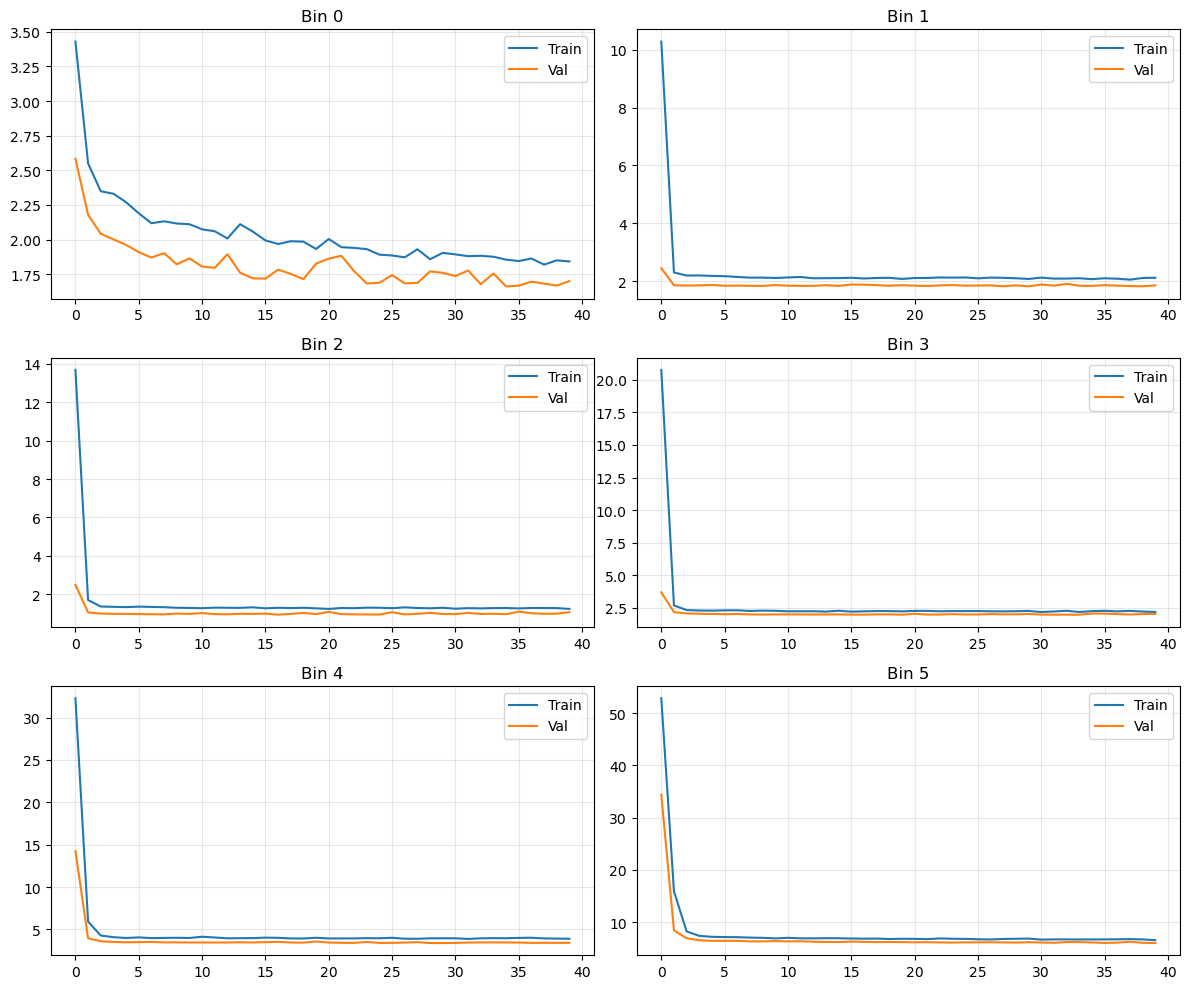

In [72]:
plot_all_bins(history)


The MAE curves show very fast convergence across all bins, with both training and validation errors dropping sharply within the first few epochs. After this initial phase, the curves stabilize and remain close together, indicating good generalization and no signs of overfitting. As expected, lower-age bins (0–2) achieve the lowest MAE, while higher-age bins (4–5) show higher error due to greater variability and fewer samples. Overall, the regressors learn smoothly and consistently across bins.

In [73]:
def plot_best_mae(history):
    bins = sorted(history.keys())
    best_train = [min(history[b]["train"]) for b in bins]
    best_val = [min(history[b]["val"]) for b in bins]

    plt.figure(figsize=(8, 5))
    plt.plot(bins, best_train, marker="o", label="Best Train MAE")
    plt.plot(bins, best_val, marker="o", label="Best Val MAE")
    plt.xticks(bins)
    plt.title("Best MAE for each bin")
    plt.xlabel("Bin")
    plt.ylabel("MAE")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


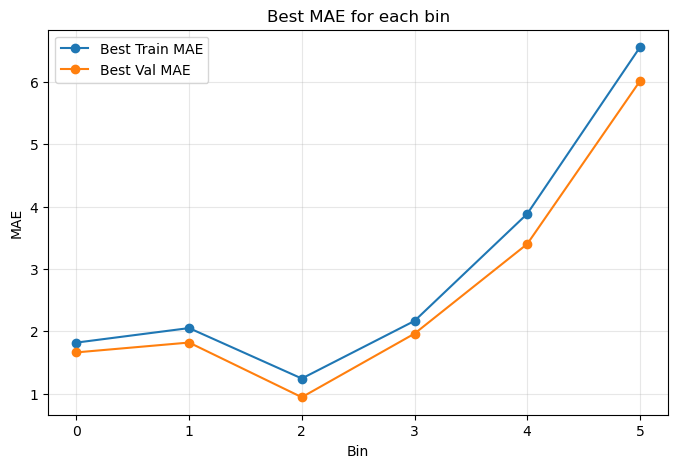

In [74]:
plot_best_mae(history)


The figure shows the best training and validation MAE achieved by each of the six regressors and conferms what said in the previous comments.

## Testing predictions

Now we can test how the whole model works in predicting the punctual age.

In [ ]:
# Loads the pretrained multitask model, moves it to the device, and sets it to evaluation mode.
multitask = CNN_MultiTask()
multitask.load_state_dict(torch.load("best_resnet18_multitask.pt", map_location=device))
multitask.to(device)
multitask.eval()

# Rebuilds the coarse age classifier using the multitask backbone, loads its trained weights, moves it to the device, and switches to evaluation mode.
coarse_model = CoarseAgeClassifier(multitask_backbone=multitask, num_bins=6)
coarse_model.load_state_dict(torch.load("best_coarse_classifier.pt", map_location=device))
coarse_model.to(device)
coarse_model.eval()

# Creates a frozen feature extractor that outputs 512-dim embeddings for regression.
backbone = FeatureExtractor(coarse_model).to(device)
backbone.eval()

# Loads all 6 fine-tuned regressors (one per bin) and stores them in a dictionary ready for inference.
regressors = {}
for b in range(6):
    reg = AgeRegressor(backbone).to(device)
    reg.load_state_dict(torch.load(f"regressor_bin{b}.pt", map_location=device))
    reg.eval()
    regressors[b] = reg

This code evaluates the complete two-stage age-prediction pipeline on the test set.
For each test image, it uses the true bin to select the corresponding regression model and predicts the exact age. It then stores both true and predicted ages, computing MAE, MSE, and RMSE separately for each bin and for the entire test set.
In this way, we can measure how well each bin-specific regressor performs, and also assess the global accuracy of the full regression system.

In [80]:
# Evaluation
bin_true_ages = {b: [] for b in range(6)}
bin_pred_ages = {b: [] for b in range(6)}

all_true = []
all_pred = []

test_i = 0  

for x, true_bin in test_loader:
    x = x.to(device)

    for i in range(x.size(0)):
        img = x[i].unsqueeze(0)
        b   = int(true_bin[i].item())    # true bin
        age = float(test_ages[test_i])   # true age
        test_i += 1

        with torch.no_grad():
            pred_age = regressors[b](img).item()

        # saving
        bin_true_ages[b].append(age)
        bin_pred_ages[b].append(pred_age)

        all_true.append(age)
        all_pred.append(pred_age)

# Metrics for each bin
for b in range(6):

    if len(bin_true_ages[b]) == 0:
        print(f"Bin {b}: no example in the test set")
        continue

    y_t = np.array(bin_true_ages[b])
    y_p = np.array(bin_pred_ages[b])

    mae = mean_absolute_error(y_t, y_p)
    mse = mean_squared_error(y_t, y_p)
    rmse = np.sqrt(mse)
    
    print(f" BIN {b} ")
    print(f"MAE : {mae:.3f}")
    print(f"MSE : {mse:.3f}")
    print(f"RMSE: {rmse:.3f}")

# Overall metrics for the whole test set
all_true = np.array(all_true)
all_pred = np.array(all_pred)

mae_tot = mean_absolute_error(all_true, all_pred)
mse_tot = mean_squared_error(all_true, all_pred)
rmse_tot = np.sqrt(mse_tot)

print("Overall metrics")
print(f"MAE : {mae_tot:.3f}")
print(f"MSE : {mse_tot:.3f}")
print(f"RMSE: {rmse_tot:.3f}")


 BIN 0 
MAE : 3.723
MSE : 27.051
RMSE: 5.201
 BIN 1 
MAE : 2.038
MSE : 6.167
RMSE: 2.483
 BIN 2 
MAE : 1.022
MSE : 1.810
RMSE: 1.345
 BIN 3 
MAE : 2.145
MSE : 7.152
RMSE: 2.674
 BIN 4 
MAE : 4.715
MSE : 34.446
RMSE: 5.869
 BIN 5 
MAE : 5.541
MSE : 52.266
RMSE: 7.230
Overall metrics
MAE : 3.196
MSE : 21.476
RMSE: 4.634


As expected also in the test set the regressors perform well in the lower and intermediate age ranges (bins 0, 1, 2), where the MAE is around 1–2 years, indicating that the model can estimate the age with very limited error when the underlying distribution is dense and more homogeneous.
For bins 3 and 4 the errors slightly increase, which is expected due to higher variability and fewer training examples, while, as expected, the largest error appears in bin 5.

In [81]:
class FaceDatasetAge(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True) # Ensures clean sequential indexing.
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx] # Retrieves the row corresponding to the index idx.

        img = row["pixels"].reshape(48, 48).astype(np.uint8)
        img = Image.fromarray(img, mode="L") # greyscale mode 

        if self.transform:
            img = self.transform(img) # Applies transforms (resize, augmentation, tensor conversion).

        age = float(row["age"]) # true age
        bin_true = int(row["coarse_bin"]) # true bin

        return img, age, bin_true


In [99]:
# Test dataset and test loader
test_ds = FaceDatasetAge(test_df, transform=train_transform)

test_loader = DataLoader(test_ds, batch_size=64, shuffle=True)


In [87]:
def show_predictions(coarse_model, regressors, loader, device, num_images=12):
    coarse_model.eval()
    for r in regressors.values():
        r.eval()

    BIN_RANGES = [
        "1–16",
        "16–26",
        "26–29",
        "29–37",
        "37–53",
        "53–90"
    ]

    cols = 4
    rows = (num_images + cols - 1) // cols

    plt.figure(figsize=(4 * cols, 4 * rows))
    shown = 0

    for x, true_age, true_bin in loader:
        x = x.to(device)

        for i in range(x.size(0)):
            if shown >= num_images:
                plt.tight_layout()
                plt.show()
                return

            img = x[i].unsqueeze(0)

            # Predicted coarse bin
            with torch.no_grad():
                logits = coarse_model(img)
                pred_bin = logits.argmax(1).item()

            # Predicted age
            reg = regressors[pred_bin]
            with torch.no_grad():
                pred_age = reg(img).item()

            # Plot
            plt.subplot(rows, cols, shown + 1)
            plt.imshow(x[i].cpu().squeeze(), cmap="gray")
            plt.axis("off")

            plt.title(
                f"True Age: {true_age[i]:.1f}\n"
                f"True Range: {BIN_RANGES[true_bin[i]]}\n"
                f"Pred Range: {BIN_RANGES[pred_bin]}\n"
                f"Age: {pred_age:.1f}",
                fontsize=9
            )

            shown += 1

    plt.tight_layout()
    plt.show()

In [90]:
def parse_pixels(px_str):
    return np.array(px_str.split(), dtype=np.uint8)

test_df["pixels"] = test_df["pixels"].apply(parse_pixels)

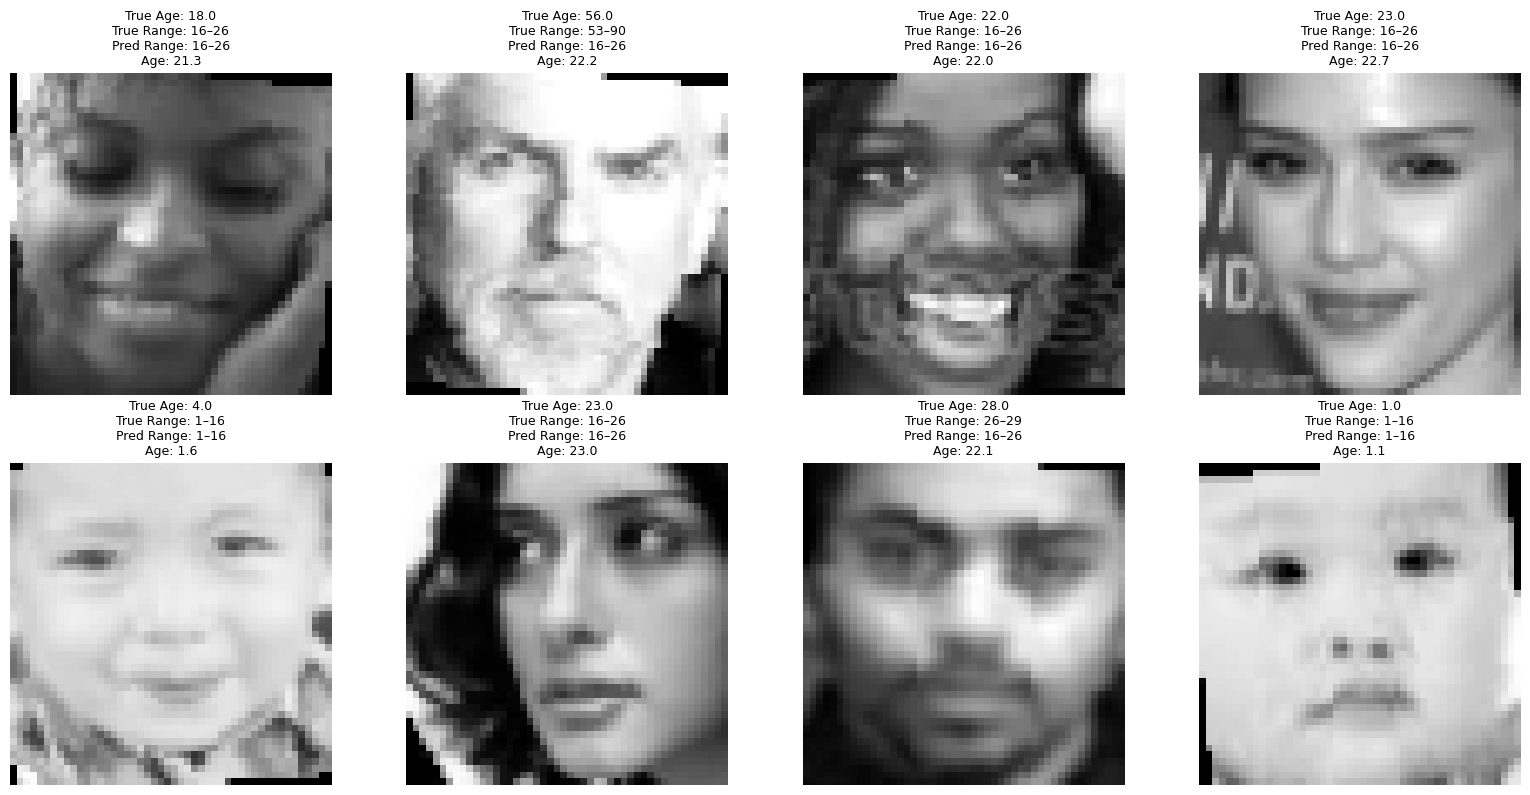

In [107]:
seed = 5
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

show_predictions(
    coarse_model,
    regressors,
    test_loader,
    device,
    num_images=8
)


The qualitative results show that the model is generally able to assign images to the correct coarse age range and produce reasonable fine-grained age estimates. For young children, the predictions seems very accurate, with estimated ages extremely close to the true ones. The model performs well also for adults in mid-range bins, although some errors appear when the predicted coarse bin is incorrect, such as the case where a 28-year-old is assigned to the 16–26 bin, leading to an underestimation (22.1).   
Indeed, "_many existing divide-et-conquer methods divide the age range into indipendent groups for classification and leave out of consideration the realtionship between adjacent age groups. An arbitrary age grouping will lead to the boundary effect on classification, i.e. one sampe near the boundary of two adjcent age groups can be classified as either one_" (see References [7]).   
A possible extension of this approach would be to incorporate this information directly into the bin-splitting strategy, ensuring more balanced partitions and potentially leading to more stable and accurate regression results.  
However, the visual inspection confirms that the system is capable of capturing meaningful aging patterns and generally produces coherent age predictions across a wide range of faces.

The code below shows how to test the model on real images, following the same pipeline used for the multitask classification model. The evaluation procedure is identical: a coarse bin is predicted first, and the corresponding regressor is then applied to estimate the final age.

In [108]:
def load_and_preprocess_image(path, transform):
    # Load image (RGB or grayscale)
    img = Image.open(path).convert("L")

    # Resize to 48x48 
    img = img.resize((48, 48))

    # Keep raw version for plotting
    img_raw = np.array(img)

    # Apply same transform used for test set
    img_tensor = transform(img)
    img_tensor = img_tensor.unsqueeze(0)   # shape: [1, 1, 48, 48]

    return img_raw, img_tensor


In [109]:
def predict_single_age(img_tensor, coarse_model, regressors, device):
    img_tensor = img_tensor.to(device)

    # 1) Coarse classifier prediction 
    with torch.no_grad():
        logits = coarse_model(img_tensor)
        pred_bin = logits.argmax(1).item()

    # 2) Regressor for that bin 
    reg = regressors[pred_bin]
    with torch.no_grad():
        pred_age = reg(img_tensor).item()

    return pred_bin, pred_age


In [110]:
BIN_RANGES = [
    "1–16",
    "16–26",
    "26–29",
    "29–37",
    "37–53",
    "53–90"
]

def predict_on_image_age_only(path, coarse_model, regressors, transform, device):
    # Load & preprocess
    img_raw, img_tensor = load_and_preprocess_image(path, transform)

    # Predict
    pred_bin, pred_age = predict_single_age(img_tensor, coarse_model, regressors, device)

    # Print results
    print("Age prediction")
    print(f"Predicted Bin : {pred_bin}  ({BIN_RANGES[pred_bin]})")
    print(f"Predicted Age : {pred_age:.1f}")

    # Show image
    plt.figure(figsize=(5,5))
    plt.imshow(img_raw, cmap="gray")
    plt.title(f"Pred Age: {pred_age:.1f}\nRange: {BIN_RANGES[pred_bin]}")
    plt.axis("off")
    plt.show()


Age prediction
Predicted Bin : 1  (16–26)
Predicted Age : 22.6


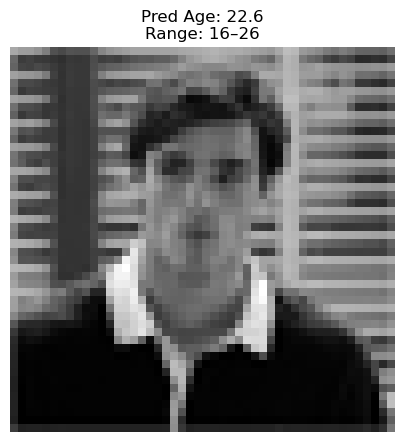

In [114]:
predict_on_image_age_only(
    "~/Desktop/jacob.jpg",
    coarse_model,
    regressors,
    train_transform,
    device
)

In [501]:
preds = []
with torch.no_grad():
    for imgs, _, _ in test_loader:   
        imgs = imgs.to(device)

        # 1) Predicted bin
        coarse_logits = coarse_model(imgs)
        pred_coarse = coarse_logits.argmax(1).cpu().numpy()

        # 2) Predicted age
        for i in range(len(imgs)):
            reg = regressors[pred_coarse[i]]
            age_pred = reg(imgs[i].unsqueeze(0)).item()
            preds.append(age_pred)

# True values
trues = test_df["age"].values
bins_true = test_df["coarse_bin"].values

In [515]:
def plot_error_hist(preds, trues):
    preds = np.array(preds)
    trues = np.array(trues)

    error = preds - trues
    mean_err = error.mean()

    plt.figure(figsize=(7, 4))
    plt.hist(error, bins=40, alpha=0.75, color="steelblue")
    
    # Mean red line
    plt.axvline(mean_err, color="red", linestyle="--", linewidth=2,
                label=f"Mean error = {mean_err:.2f} years")

    plt.title("Distribution of prediction error")
    plt.xlabel("Error (pred − true)")
    plt.ylabel("Count")
    plt.legend()

    plt.show()


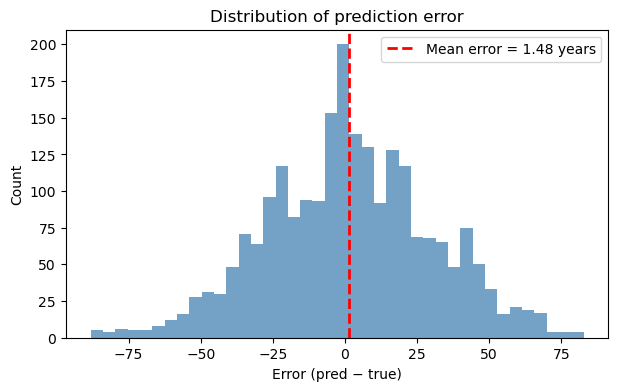

In [516]:
plot_error_hist(preds, trues)

The histogram shows how far the model’s predictions deviate from the true ages across the whole test set. The error distribution is roughly centered around zero, indicating that the model is not systematically over or under estimating age. The mean error is approximately +1.48 years, meaning predictions are on average very close to the true age. However, the spread of the histogram highlights that some predictions can still be significantly off, especially for very young or very old individuals (an expected effect given the strong imbalance and low image resolution).

# Conclusion

The multitask classifier achieved solid accuracy on both gender and ethnicity, performing reliably even in the presence of several dataset limitations such as low-resolution grayscale format 48×48 pixels, poor contrast, and substantial class imbalance. Despite these challenges, the network was able to extract meaningful visual representations and generalize well across demographic categories.   

For age estimation, we adopted a two-stage pipeline: first, a coarse classifier assigned each face to one of six equally populated age bins (reaching about 58% accuracy), and then a dedicated regressor refined the prediction within the selected bin. This strategy proved particularly effective for dealing with the highly skewed age distribution of the dataset, where some age groups contain thousands of samples and others only a few dozen.  
The final regression model achieved a global MAE of roughly 3–4 years, which is competitive considering the quality of the images and the limited sample diversity. Performance varied across bins: intermediate age groups obtained very accurate predictions (around 1 year MAE), while errors increased for oldest individuals due to data scarcity and greater facial variability. Overall, the system demonstrates robustness and delivers reliable age predictions despite the inherent challenges of the dataset.

In conclusion, this analysis achieved reasonably good results given the limitations of the dataset. However, using higher-quality images (RGB, better resolution, less noise) and a more balanced distribution of samples across ethnicity and age would likely lead to significantly better performance, especially when predicting on completely unseen real-world images, such as personal photos or images sourced online.

# References

[1] Age, Gender and Ethnicity Face Data (CSV). (2020). Kaggle Data Repository.
Available at: https://www.kaggle.com/datasets/nipunarora8/age-gender-and-ethnicity-face-data-csv

[2] Amit, H. (2024). A guide to multi-task learning in machine learning. Medium.
https://medium.com/data-scientists-diary/a-guide-to-multi-task-learning-in-machine-learning-768d22b88715

[3] GeeksforGeeks. (2025). What is Fine-Tuning in Deep Learning?
https://www.geeksforgeeks.org/deep-learning/what-is-fine-tuning/

[4] Grandini, M., Bagli, E., & Visani, G. (2020). Metrics for multi-class classification: An overview (White paper). CRIF S.p.A., University of Bologna.
https://arxiv.org/abs/2008.05756

[5] Hughes, C. (2022). Demystifying PyTorch’s WeightedRandomSampler by example. Medium.
https://medium.com/data-science/demystifying-pytorchs-weightedrandomsampler-by-example-a68aceccb452

[6] Kumar, T., Mileo, A., Brennan, R., & Bendechache, M. (2023). Image data augmentation approaches: A comprehensive survey and future directions. arXiv.
https://arxiv.org/abs/2301.02830

[7] Liu, N., Zhang, F., & Duan, F. (2020). Facial age estimation using a multi-task network combining classification and regression. IEEE Access, 8, 96365–96375. https://doi.org/10.1109/ACCESS.2020.2994322

[8] Van Otten, N. (2024). Cosine annealing in machine learning simplified: Understand how it works. Spot Intelligence.
https://spotintelligence.com/2024/04/29/cosine-annealing-in-machine-learning/

[9] Wong, W. (2019). What is label smoothing? Towards Data Science.
https://towardsdatascience.com/what-is-label-smoothing-108debd7ef06

[10] Wynn, F. (2024). The complete guide to data augmentation for computer vision. Encord.
https://encord.com/blog/data-augmentation-guide/


[11] Zhang, A., Lipton, Z. C., Li, M., & Smola, A. J. (2023). Dive into Deep Learning. Retrieved from https://d2l.ai